In [1]:
import numpy as np 
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.neighbors import NearestNeighbors
from openpyxl import Workbook
import hdbscan

In [2]:
def export_matrix_to_excel(matrix, filename):
  """
  Xuất ma trận numpy.ndarray sang file Excel.

  Args:
    matrix: Ma trận numpy.ndarray cần xuất.
    filename: Tên file Excel (ví dụ: 'matrix.xlsx').
  """
  wb = Workbook()
  ws = wb.active

  for row in matrix:
    ws.append(row.tolist())  # Chuyển đổi numpy.ndarray sang list

  wb.save(filename)
def update_column(matrix, N):
    matrix[:, N] = (matrix[:, N - 1] + matrix[:, N + 1]) / 2
    return matrix
def k_distance(X_std, n):
    # Xây dựng mô hình k-Means với k=10
    neighbors = n
    nbrs = NearestNeighbors(n_neighbors=neighbors ).fit(X_std)

    # Ma trận khoảng cách distances: (N, k)
    distances, indices = nbrs.kneighbors(X_std)

    # Lấy ra khoảng cách xa nhất từ phạm vi láng giềng của mỗi điểm và sắp xếp theo thứ tự giảm dần.
    distance_desc = sorted(distances[:, neighbors-1], reverse=True)

    # Vẽ biểu đồ khoảng cách xa nhất ở trên theo thứ tự giảm dần
    plt.figure(figsize=(12, 8))
    plt.plot(list(range(1,len(distance_desc )+1)), distance_desc)
    plt.ylabel('distance')
    plt.xlabel('indice')
    plt.title(f'Sorting Maximum Distance in {n} Nearest Neighbor of kNN')
def keep_top_N_elements(matrix, N):
    flat_matrix = matrix.ravel()
    indices = np.argpartition(flat_matrix, -N)[-N:]
    result = np.zeros_like(matrix)
    result.flat[indices] = flat_matrix[indices]
    return result
def find_median_x(coords):
    # Lấy danh sách các hoành độ từ cột đầu tiên của mảng numpy
    x_coords = coords[:, 1]  # Cột đầu tiên là tung độ
    
    # Sắp xếp danh sách hoành độ
    x_coords.sort()
    
    # Tìm hoành độ trung bình (median)
    n = len(x_coords)
    if n % 2 == 1:
        # Nếu số điểm là lẻ, median là giá trị tại giữa
        median_x = x_coords[n // 2]
    else:
        # Nếu số điểm là chẵn, median là trung bình của hai giá trị giữa
        median_x = (x_coords[n // 2 - 1] + x_coords[n // 2]) / 2
        
    return median_x

In [3]:
def getNeighbors(P, D, eps):
  """
  Tìm các điểm lân cận của điểm P trong tập dữ liệu D với bán kính eps.

  Args:
    P: Điểm cần tìm lân cận.
    D: Tập dữ liệu.
    eps: Bán kính lân cận.

  Returns:
    Danh sách các điểm lân cận.
  """
  # Scale lại tọa độ y của D (chỉ scale cột y)
  D_scaled = D.copy()
  D_scaled[:, 1] = D[:, 1] / 3  
  
  # Scale lại tọa độ y của P (chỉ scale phần tử thứ 2)
  P_scaled = P.copy()
  P_scaled[1] = P[1] / 3

  tree = KDTree(D_scaled[:, :2])
  indices = tree.query_ball_point(P_scaled[:2], eps)

  # Lọc kết quả bằng indexing
  neighbors = D[indices][D[indices, 2] <= P[2]] 
  
  # Chuyển đổi kết quả sang list
  return neighbors.tolist() 
def tim_hang(D, X):
  """
  Kiểm tra sự tồn tại của hàng trong ma trận D có giá trị bằng với mảng X.

  Args:
    D: Ma trận NumPy.
    X: Mảng NumPy.

  Returns:
    True nếu tìm thấy hàng trong ma trận D, ngược lại trả về False.
  """
  return np.any(np.all(D == X, axis=1))
def xoa_hang(D, X):
  """
  Xóa hàng trong ma trận D có giá trị bằng với mảng X (tối ưu).

  Args:
    D: Ma trận NumPy.
    X: Mảng NumPy.

  Returns:
    Ma trận NumPy mới sau khi xóa hàng.
  """
  mask = ~np.all(D == X, axis=1)
  return D[mask]
def get_rows_not_in_set(D, C):
  """
  Lấy các hàng trong ma trận D mà không xuất hiện trong set C.

  Args:
    D: Ma trận đầu vào.
    C: Set đầu vào.

  Returns:
    Ma trận chứa các hàng trong D nhưng không trong C.
  """
  # Chuyển đổi set C thành mảng numpy
  C_np = np.array(list(C))
  # Tìm các hàng trong D không có trong C
  mask = ~np.any(np.all(D[:, np.newaxis] == C_np, axis=2), axis=1)
  return D[mask]
def KBSCAN(D,eps,MinPts):
    clusters = {}
    C = 1
    unvisited = D
    cluster_points = set()

    while(unvisited.size != 0):
        index_max = np.where(unvisited[:,2] == np.max(unvisited[:,2]))
        P = np.array(unvisited[index_max]).reshape(3,)

        neighbors = getNeighbors(P, D, eps)
        if tim_hang(unvisited,P):
            unvisited = xoa_hang(unvisited,P)
        if len(neighbors) >= MinPts: 
            clusters[C] = []
            clusters[C].append(P)
            cluster_points.add(tuple(P))
            for P_prime in neighbors:
                if tim_hang(unvisited,P_prime):
                    unvisited = xoa_hang(unvisited,P_prime)
                    neighbors_prime = getNeighbors(P_prime,D,eps)
                    if len(neighbors_prime) >= MinPts:
                        neighbors.extend(neighbors_prime)
                if tuple(P_prime) not in cluster_points:
                    clusters[C].append(P_prime)
                    cluster_points.add(tuple(P_prime))
            C += 1

    clusters[-1] = []
    clusters[-1].extend(get_rows_not_in_set(D, np.array(list(cluster_points))))

    Y = np.zeros((128,256))
    max_elements = 0
    index_max_elements = None
    for i in clusters:
        if len(clusters[i]) > max_elements:
            max_elements = len(clusters[i])
            index_max_elements = i

    # Lấy tọa độ x, y của các điểm trong cluster
    x_coords = np.array([int(row[0]) for row in clusters[index_max_elements]])
    y_coords = np.array([int(row[1]) for row in clusters[index_max_elements]])
    # Gán giá trị i cho các tọa độ tương ứng trong ma trận Y
    Y[x_coords, y_coords] = 1
    return Y

In [4]:
def adc_processing(adc_data):
    """
    Xử lý dữ liệu ADC đầu vào từ radar một cách tối ưu bằng vector hóa NumPy.
    
    Args:
    - adc_data (np.ndarray): Dữ liệu ADC thô đầu vào.
    - num_rx (int): Số lượng nhận.
    - num_adc_samples (int): Số mẫu ADC trên mỗi chirp.
    - num_chirps_in_frame (int): Số chirps trong mỗi khung.
    - num_tx (int): Số phát.
    - num_adc_bits (int): Số bit của ADC.
    
    Returns:
    - data (np.ndarray): Dữ liệu đã xử lý, sắp xếp theo định dạng (num_frames, num_chirps_in_frame, num_adc_samples).
    - num_frames (int): Tổng số khung dữ liệu.
    """
    # Điều chỉnh giá trị ADC nếu cần
    if num_adc_bits != 16: 
        l_max = 2**(num_adc_bits-1) -1 
        adc_data[adc_data>l_max] -= 2**num_adc_bits 

    file_size = adc_data.size
    num_chirps = file_size // (2 * num_adc_samples * num_rx)
    file_size = num_chirps * (2 * num_adc_samples * num_rx)
    adjusted_size = (file_size//4) * 4

    # Chuyển đổi ADC dữ liệu sang phức hợp
    lvds = np.zeros((file_size//2), dtype = complex)
    lvds[0::2] = adc_data[0:adjusted_size:4] + 1j*adc_data[2:adjusted_size:4]
    lvds[1::2] = adc_data[1:adjusted_size:4] + 1j*adc_data[3:adjusted_size:4]
    lvds = lvds.reshape((num_chirps), num_adc_samples*num_rx)

    # Reshape dữ liệu cho mỗi RX
    new_adc_data = np.zeros((num_rx, num_chirps * num_adc_samples), dtype = np.complex128)
    for row in range(num_rx):
        for i in range(num_chirps):
            new_adc_data[row, i*num_adc_samples:(i+1)*num_adc_samples] = lvds[i, row*num_adc_samples:(row+1)*num_adc_samples]

    # Xử lý RX1, TX1
    rx1 = np.reshape(new_adc_data[0,:],(num_chirps,128)) 
    rx1_tx1 = rx1[0::3]

    # Reshape dữ liệu thành các khung
    num_frames = num_chirps // (num_chirps_in_frame*num_tx)
    data = rx1_tx1[0:num_frames*num_chirps_in_frame]
    data = data.reshape((num_frames,num_chirps_in_frame,num_adc_samples))

    return data, num_frames
def doppler_fft_without_butter(data): 
    data_time = data
    tmp = np.fft.fft(data_time, axis = 0)
    doppler_fft = np.fft.fft(tmp, axis = 1)
    return doppler_fft
def read_binary_file(file_name, chunk_size=1024*1024):
    with open(file_name, 'rb') as f:
        while chunk := f.read(chunk_size):
            yield np.frombuffer(chunk, dtype=np.int16)
def read_binary_file_to_array(file_name, chunk_size=1024*1024):
    """
    Đọc file nhị phân lớn theo từng khối dữ liệu và hợp nhất thành mảng NumPy.
    
    Args:
    - file_name (str): Tên file nhị phân cần đọc.
    - chunk_size (int): Kích thước khối dữ liệu (bytes) sẽ đọc mỗi lần.
    
    Returns:
    - np.ndarray: Một mảng NumPy chứa toàn bộ dữ liệu từ file.
    """
    chunks = []
    for chunk in read_binary_file(file_name, chunk_size):
        chunks.append(chunk)
    return np.concatenate(chunks)

In [5]:
def plot_keep_N(i,N):
    data_test = doppler_fft_without_butter(data[i].T)
    doppler_magnitude = np.abs(data_test)
    velocity_bins = np.fft.fftfreq(Nc, d=1/Nc) * velocity_res
    # Shift zero-frequency component to center of spectrum
    doppler_magnitude = np.fft.fftshift(doppler_magnitude, axes=1)
    velocity_bins = np.fft.fftshift(velocity_bins)

    output_test = 20 * np.log10(doppler_magnitude)

    output_test = update_column(output_test,128)
    
    output_test_2 = np.copy(output_test)
    output_test_2[output_test > 70] = 100
    output_test_2[output_test <= 70] = 0
    indices = np.column_stack(np.where(output_test_2 == 100))
    db = DBSCAN(eps=3, min_samples=3)
    labels = db.fit_predict(indices)
    label_counts = Counter(labels)
    most_frequent_label = label_counts.most_common(1)[0][0]
    new_labels = [0 if label == most_frequent_label else 1 for label in labels]

    Y = np.zeros_like(output_test)
    for i, label in enumerate(new_labels):
        if label != -1:  # -1 là chỉ các điểm nhiễu (outliers) trong DBSCAN
            Y[indices[i, 0], indices[i, 1]] = label # Gán nhãn bắt đầu từ 1

    output_test = output_test - 30 * Y
    output_test = keep_top_N_elements(output_test,N)
    # Plot the Range-Velocity Map
    plt.figure(figsize=(30, 12))
    im =plt.imshow(output_test, aspect='auto', cmap='jet', extent=[velocity_bins.min(), velocity_bins.max(), R_max, 0])
    # Set the colorbar limits
    clim = im.get_clim()
    im.set_clim(clim[1]-25, clim[1])
    plt.title('Range-Velocity Map')
    plt.ylabel('Range (m)')
    plt.xlabel('Velocity (m/s)')
    plt.colorbar(label='Magnitude (dB)')
    plt.show()
def plot_keep_N_ghost(i,N):
    data_test = doppler_fft_without_butter(data[i].T)
    doppler_magnitude = np.abs(data_test)
    velocity_bins = np.fft.fftfreq(Nc, d=1/Nc) * velocity_res
    # Shift zero-frequency component to center of spectrum
    doppler_magnitude = np.fft.fftshift(doppler_magnitude, axes=1)
    velocity_bins = np.fft.fftshift(velocity_bins)

    output_test = 20 * np.log10(doppler_magnitude)

    output_test = update_column(output_test,128)
    
    output_test = keep_top_N_elements(output_test,N)
    # Plot the Range-Velocity Map
    plt.figure(figsize=(30, 12))
    im =plt.imshow(output_test, aspect='auto', cmap='jet', extent=[velocity_bins.min(), velocity_bins.max(), R_max, 0])
    # Set the colorbar limits
    clim = im.get_clim()
    im.set_clim(clim[1]-25, clim[1])
    plt.title('Range-Velocity Map')
    plt.ylabel('Range (m)')
    plt.xlabel('Velocity (m/s)')
    plt.colorbar(label='Magnitude (dB)')
    plt.show()
def cal_vec(i,N):
    data_test = doppler_fft_without_butter(data[i].T)
    doppler_magnitude = np.abs(data_test)
    velocity_bins = np.fft.fftfreq(Nc, d=1/Nc) * velocity_res
    # Shift zero-frequency component to center of spectrum
    doppler_magnitude = np.fft.fftshift(doppler_magnitude, axes=1)
    velocity_bins = np.fft.fftshift(velocity_bins)

    output_test = 20 * np.log10(doppler_magnitude)

    output_test = update_column(output_test,128)
    
    output_test_2 = np.copy(output_test)
    output_test_2[output_test > 70] = 100
    output_test_2[output_test <= 70] = 0
    indices = np.column_stack(np.where(output_test_2 == 100))
    db = DBSCAN(eps=3, min_samples=3)
    labels = db.fit_predict(indices)
    label_counts = Counter(labels)
    most_frequent_label = label_counts.most_common(1)[0][0]
    new_labels = [0 if label == most_frequent_label else 1 for label in labels]

    Y = np.zeros_like(output_test)
    for i, label in enumerate(new_labels):
        if label != -1:  # -1 là chỉ các điểm nhiễu (outliers) trong DBSCAN
            Y[indices[i, 0], indices[i, 1]] = label # Gán nhãn bắt đầu từ 1

    output_test = output_test - 30 * Y
    output_test = keep_top_N_elements(output_test,N)

    indices_2 = np.column_stack(np.where(output_test > 1))
    torso_vec = int(find_median_x(indices_2))

    return(torso_vec)
def cal_vec_with_ghost(i,N):
    data_test = doppler_fft_without_butter(data[i].T)
    doppler_magnitude = np.abs(data_test)
    velocity_bins = np.fft.fftfreq(Nc, d=1/Nc) * velocity_res
    # Shift zero-frequency component to center of spectrum
    doppler_magnitude = np.fft.fftshift(doppler_magnitude, axes=1)
    velocity_bins = np.fft.fftshift(velocity_bins)

    output_test = 20 * np.log10(doppler_magnitude)

    output_test = update_column(output_test,128)
    output_test = keep_top_N_elements(output_test,N)

    indices_2 = np.column_stack(np.where(output_test > 1))
    torso_vec = int(find_median_x(indices_2))

    return(torso_vec)
def plot_vec_ghost(N):
    vec_time_with_ghost = np.zeros(267)
    for i in range(267): 
        vec_time_with_ghost[i] = cal_vec_with_ghost(i,N)

    data_final_2 = (vec_time_with_ghost / 256) * 37.4 - 18.7
    x = list(range(len(data_final_2)))

    # Trục tung là giá trị của các phần tử trong mảng
    y = data_final_2

    plt.figure(figsize=(30, 12))
    # Vẽ đồ thị
    plt.plot(x, y, marker='o')

    # Gán nhãn trục
    plt.xlabel('Frame')
    plt.ylabel('Vận tốc thân')

    plt.title(f'Đồ thị vận tốc theo frame (chưa lọc) - Giá trị i = {N}')
    # Hiển thị đồ thị

    plt.show()
def plot_vec(N):
    vec_time = np.zeros(267)
    for i in range(267): 
        vec_time[i] = cal_vec(i,N)

    data_final = (vec_time / 256) * 37.4 - 18.7
    x = list(range(len(data_final)))

    # Trục tung là giá trị của các phần tử trong mảng
    y = data_final

    plt.figure(figsize=(30, 12))
    # Vẽ đồ thị
    plt.plot(x, y, marker='o')

    # Gán nhãn trục
    plt.xlabel('Frame')
    plt.ylabel('Vận tốc thân')
    plt.title(f'Đồ thị vận tốc theo frame (đã lọc) - Giá trị i = {N}')
    # Hiển thị đồ thị

    plt.show()

In [ ]:
num_adc_bits = 16
num_adc_samples = 128
num_rx = 4
num_tx = 3
num_lanes = 2 
is_real = 0
num_chirps_in_frame = 256

f0 = 60      # min frequency
B = 3239     # sweep bandwidth
S = 54       # sweep slope
fs = 4000    # sampling freq
Nc = 256     # num chirps in 1 frame #128 
Ns = 128     # num samples of 1 chirp 
c0 = 3e+8
idle_time = 5e-6

fc = f0+B/2000   
lamda = c0/(fc*1e+9)
Tc= idle_time + (B/S)*(1e-6)

R_res = c0 / (2e+6*B)       
R_max = fs*c0 / (2e+9*S)
velocity_res = lamda/(2*Nc*Tc)
v_max = lamda/(4*Tc)

print(R_res)
print(R_max)
print(velocity_res)
print(v_max)

0.04631058968817536
11.11111111111111
0.14633341751423926
18.730677441822625


In [7]:
def plot_original(i):
    # Plot the Range-Velocity Map
    plt.figure(figsize=(30, 12))
    im =plt.imshow(processed_data[i], aspect='auto', cmap='jet', extent=[velocity_bins.min(), velocity_bins.max(), R_max, 0])
    clim = im.get_clim()
    im.set_clim(clim[1] - 70, clim[1])
    plt.title('Range-Velocity Map')
    plt.ylabel('Range (m)')
    plt.xlabel('Velocity (m/s)')
    plt.colorbar(label='Magnitude (dB)')
    plt.show()
def plot_bf_cluster(i):
    output_test = np.copy(processed_data[i])
    output_test[output_test > 70] = 100
    output_test[output_test <= 70] = 0

    # Plot the Range-Velocity Map
    plt.figure(figsize=(30, 12))
    im =plt.imshow(output_test, aspect='auto', cmap='jet', extent=[velocity_bins.min(), velocity_bins.max(), R_max, 0])
    clim = im.get_clim()
    im.set_clim(clim[0], clim[1])
    plt.title('Range-Velocity Map')
    plt.ylabel('Range (m)')
    plt.xlabel('Velocity (m/s)')
    plt.colorbar(label='Magnitude (dB)')
    plt.show()
def plot_af_cluster(i):
    output_test = np.copy(processed_data[i])
    output_test[output_test > 70] = 100
    output_test[output_test <= 70] = 0

    #DBSCAN
    indices = np.column_stack(np.where(output_test == 100))
    db = hdbscan.HDBSCAN(min_cluster_size=3, cluster_selection_epsilon=3)
    labels = db.fit_predict(indices)
    #Tìm lấy cụm có số phần tử nhiều nhất
    label_counts = Counter(labels)
    most_frequent_label = label_counts.most_common(1)[0][0]
    new_labels = [0 if label == most_frequent_label else 1 for label in labels]
    #Output ma trận nhãn
    Y = np.zeros_like(output_test)
    for i, label in enumerate(new_labels):
            Y[indices[i, 0], indices[i, 1]] = label + 1

    # Vẽ hình ảnh trực quan của ma trận Y (các cụm được gán nhãn)
    plt.figure(figsize=(30, 12))
    plt.imshow(Y, cmap='tab20', interpolation='nearest')
    plt.title('DBSCAN Clustering on Matrix X')
    plt.colorbar(label='Cluster Label')
    plt.show()
def plot_final(i):
    output_test = np.copy(processed_data[i])
    output_test_2 = np.copy(output_test)
    output_test_2[output_test > 70] = 100
    output_test_2[output_test <= 70] = 0

    #DBSCAN
    indices = np.column_stack(np.where(output_test_2 == 100))
    db = hdbscan.HDBSCAN(min_cluster_size=3, cluster_selection_epsilon=3)
    labels = db.fit_predict(indices)
    #Tìm lấy cụm có số phần tử nhiều nhất
    label_counts = Counter(labels)
    most_frequent_label = label_counts.most_common(1)[0][0]
    new_labels = [1 if label == most_frequent_label else 0 for label in labels]
    #Output ma trận nhãn
    Y = np.zeros_like(output_test)
    for i, label in enumerate(new_labels):
        Y[indices[i, 0], indices[i, 1]] = label
    #Output ma trận RD sau khi phân cụm
    mean = np.mean(output_test)
    output_test[Y<0.5] = mean

    # Plot the Range-Velocity Map
    plt.figure(figsize=(30, 12))
    im =plt.imshow(output_test, aspect='auto', cmap='jet', extent=[velocity_bins.min(), velocity_bins.max(), R_max, 0])
    # Set the colorbar limits
    clim = im.get_clim()
    im.set_clim(clim[1]- 40, clim[1])
    plt.title('Range-Velocity Map')
    plt.ylabel('Range (m)')
    plt.xlabel('Velocity (m/s)')
    plt.colorbar(label='Magnitude (dB)')
    plt.show()
def plot_KBSCAN(i):
    output_test = np.copy(processed_data[i])
    output_test_2 = np.copy(output_test)
    output_test_2[output_test > 70] = 100
    output_test_2[output_test <= 70] = 0

    #DBSCAN
    indices = np.column_stack(np.where(output_test_2 == 100))
    db = hdbscan.HDBSCAN(min_cluster_size=3, cluster_selection_epsilon=3)
    labels = db.fit_predict(indices)
    #Tìm lấy cụm có số phần tử nhiều nhất
    label_counts = Counter(labels)
    most_frequent_label = label_counts.most_common(1)[0][0]
    new_labels = [1 if label == most_frequent_label else 0 for label in labels]
    #Output ma trận nhãn
    Y = np.zeros_like(output_test)
    for i, label in enumerate(new_labels):
        Y[indices[i, 0], indices[i, 1]] = label
    mean = np.mean(output_test)
    output_test[Y<0.5] = mean
    #Prepare data for KBSCAN
    indices_2 = np.column_stack(np.where(Y == 1))
    out = np.copy(output_test)
    out[Y < 0.5] = 0
    k = (out[out>0]).reshape(-1,1)
    D = np.concatenate((indices_2,k),axis=1)
    #KBSCAN
    Y = KBSCAN(D,2,3)

    # Vẽ hình ảnh trực quan của phân cụm bằng KBSCAN
    plt.figure(figsize=(30, 12))
    plt.imshow(Y, cmap='tab20', interpolation='nearest')
    plt.title('DBSCAN Clustering on Matrix X')
    plt.colorbar(label='Cluster Label')
    plt.show()
def plot_final_2(i):
    output_test = np.copy(processed_data[i])

    #DBSCAN
    output_test_2 = np.copy(output_test)
    output_test_2[output_test > 70] = 100
    output_test_2[output_test <= 70] = 0
    indices = np.column_stack(np.where(output_test_2 == 100))
    db = hdbscan.HDBSCAN(min_cluster_size=3, cluster_selection_epsilon=3)
    #Tìm lấy cụm có số phần tử nhiều nhất
    labels = db.fit_predict(indices)
    label_counts = Counter(labels)
    most_frequent_label = label_counts.most_common(1)[0][0]
    new_labels = [1 if label == most_frequent_label else 0 for label in labels]
    #Output ma trận nhãn
    Y = np.zeros_like(output_test)
    for i, label in enumerate(new_labels):
        Y[indices[i, 0], indices[i, 1]] = label

    #Prepare data for KBSCAN
    indices_2 = np.column_stack(np.where(Y == 1))
    out = np.copy(output_test)
    out[Y < 0.5] = 0
    k = (out[out>0]).reshape(-1,1)
    D = np.concatenate((indices_2,k),axis=1)
    #KBSCAN
    Y = KBSCAN(D,2,3)

    #Output ma trận RD sau khi phân cụm
    mean = np.mean(output_test)
    output_test[Y<0.5] = mean
    
    # Plot the Range-Velocity Map
    plt.figure(figsize=(30, 12))
    im =plt.imshow(output_test, aspect='auto', cmap='jet', extent=[velocity_bins.min(), velocity_bins.max(), R_max, 0])
    # Set the colorbar limits
    clim = im.get_clim()
    im.set_clim(clim[1]- 40, clim[1])
    plt.title('Range-Velocity Map')
    plt.ylabel('Range (m)')
    plt.xlabel('Velocity (m/s)')
    plt.colorbar(label='Magnitude (dB)')
    plt.show()

In [8]:
file_name = "Khanh_ngang_2_ban.bin"
chunk_size = 1024 * 1024  # Đọc từng khối 1 MB
adc_data = read_binary_file_to_array(file_name, chunk_size)
data, num_frames = adc_processing(adc_data)

processed_data = np.zeros((num_frames,128,256), dtype=float)
for i in range(num_frames):
    data_test_test2 = doppler_fft_without_butter(data[i].T)
    doppler_magnitude = np.abs(data_test_test2)
    doppler_magnitude = np.fft.fftshift(doppler_magnitude, axes=1)
    output = 20 * np.log10(doppler_magnitude)
    output = update_column(output,128)
    processed_data[i] = output

velocity_bins = np.fft.fftfreq(Nc, d=1/Nc) * velocity_res
velocity_bins = np.fft.fftshift(velocity_bins)

In [13]:
num_frames

315

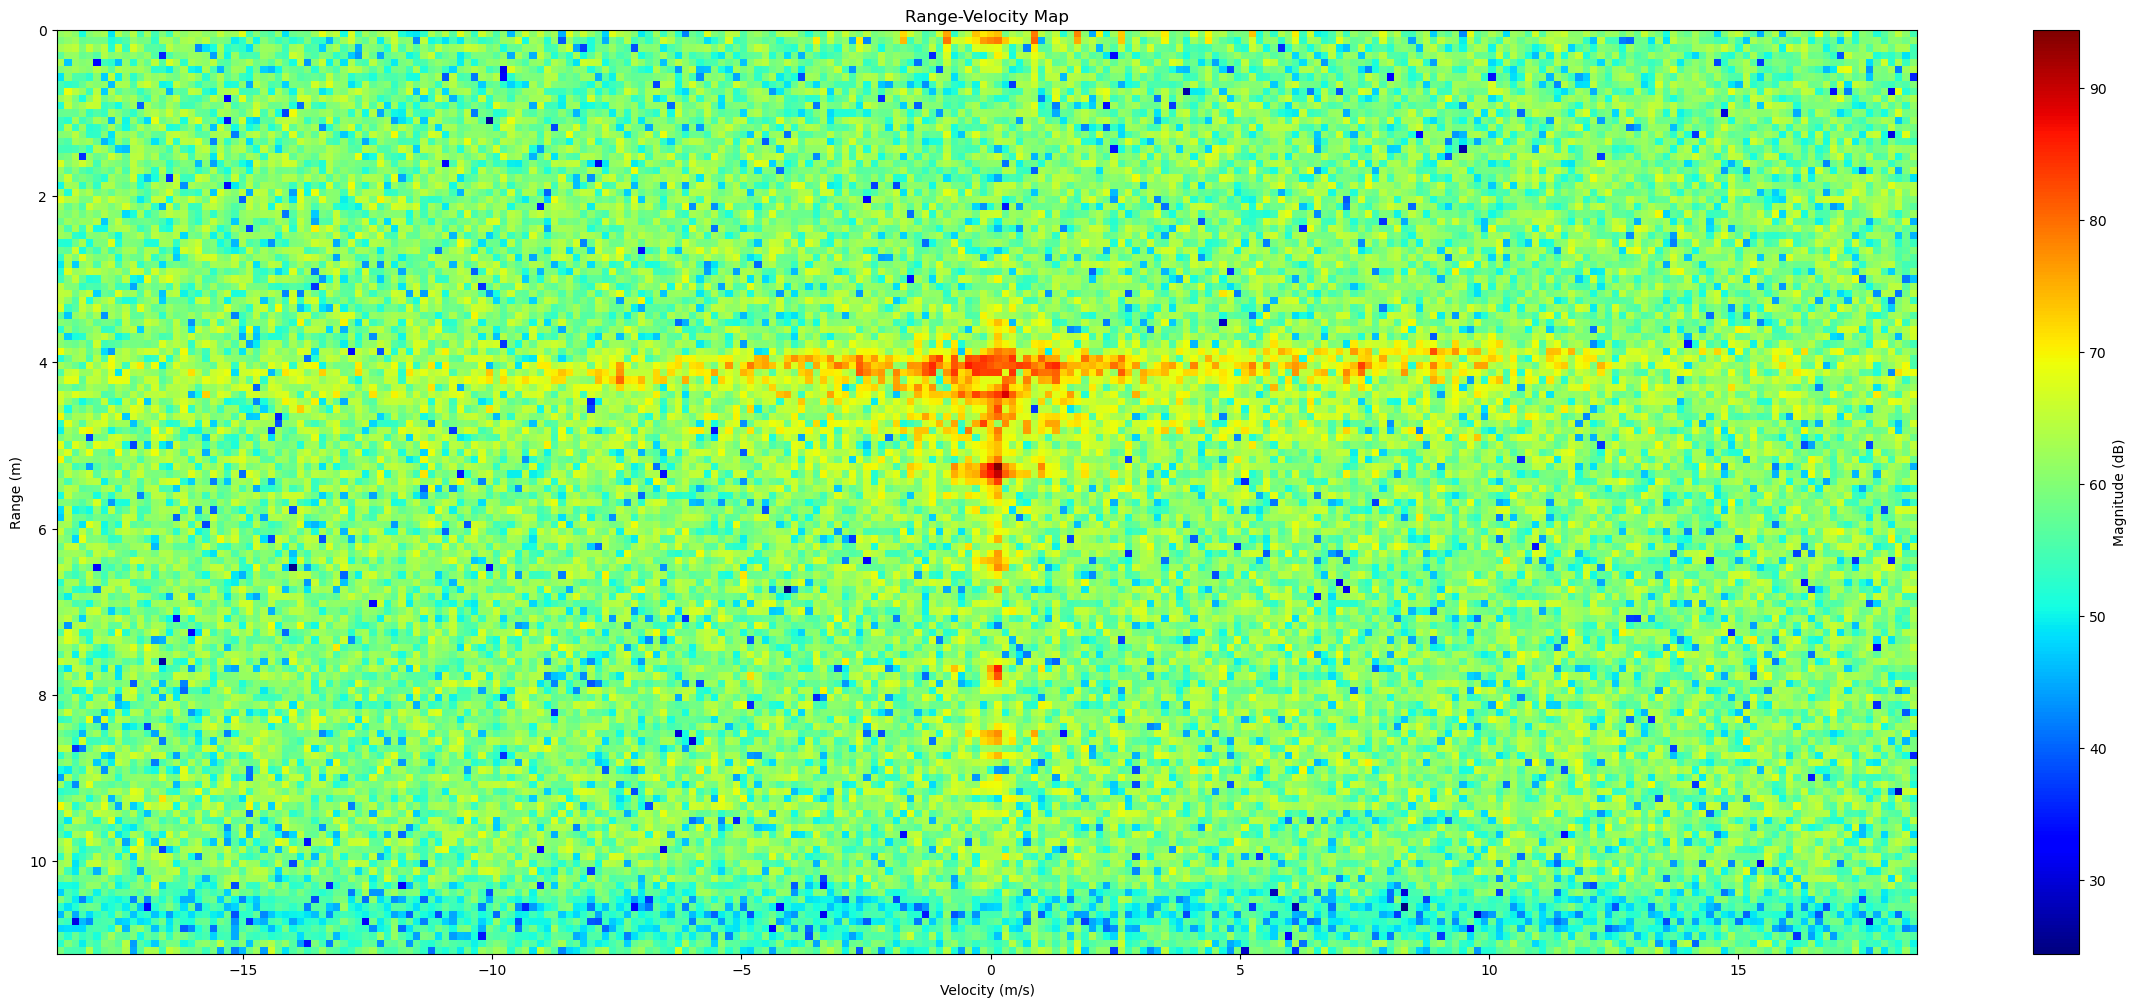

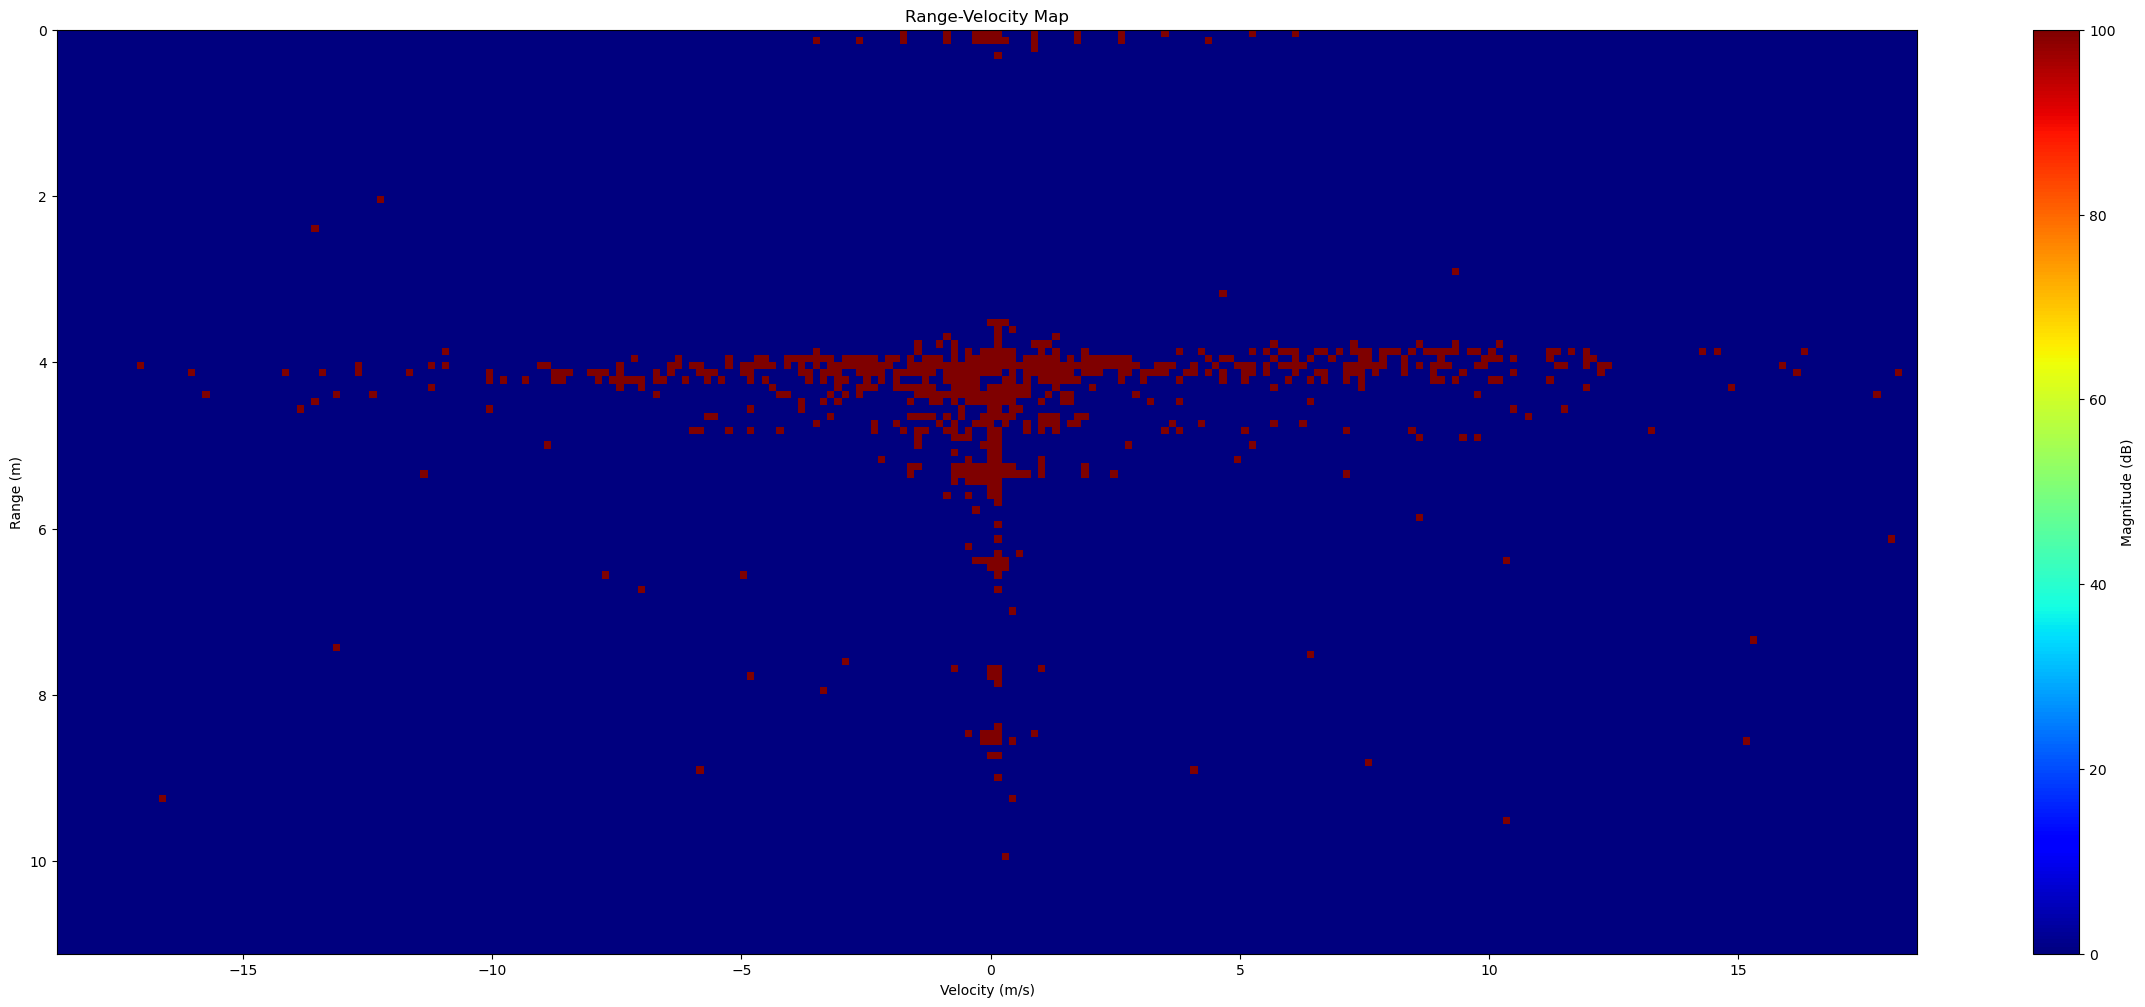

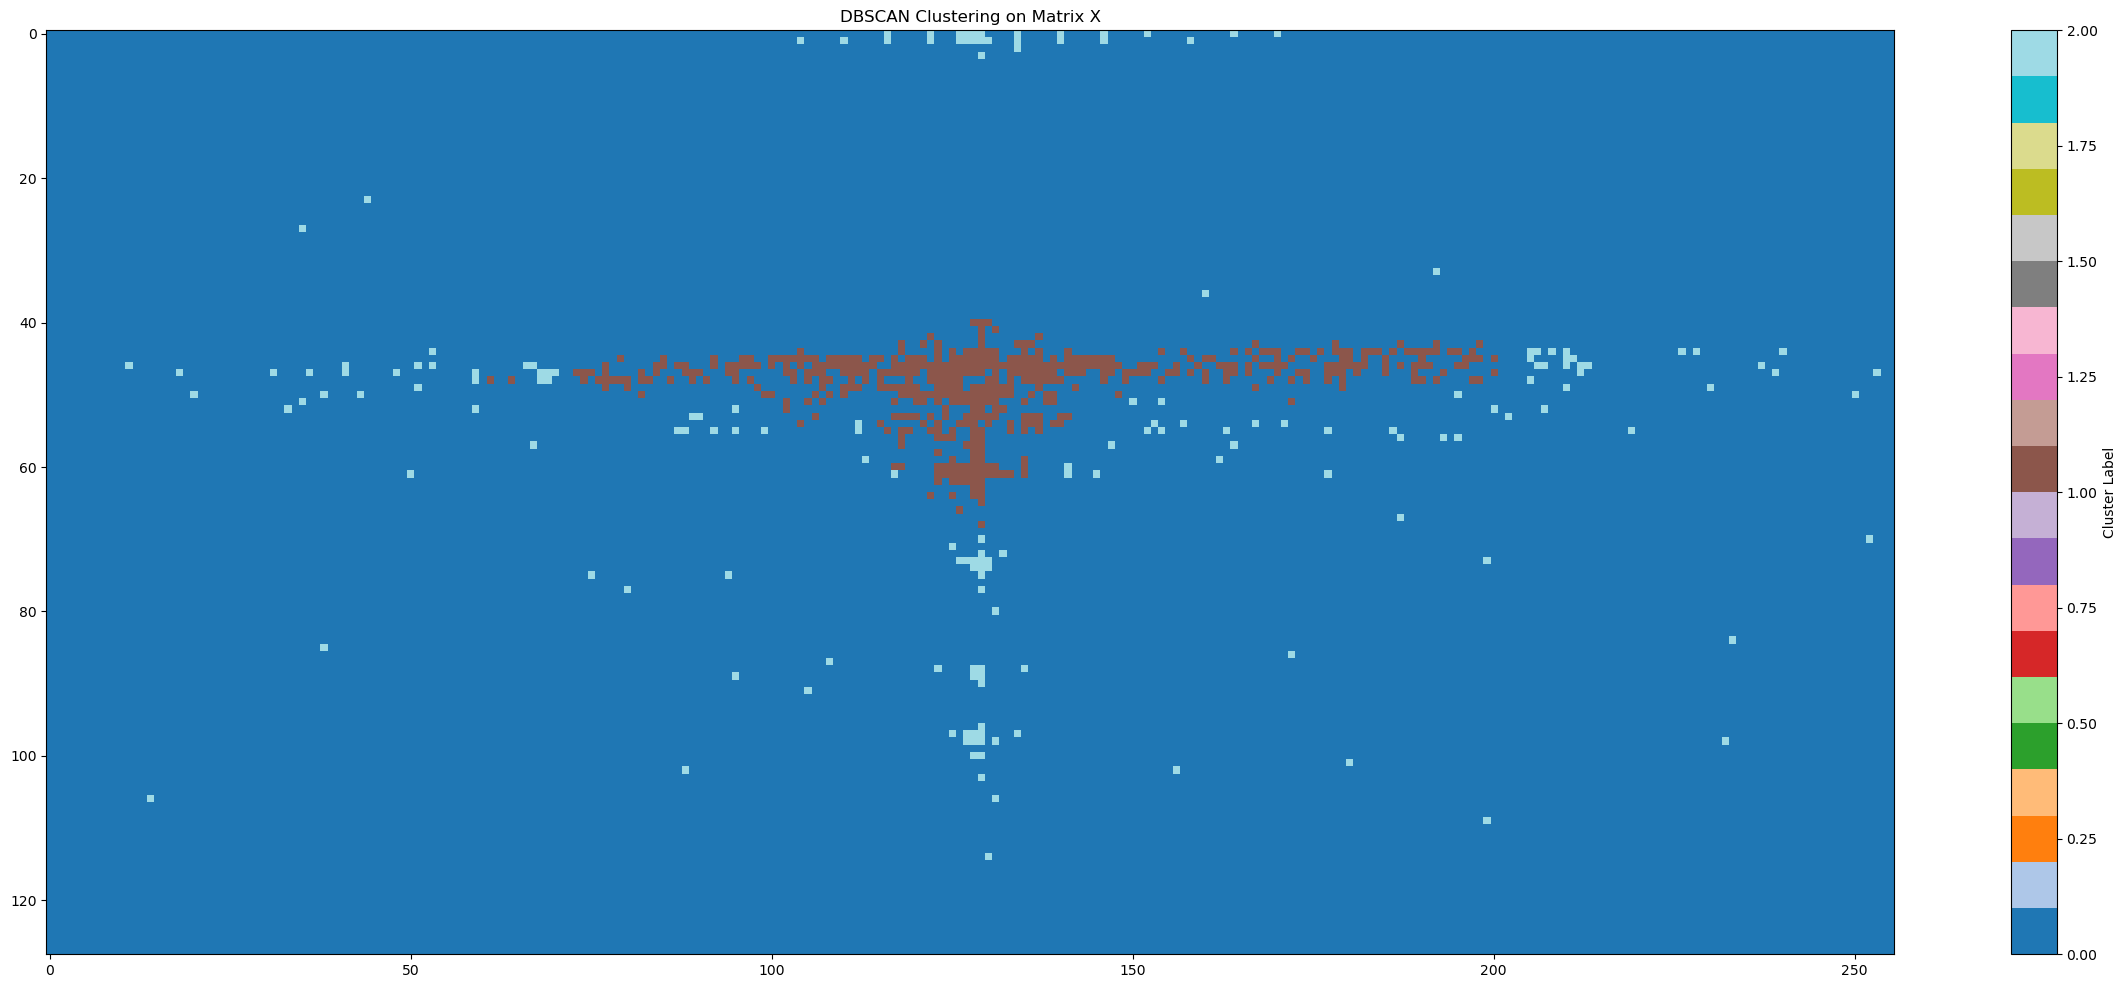

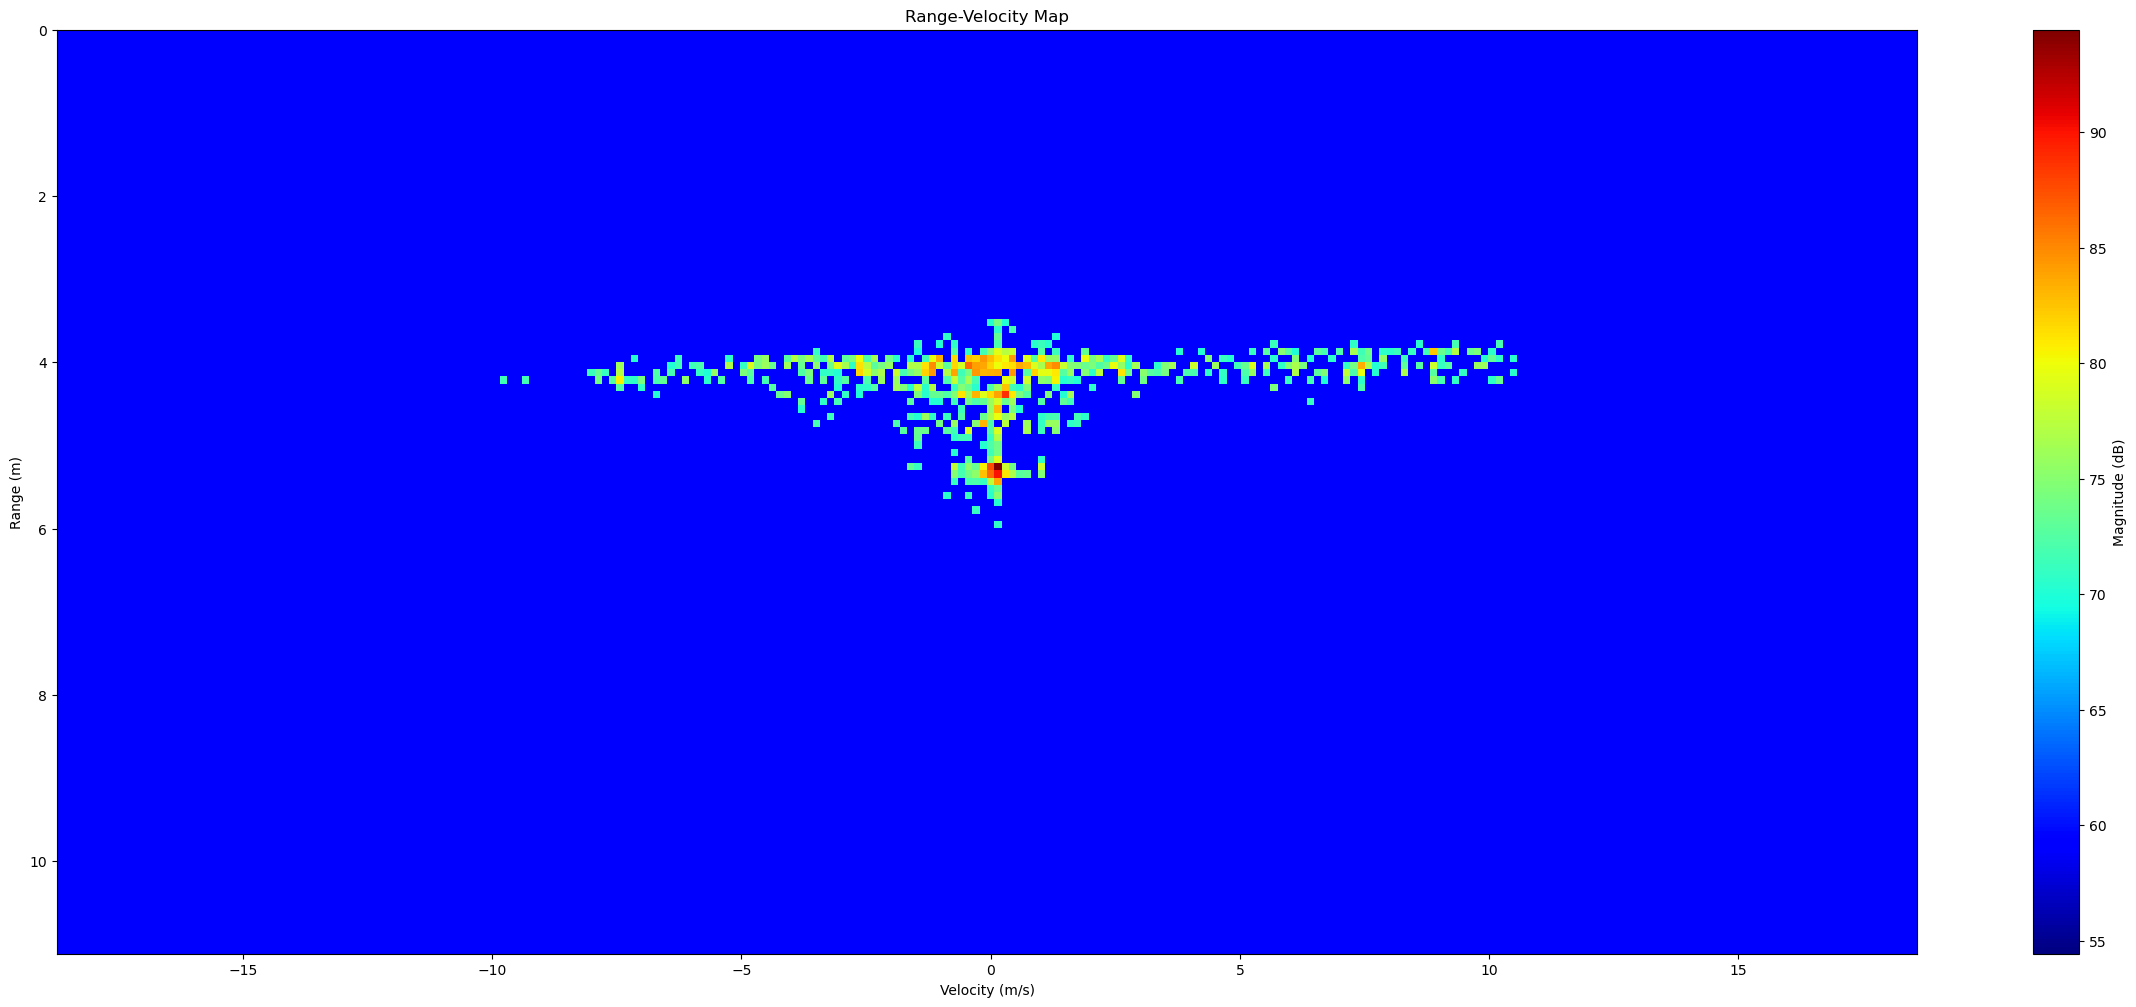

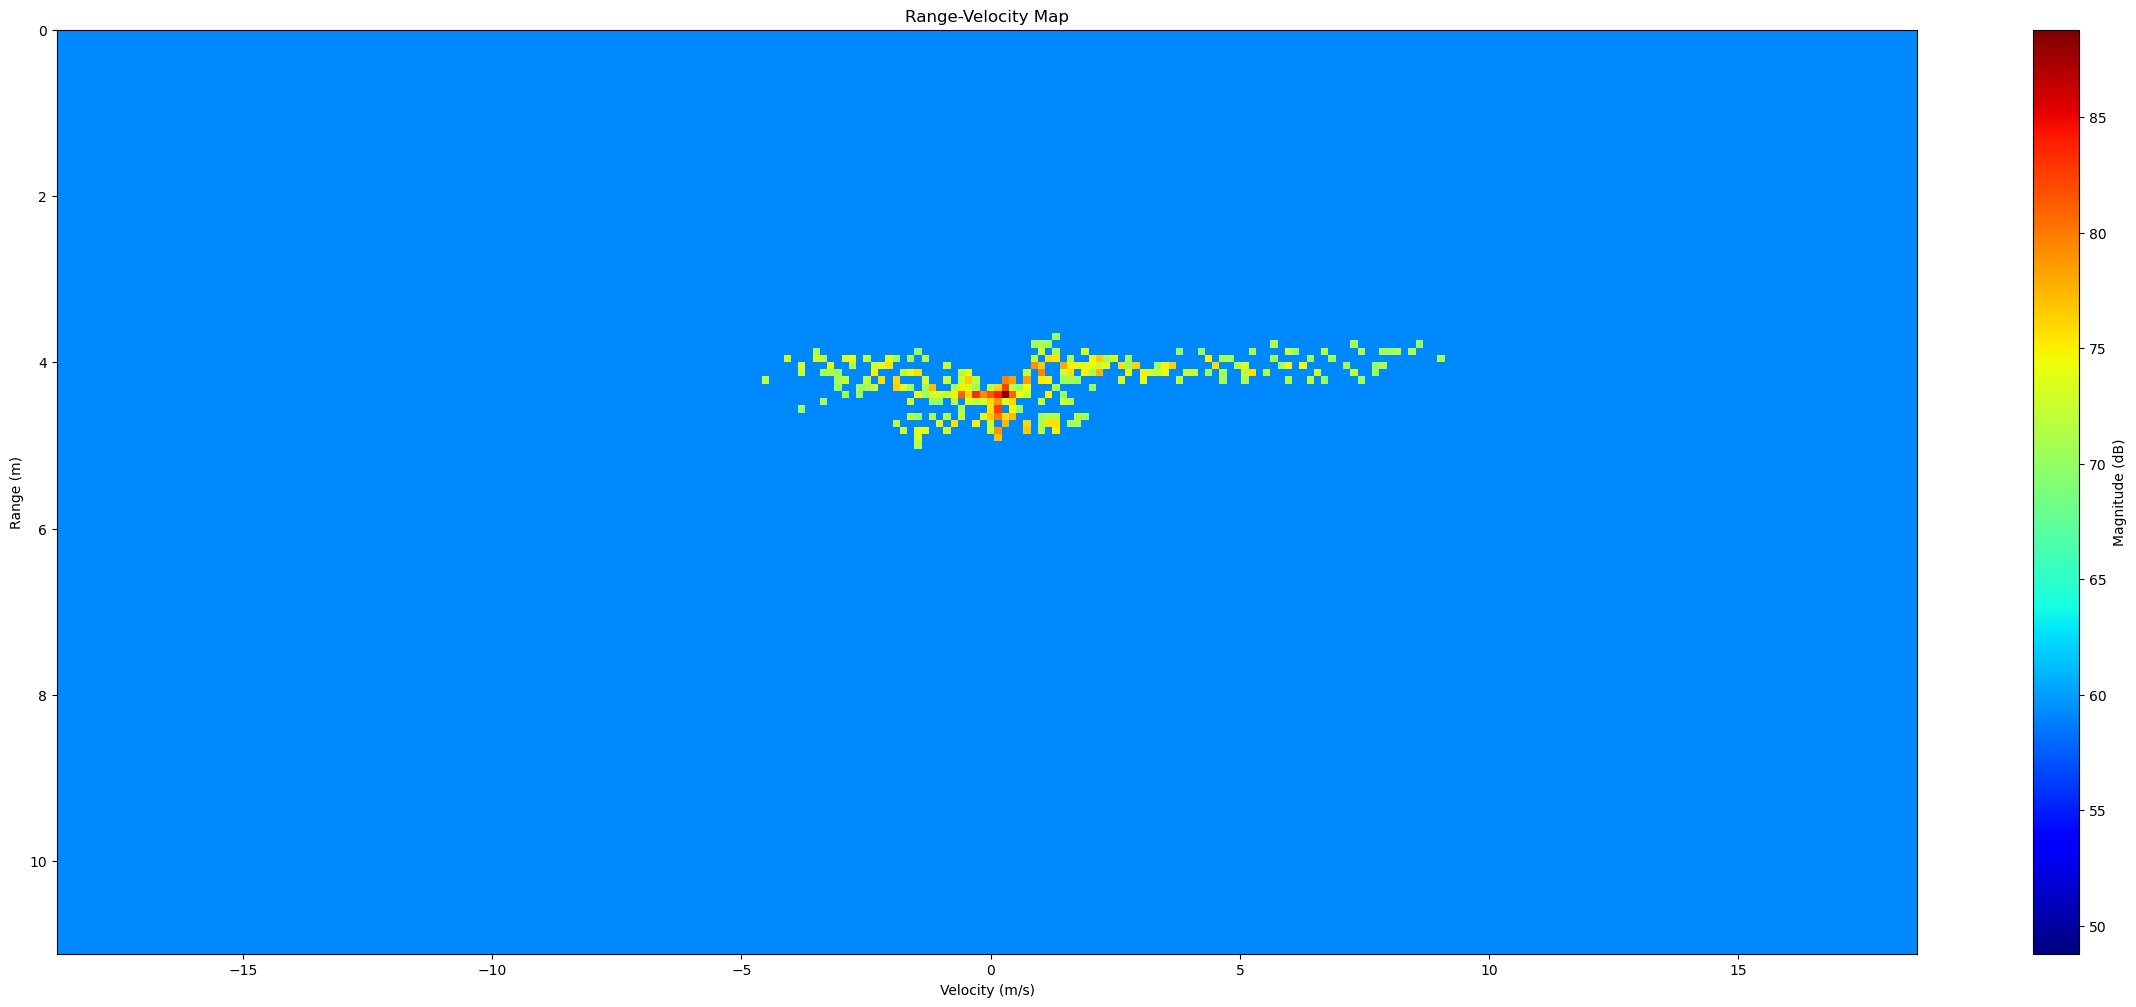

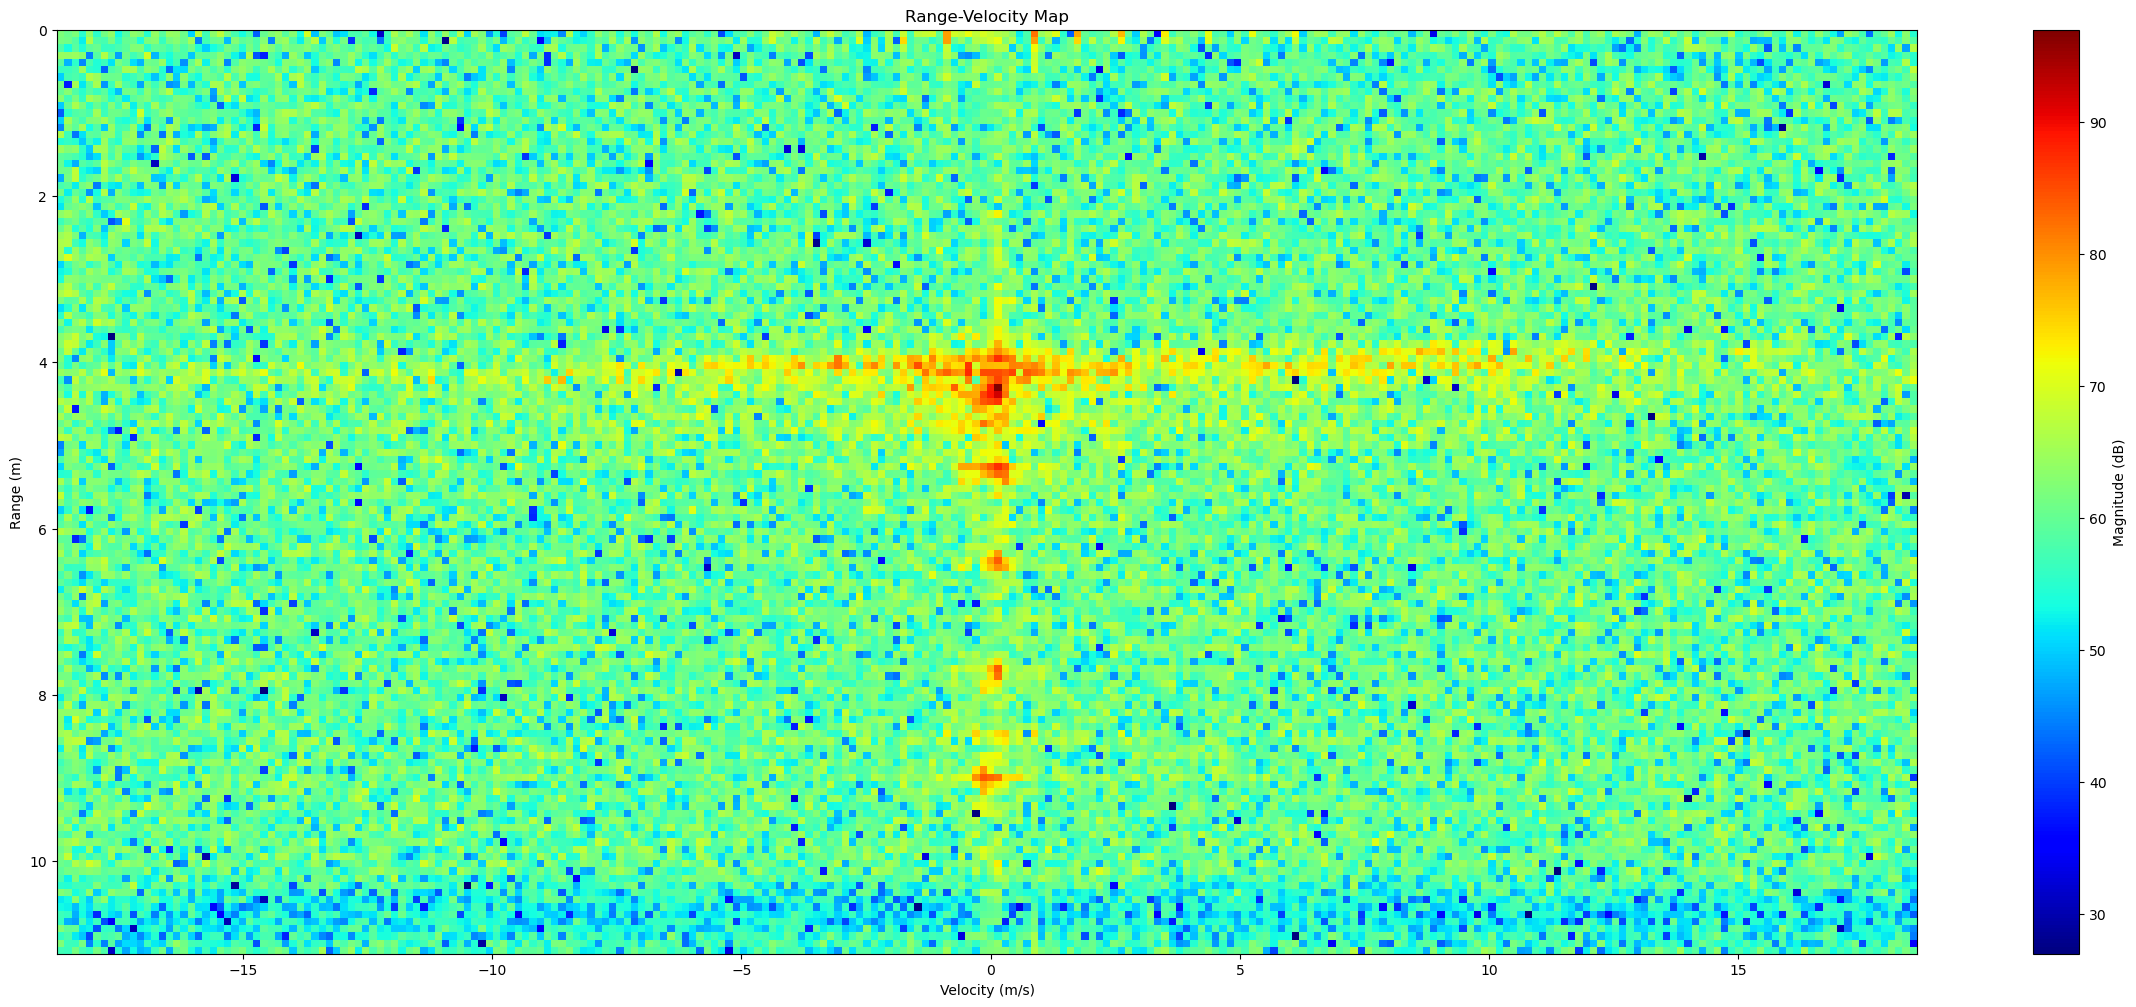

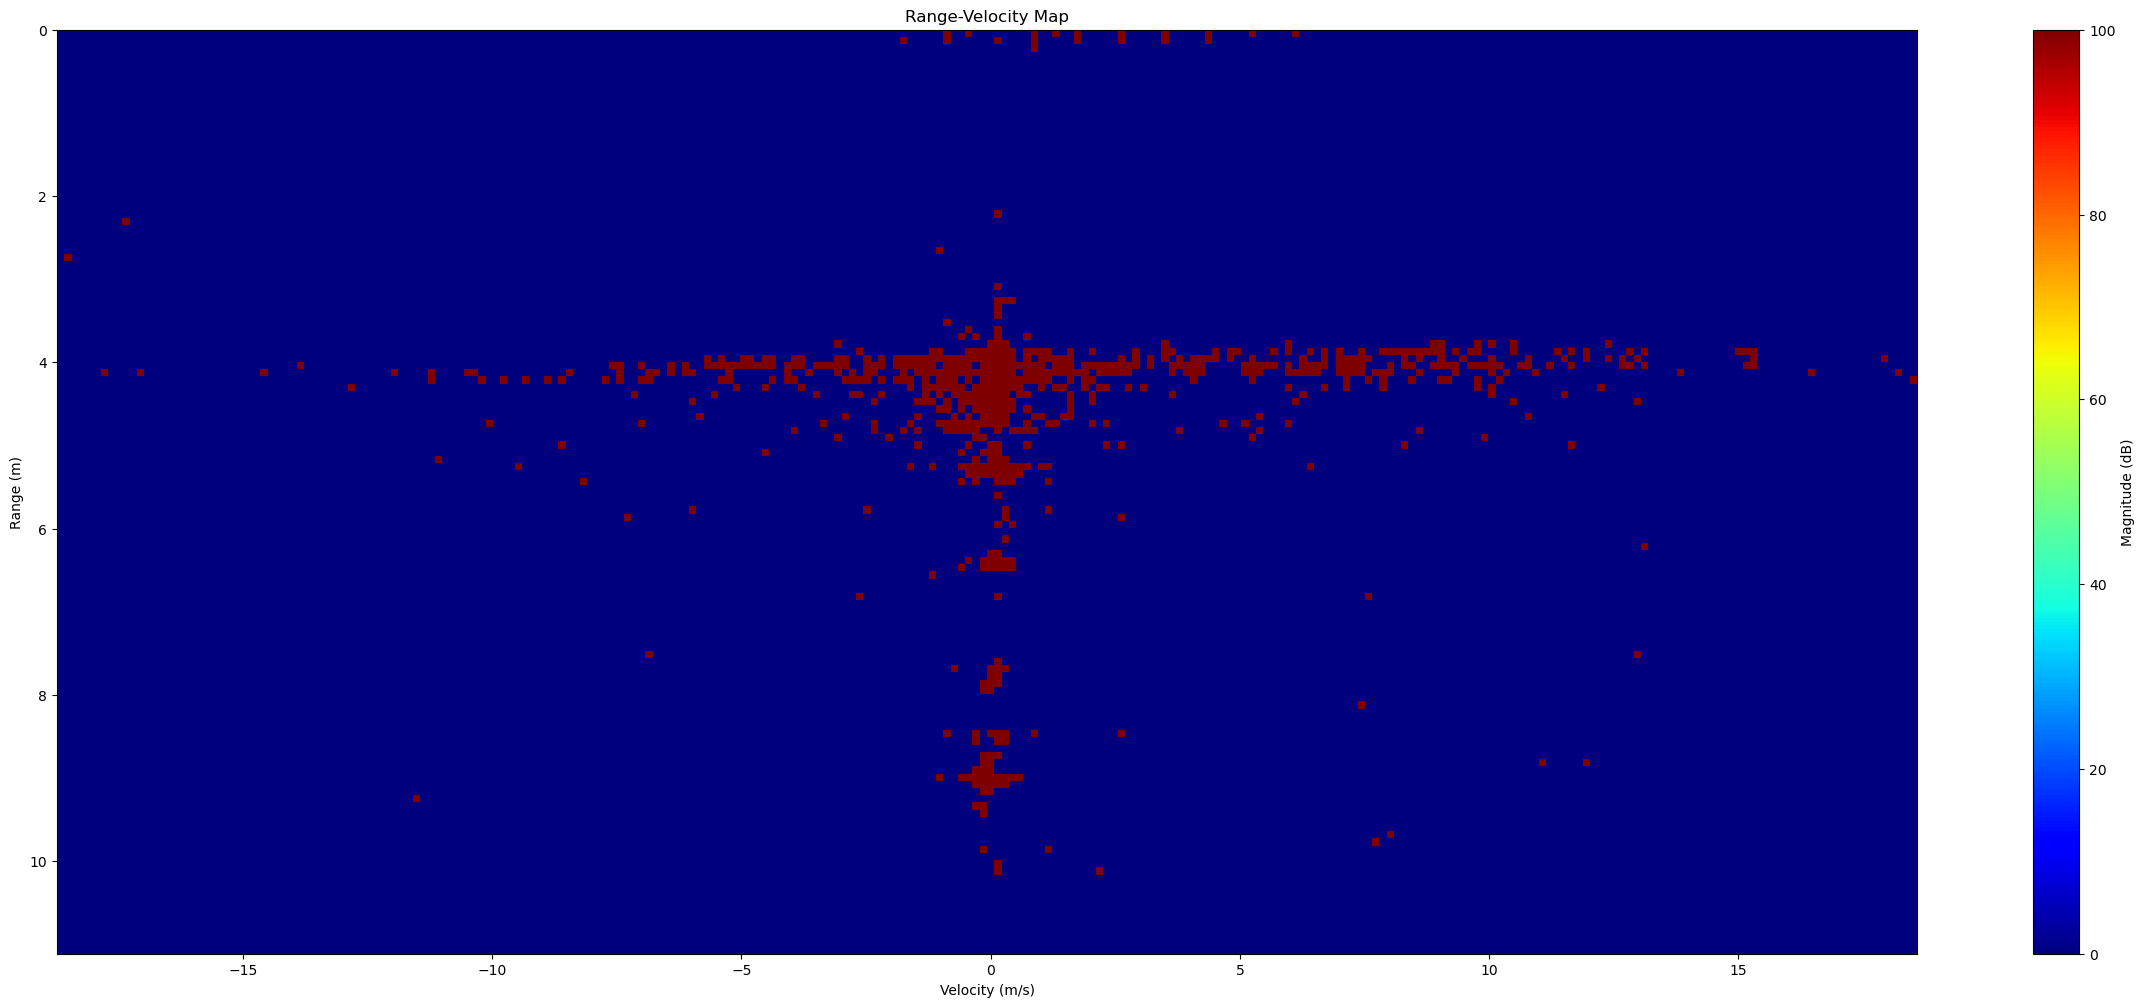

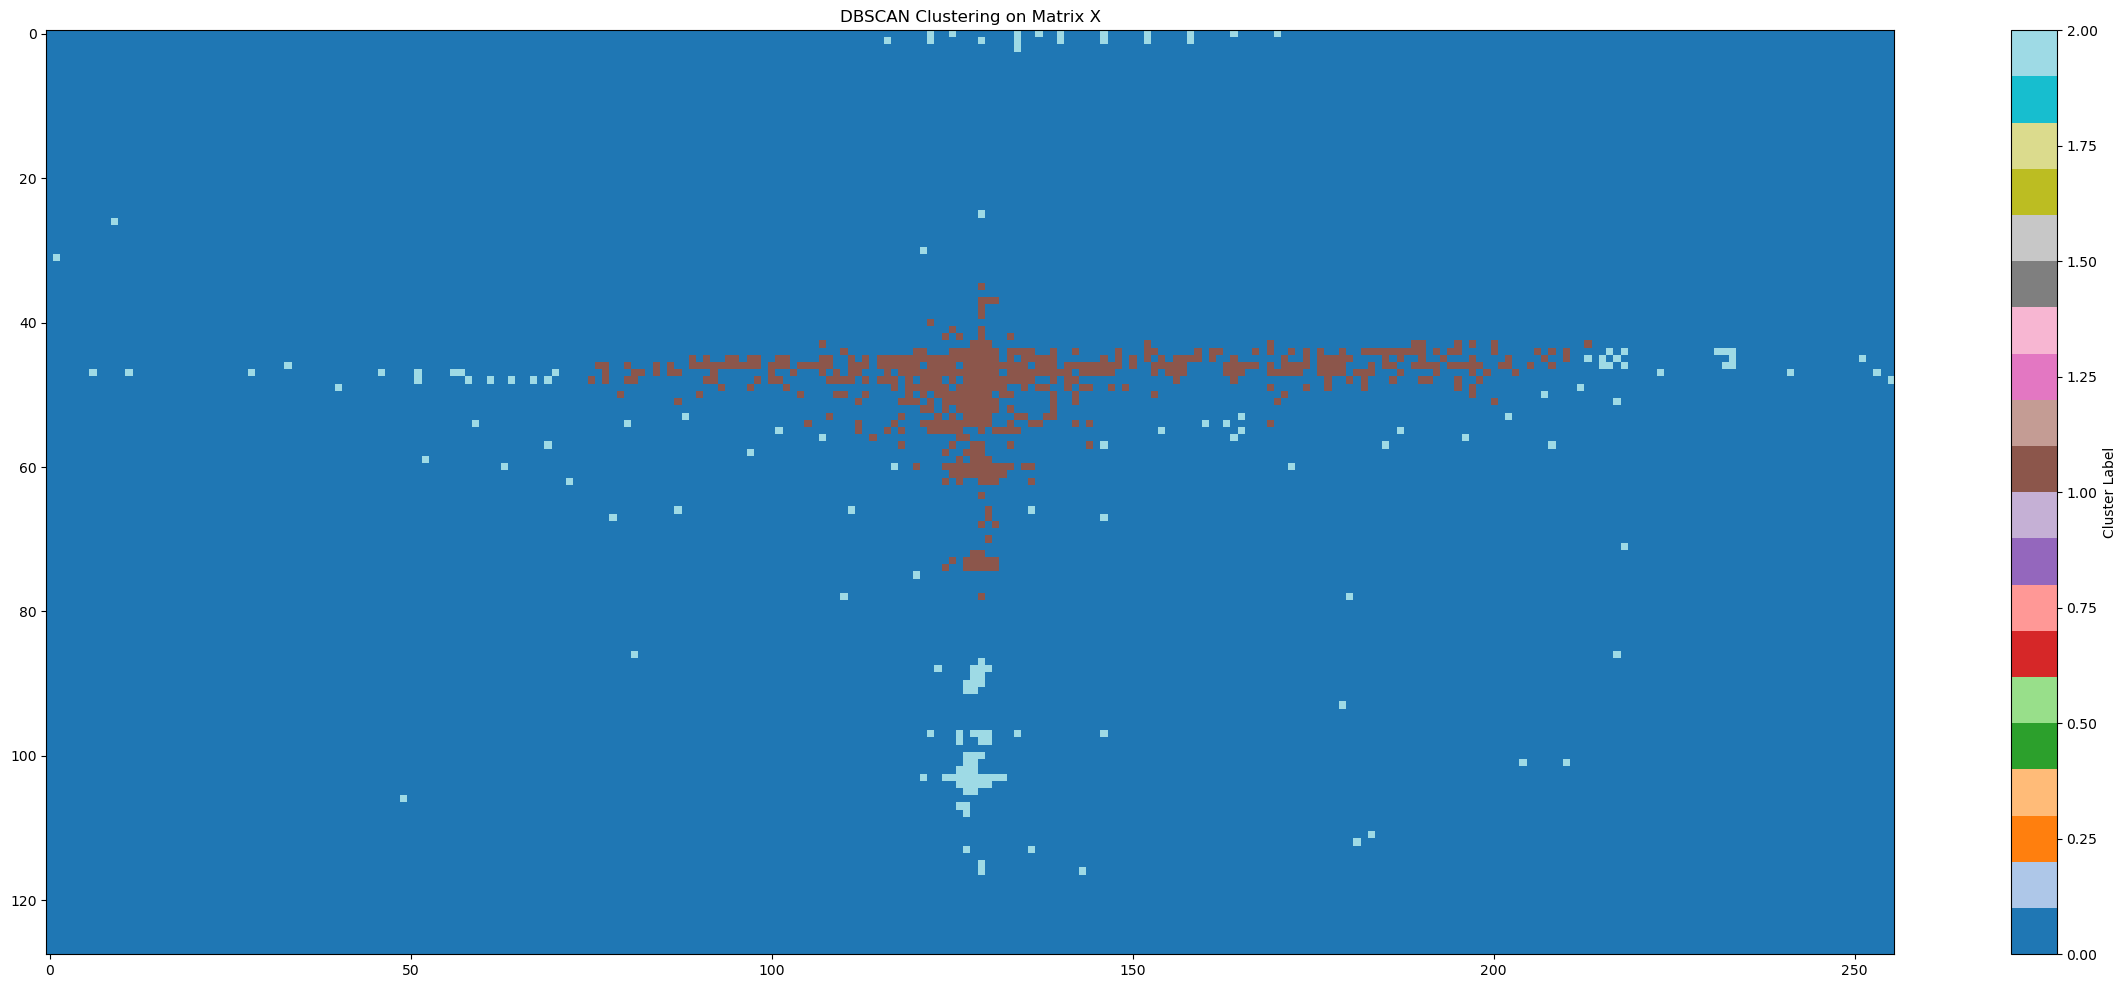

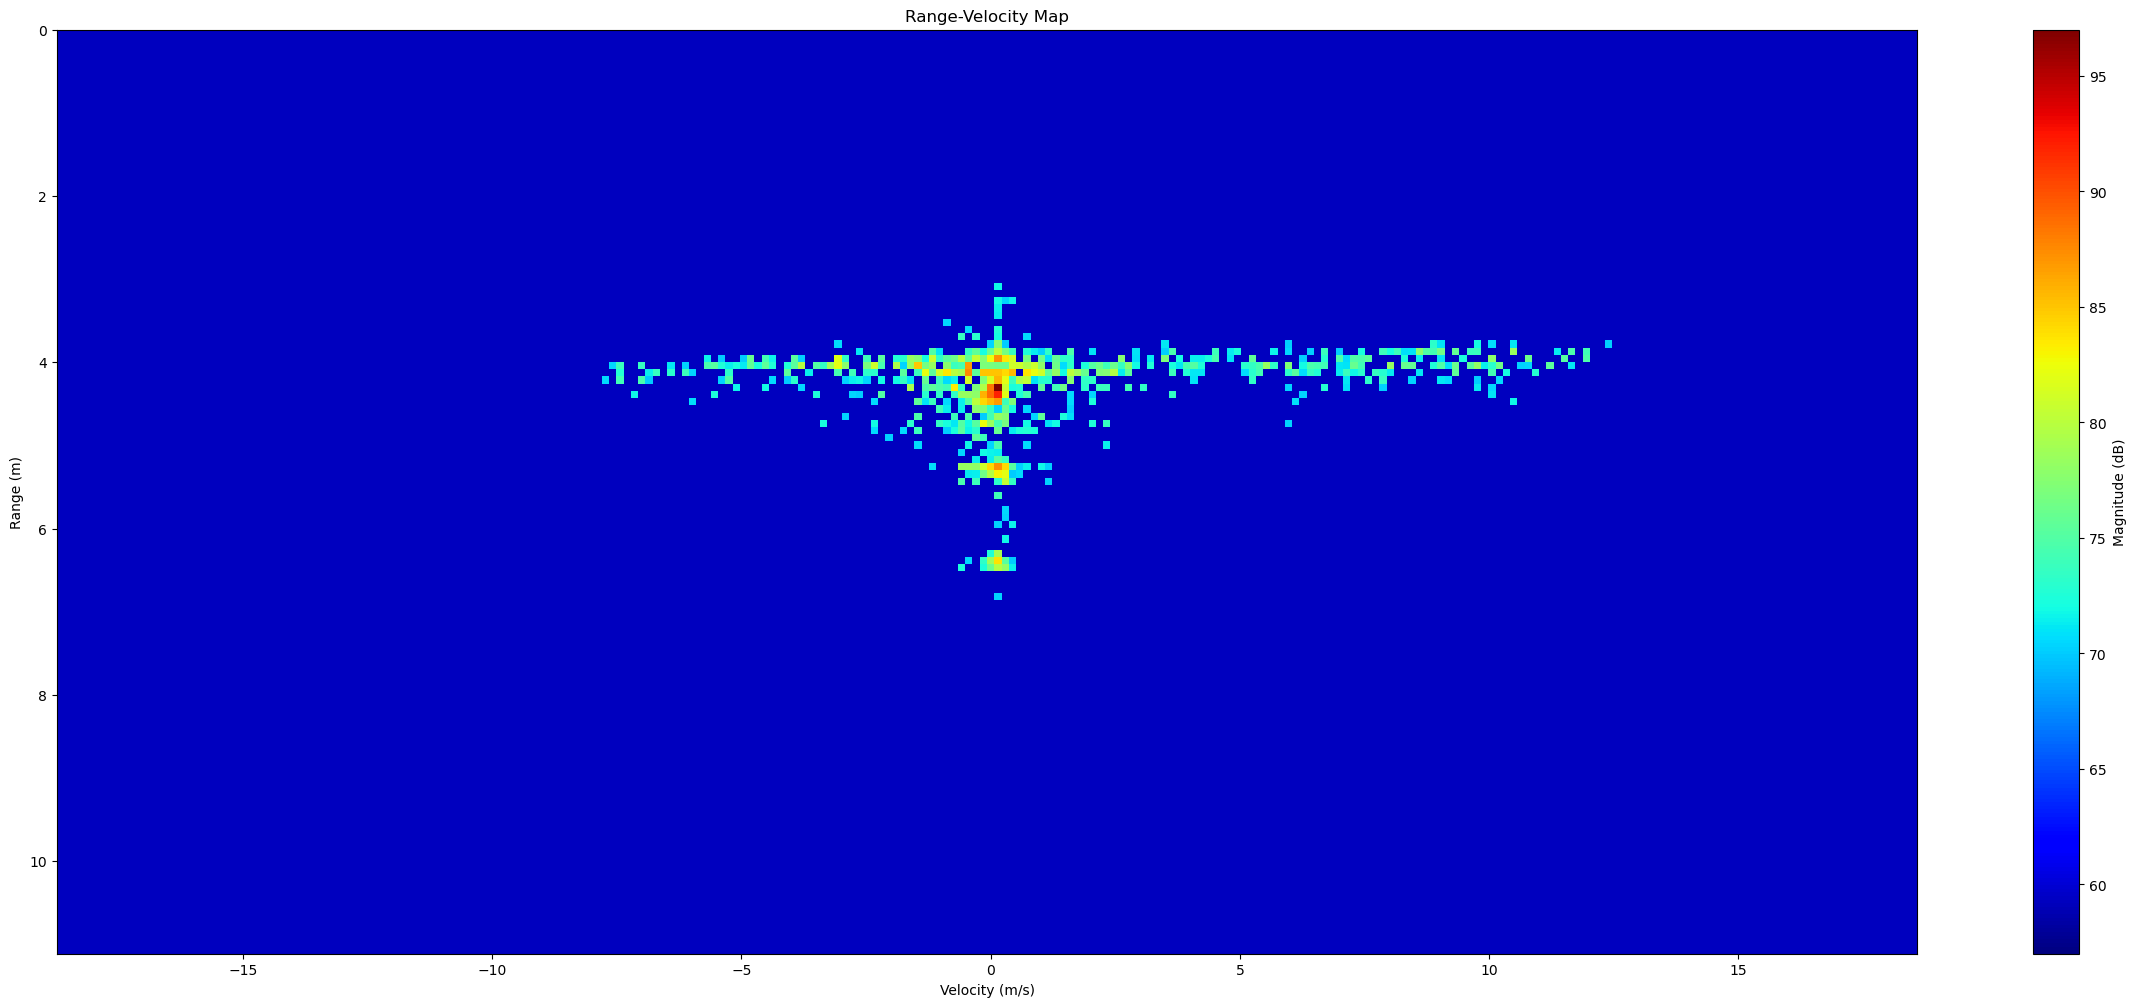

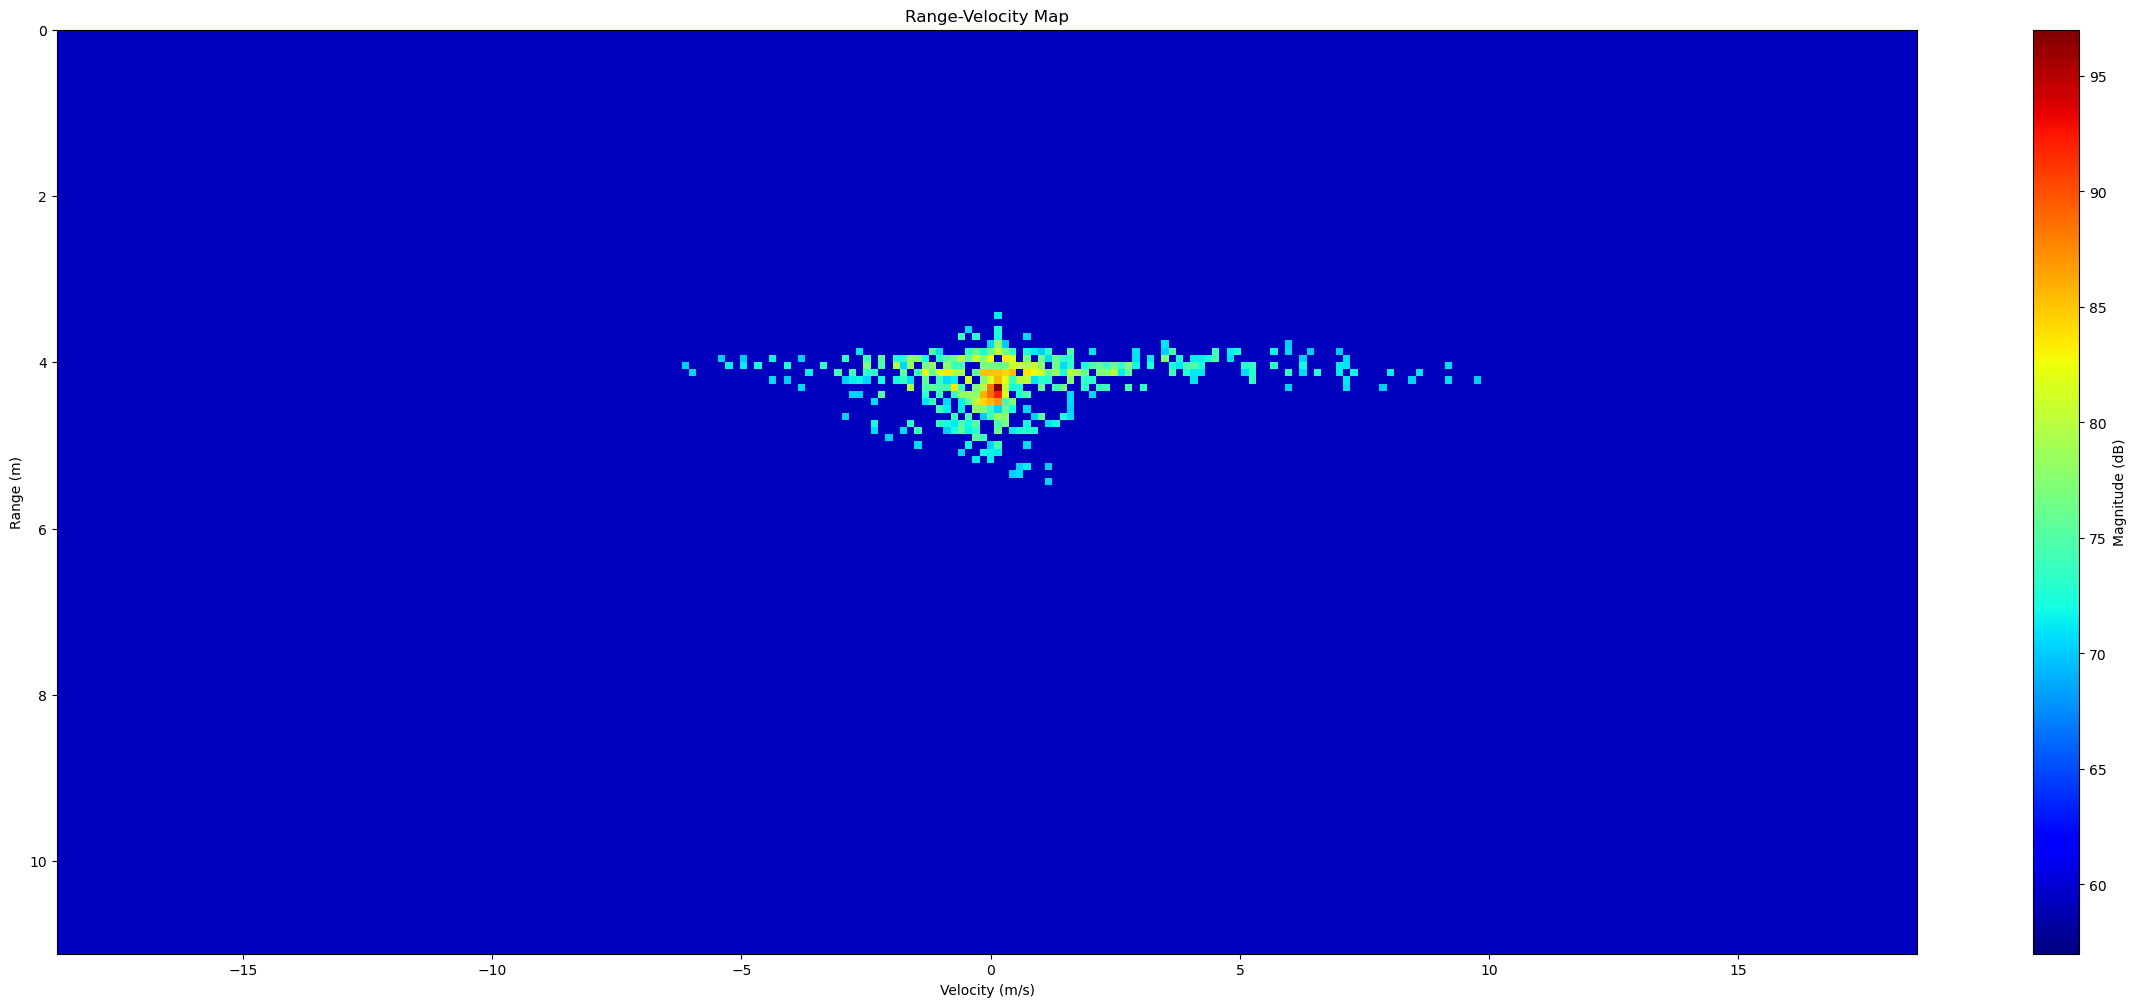

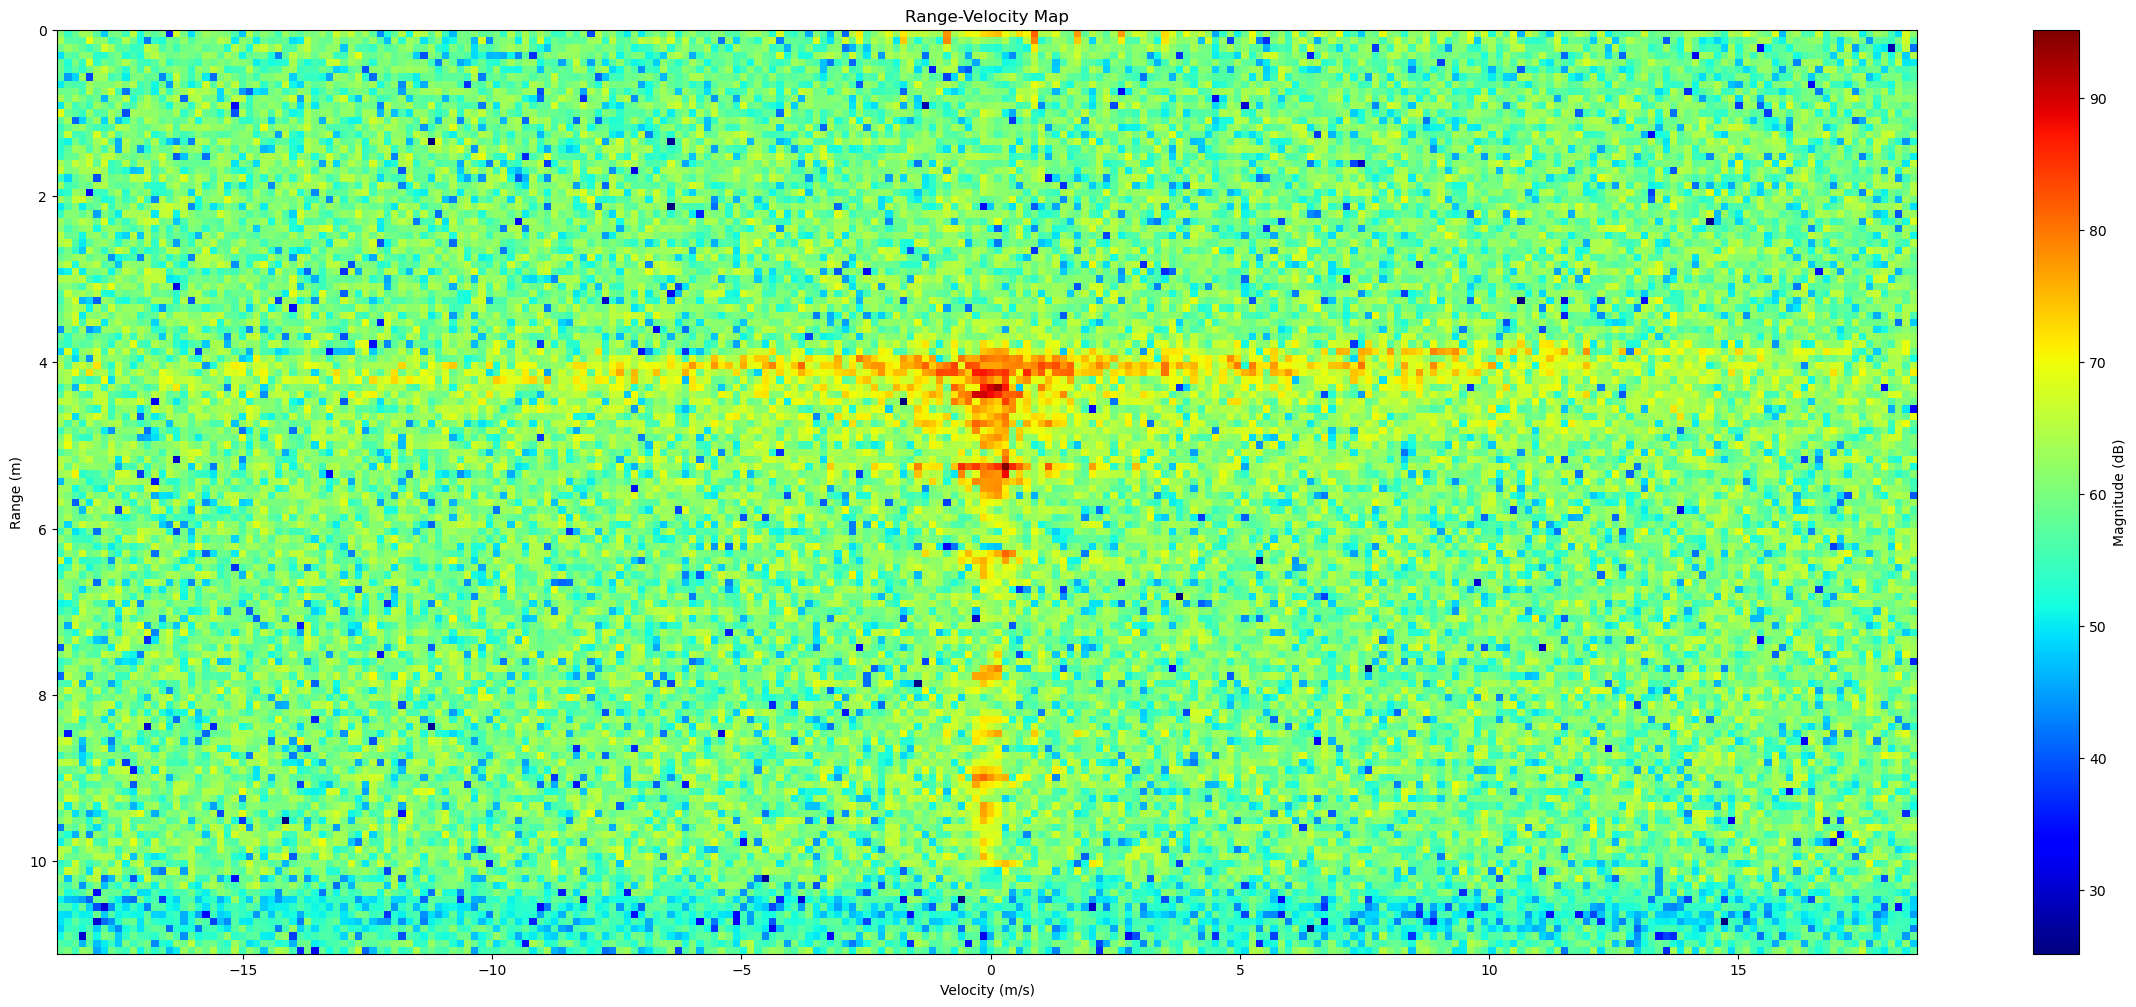

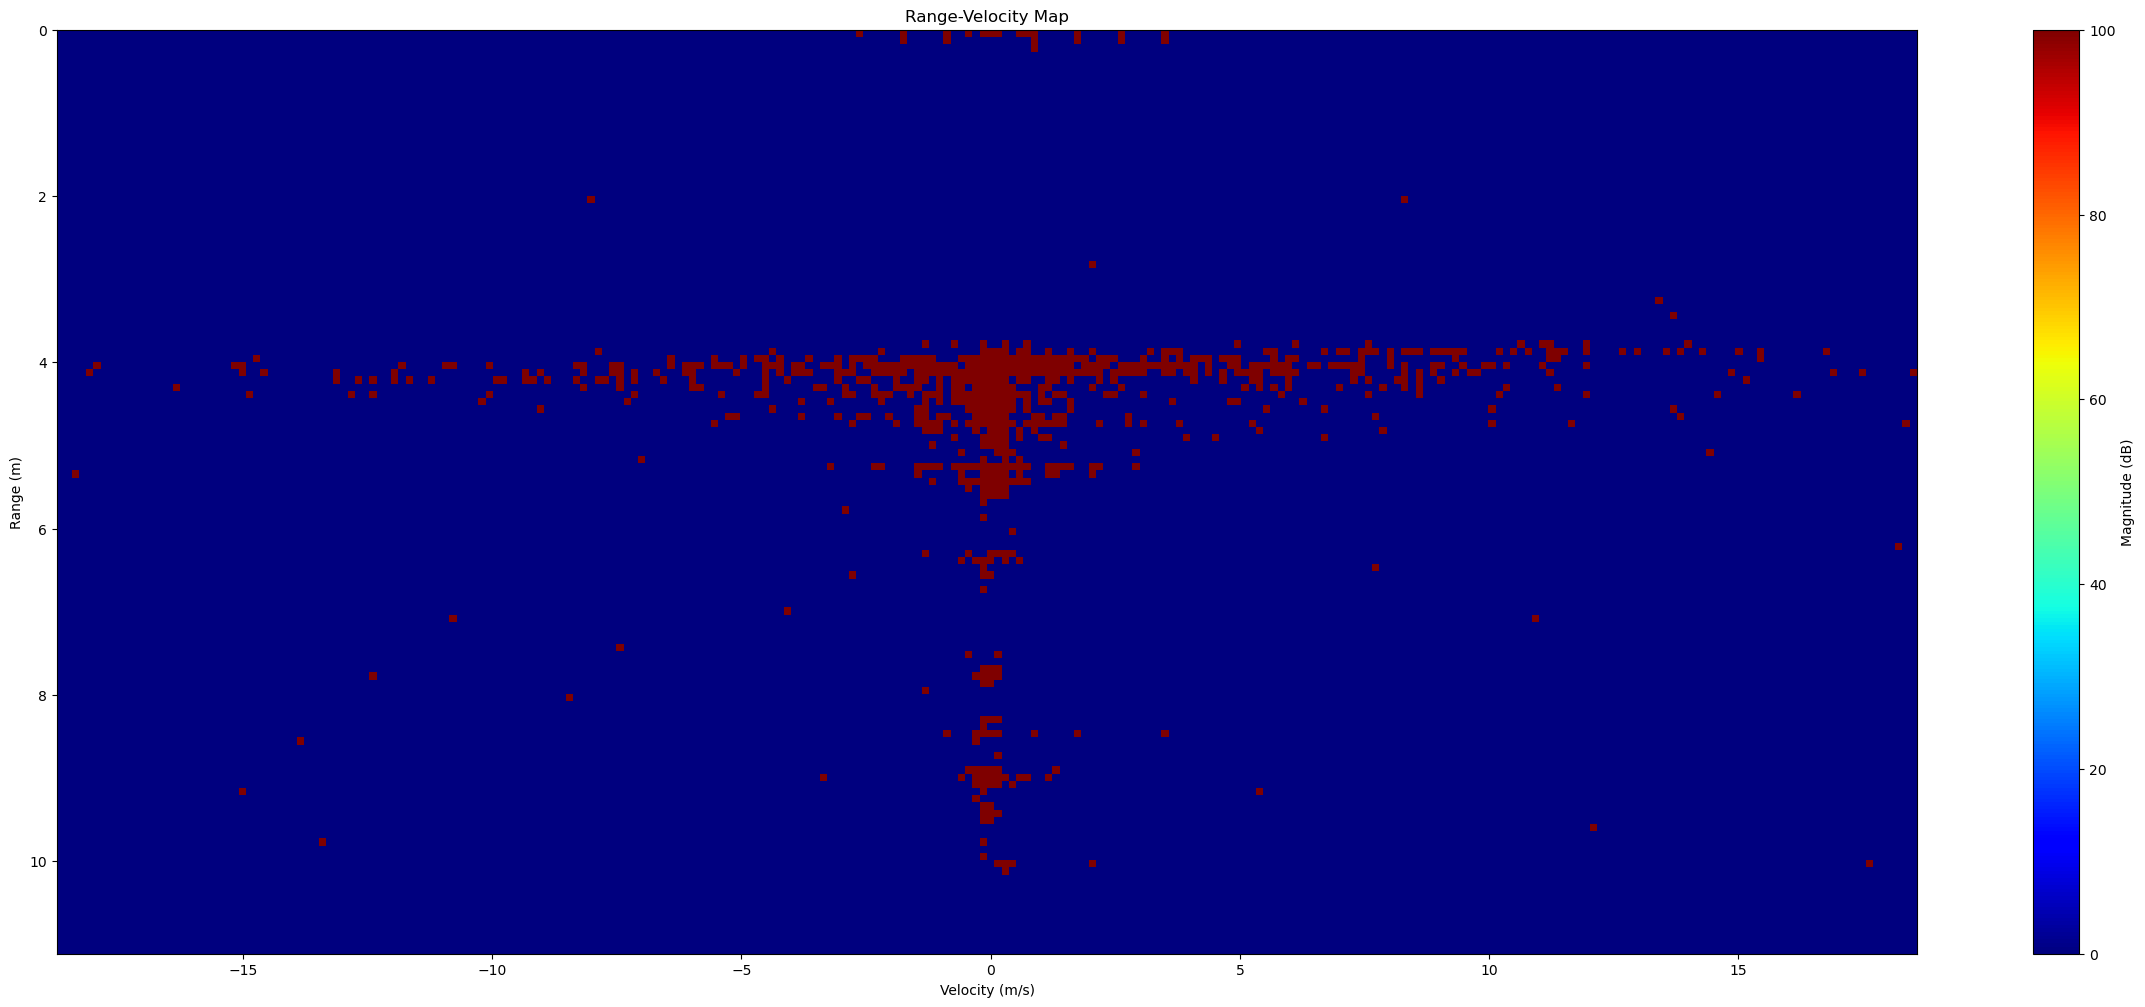

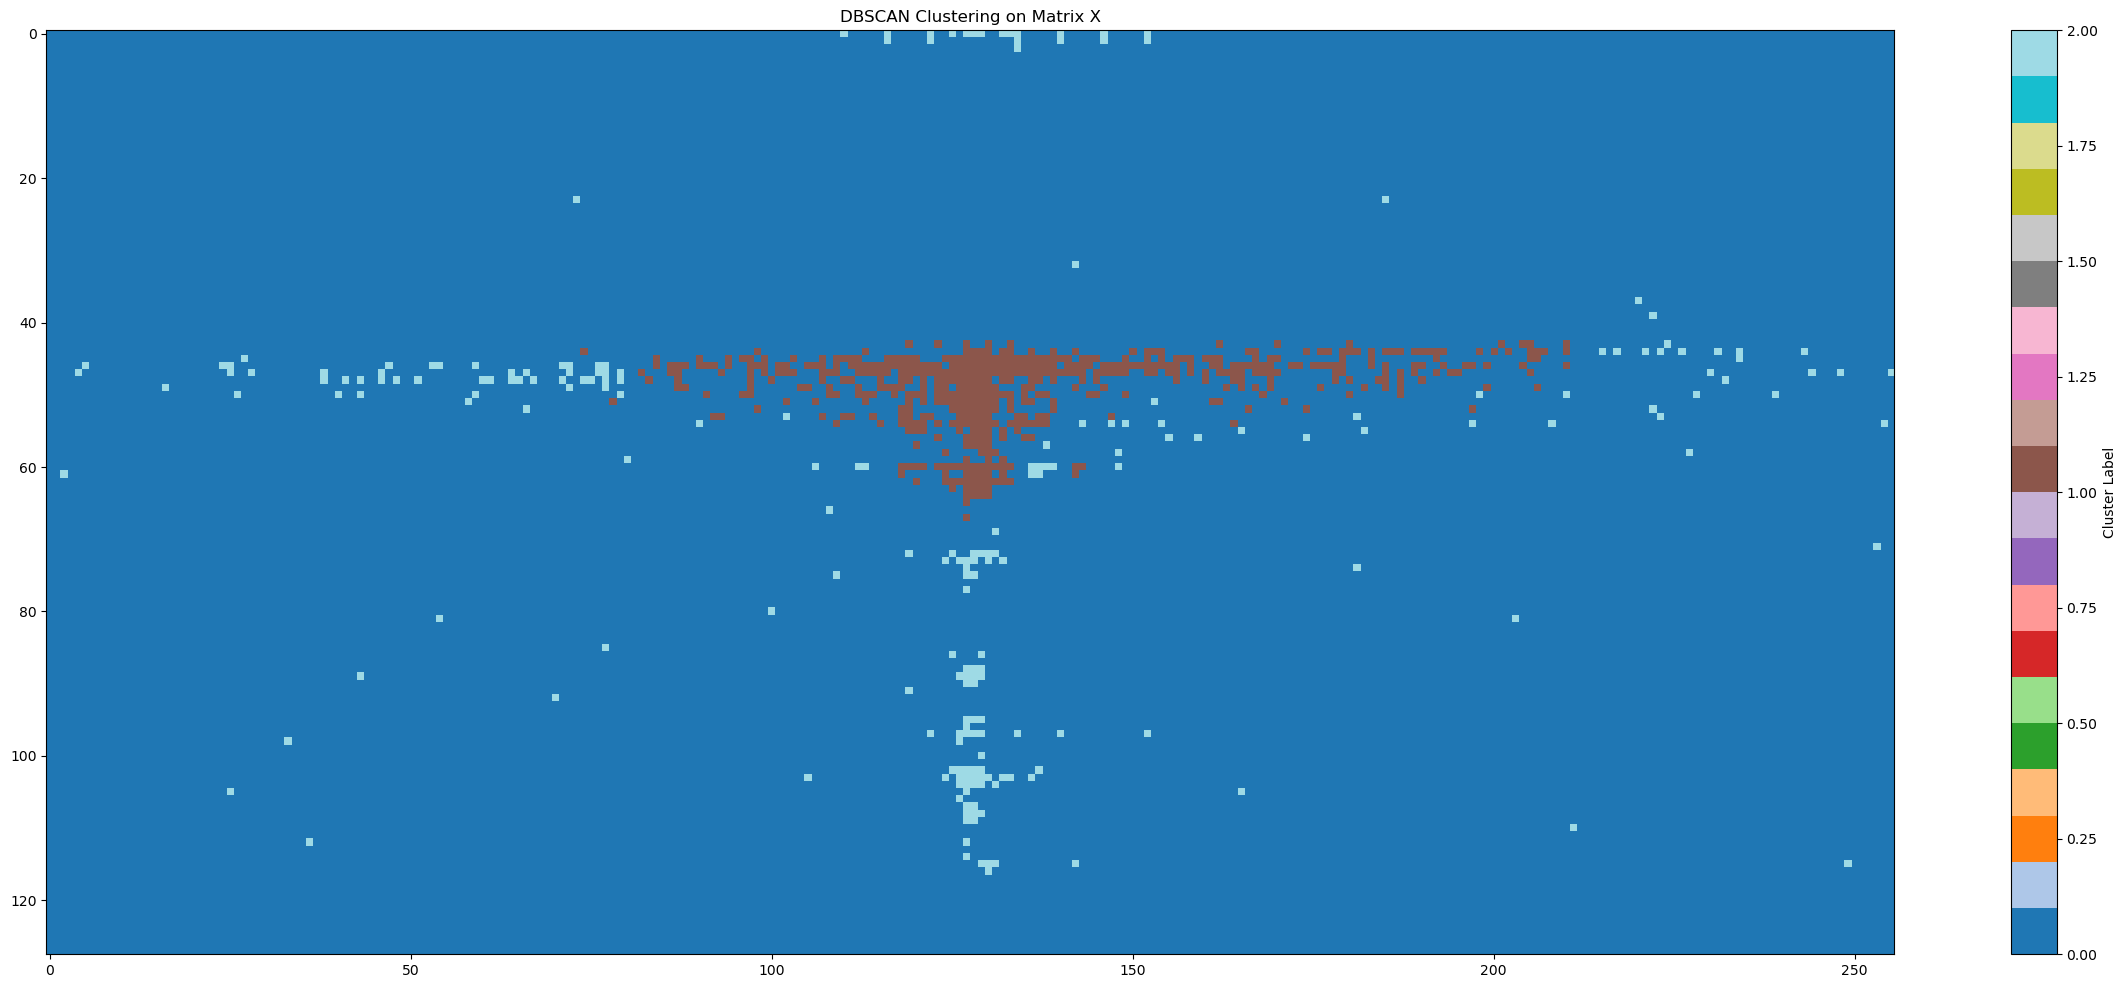

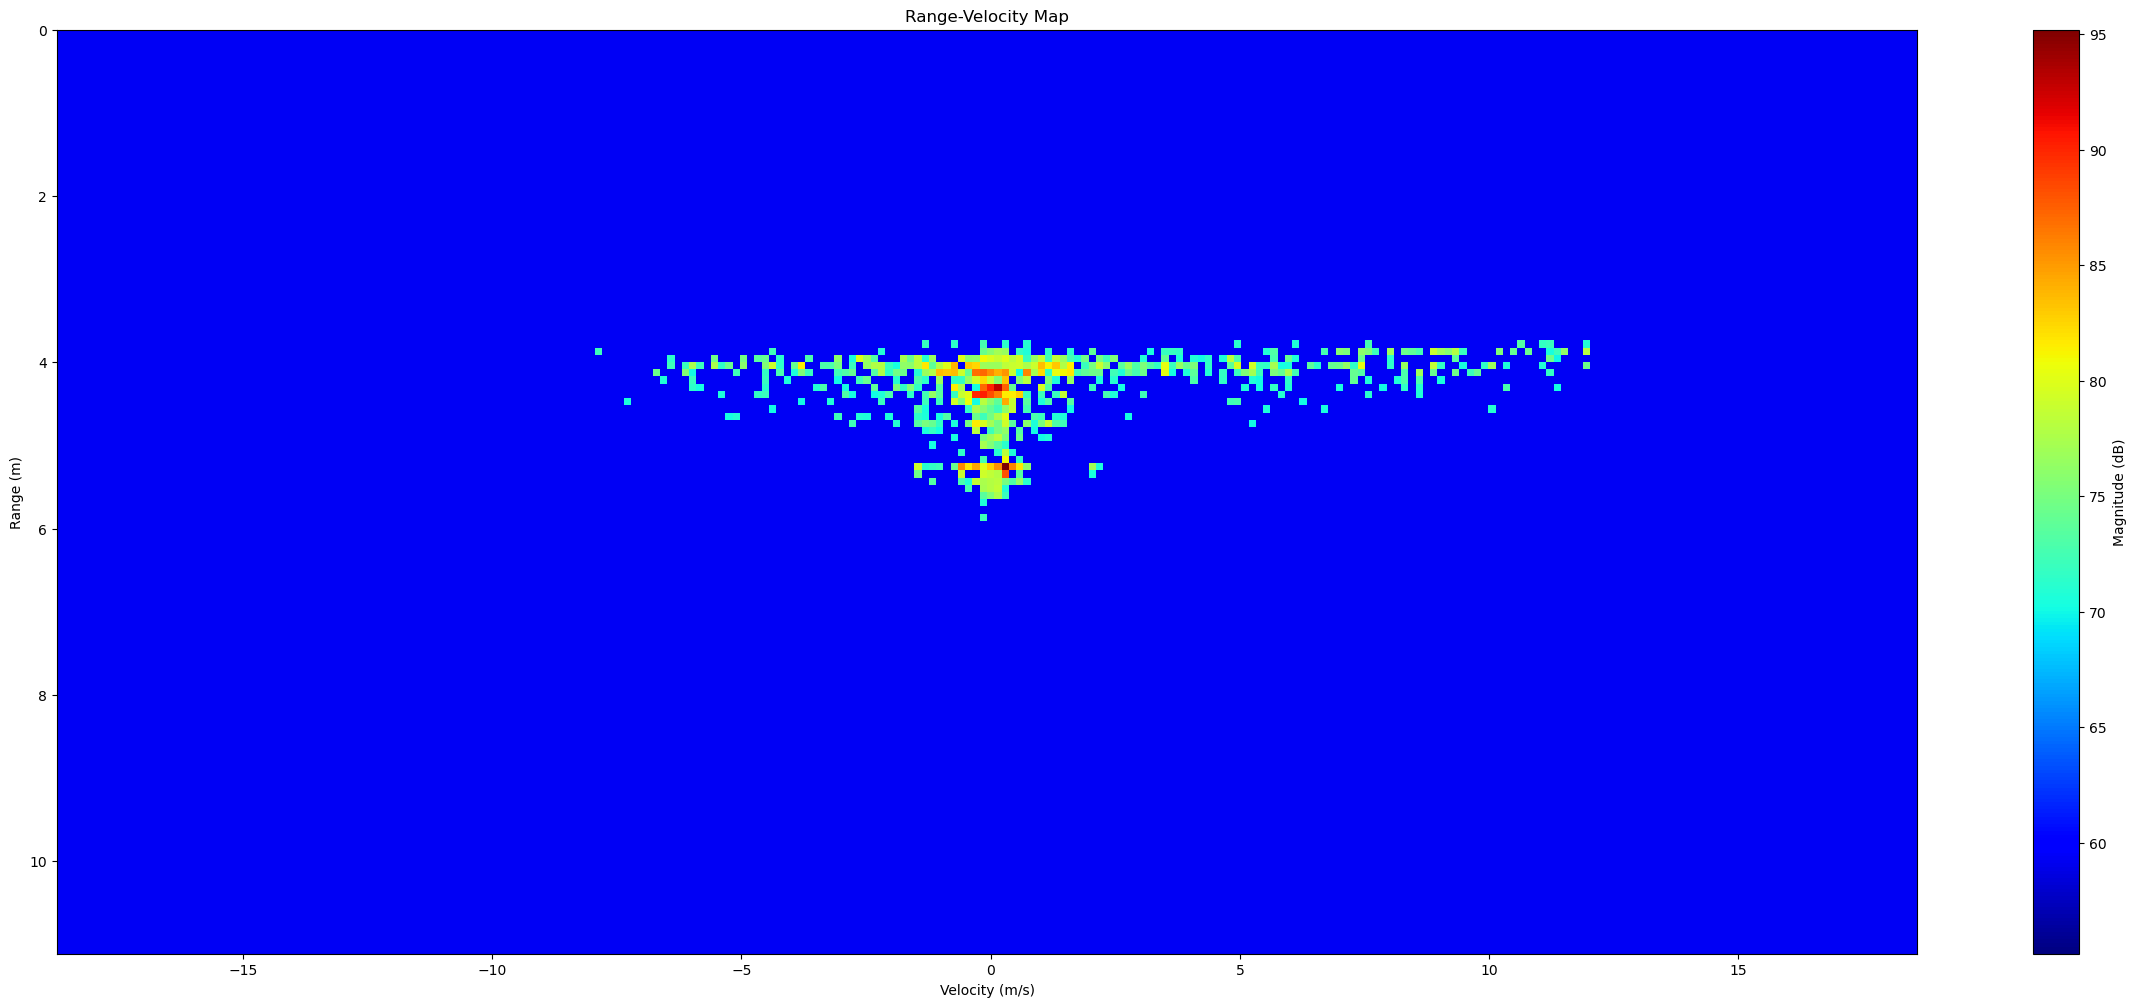

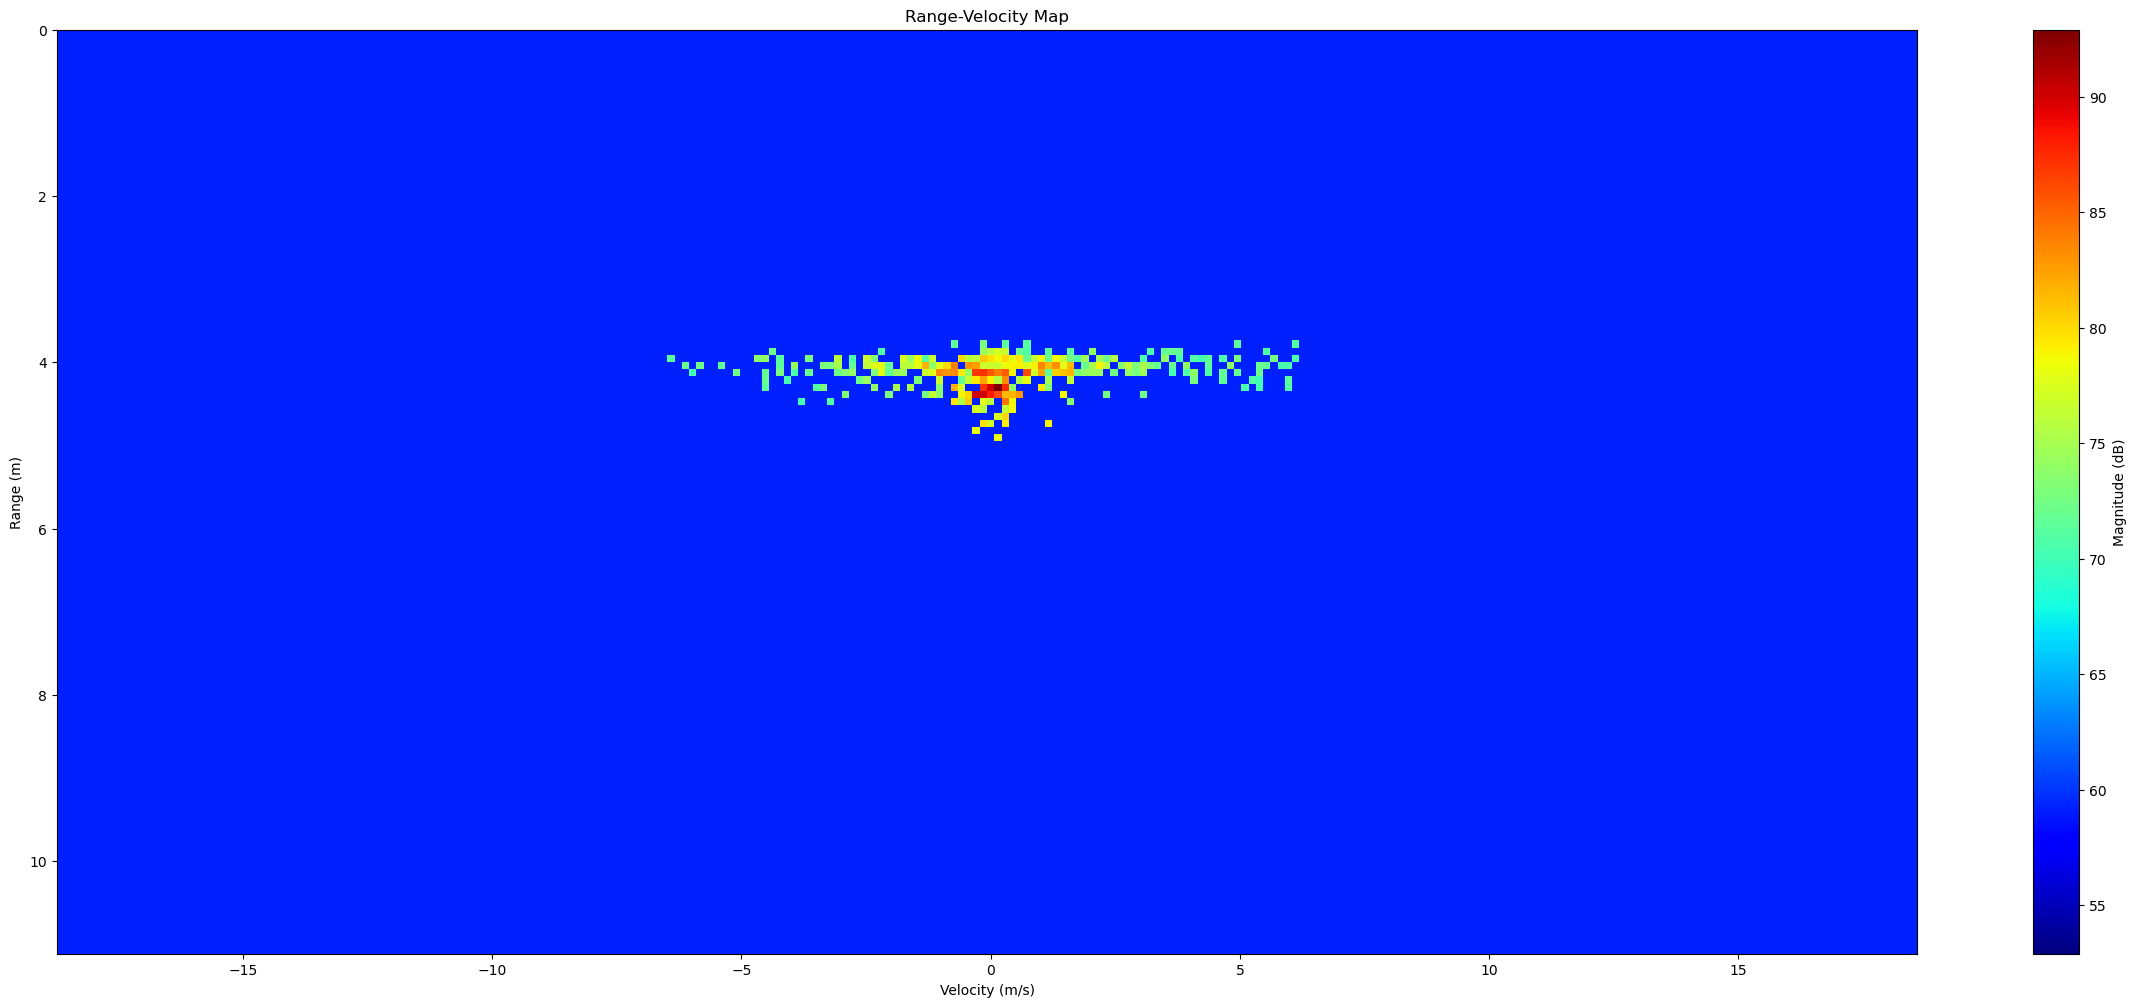

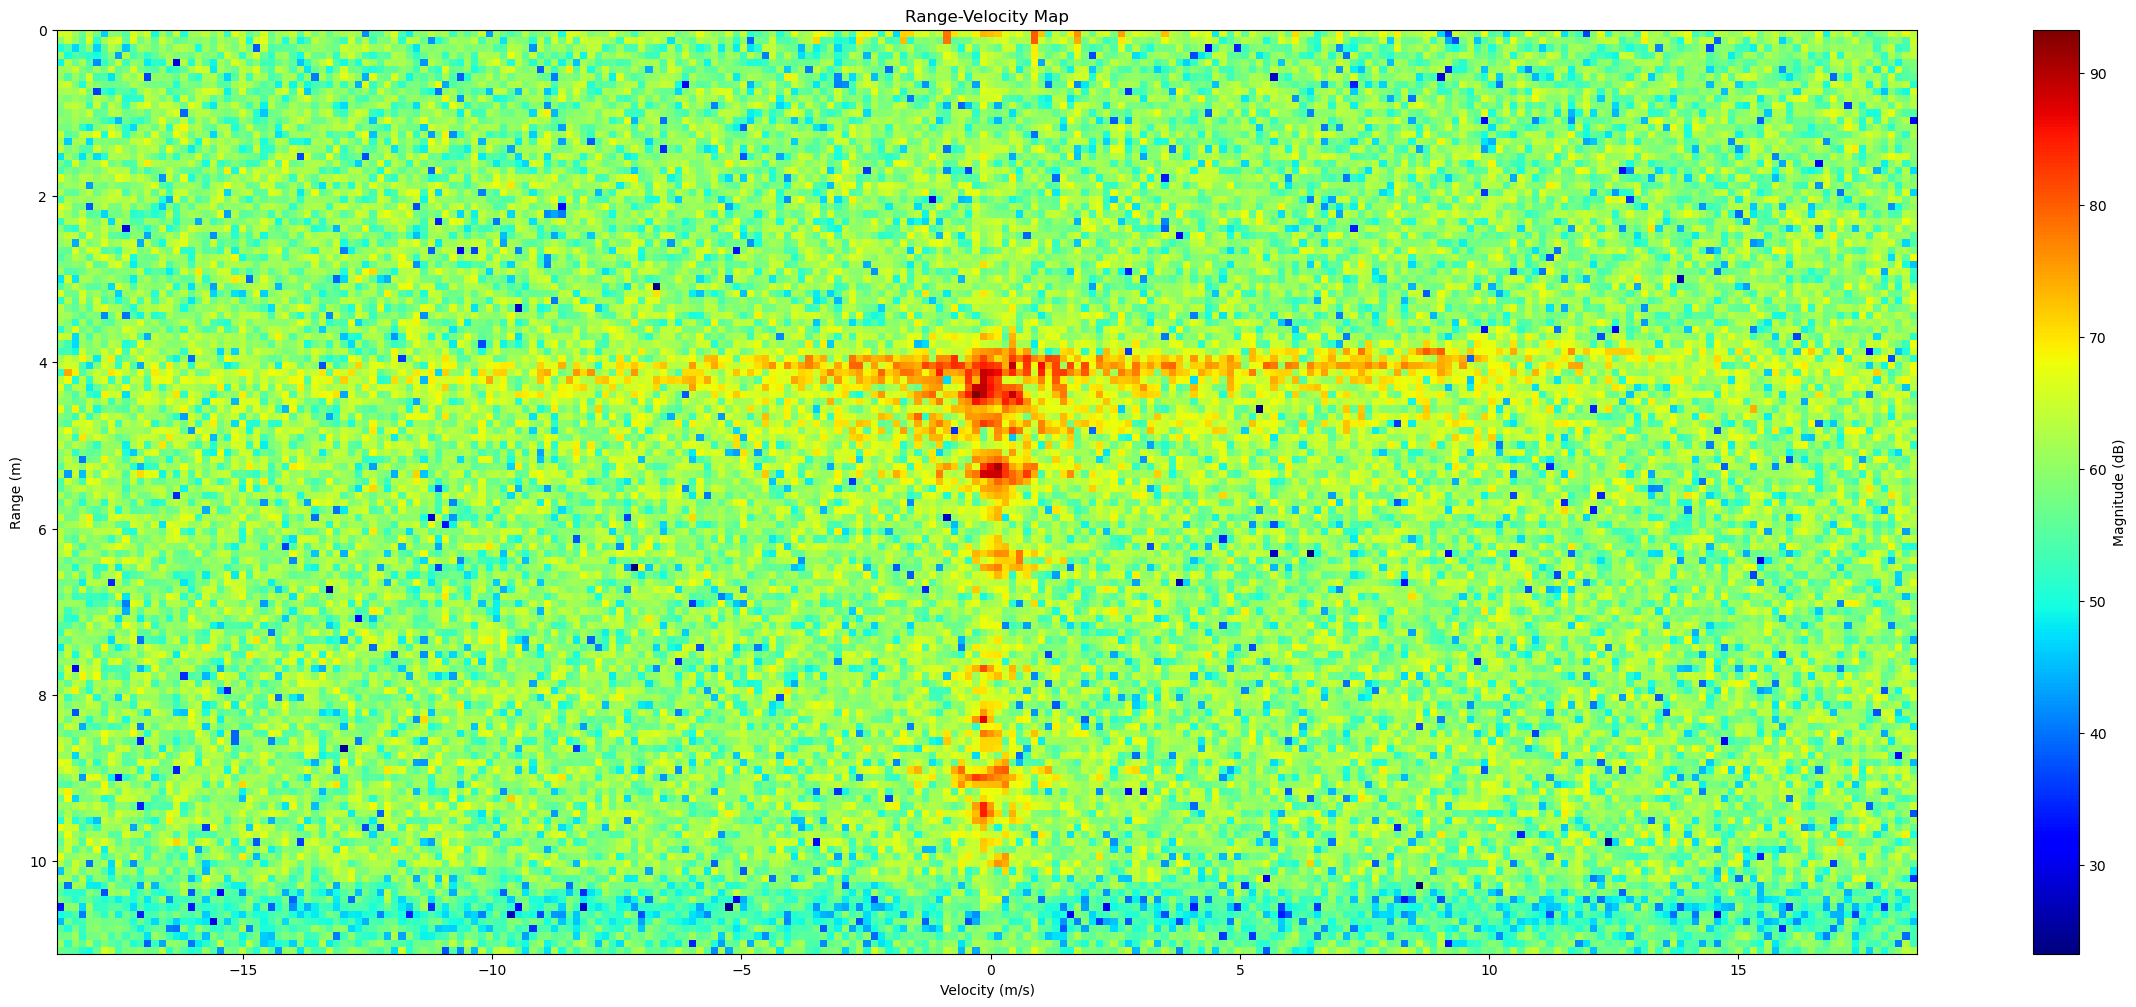

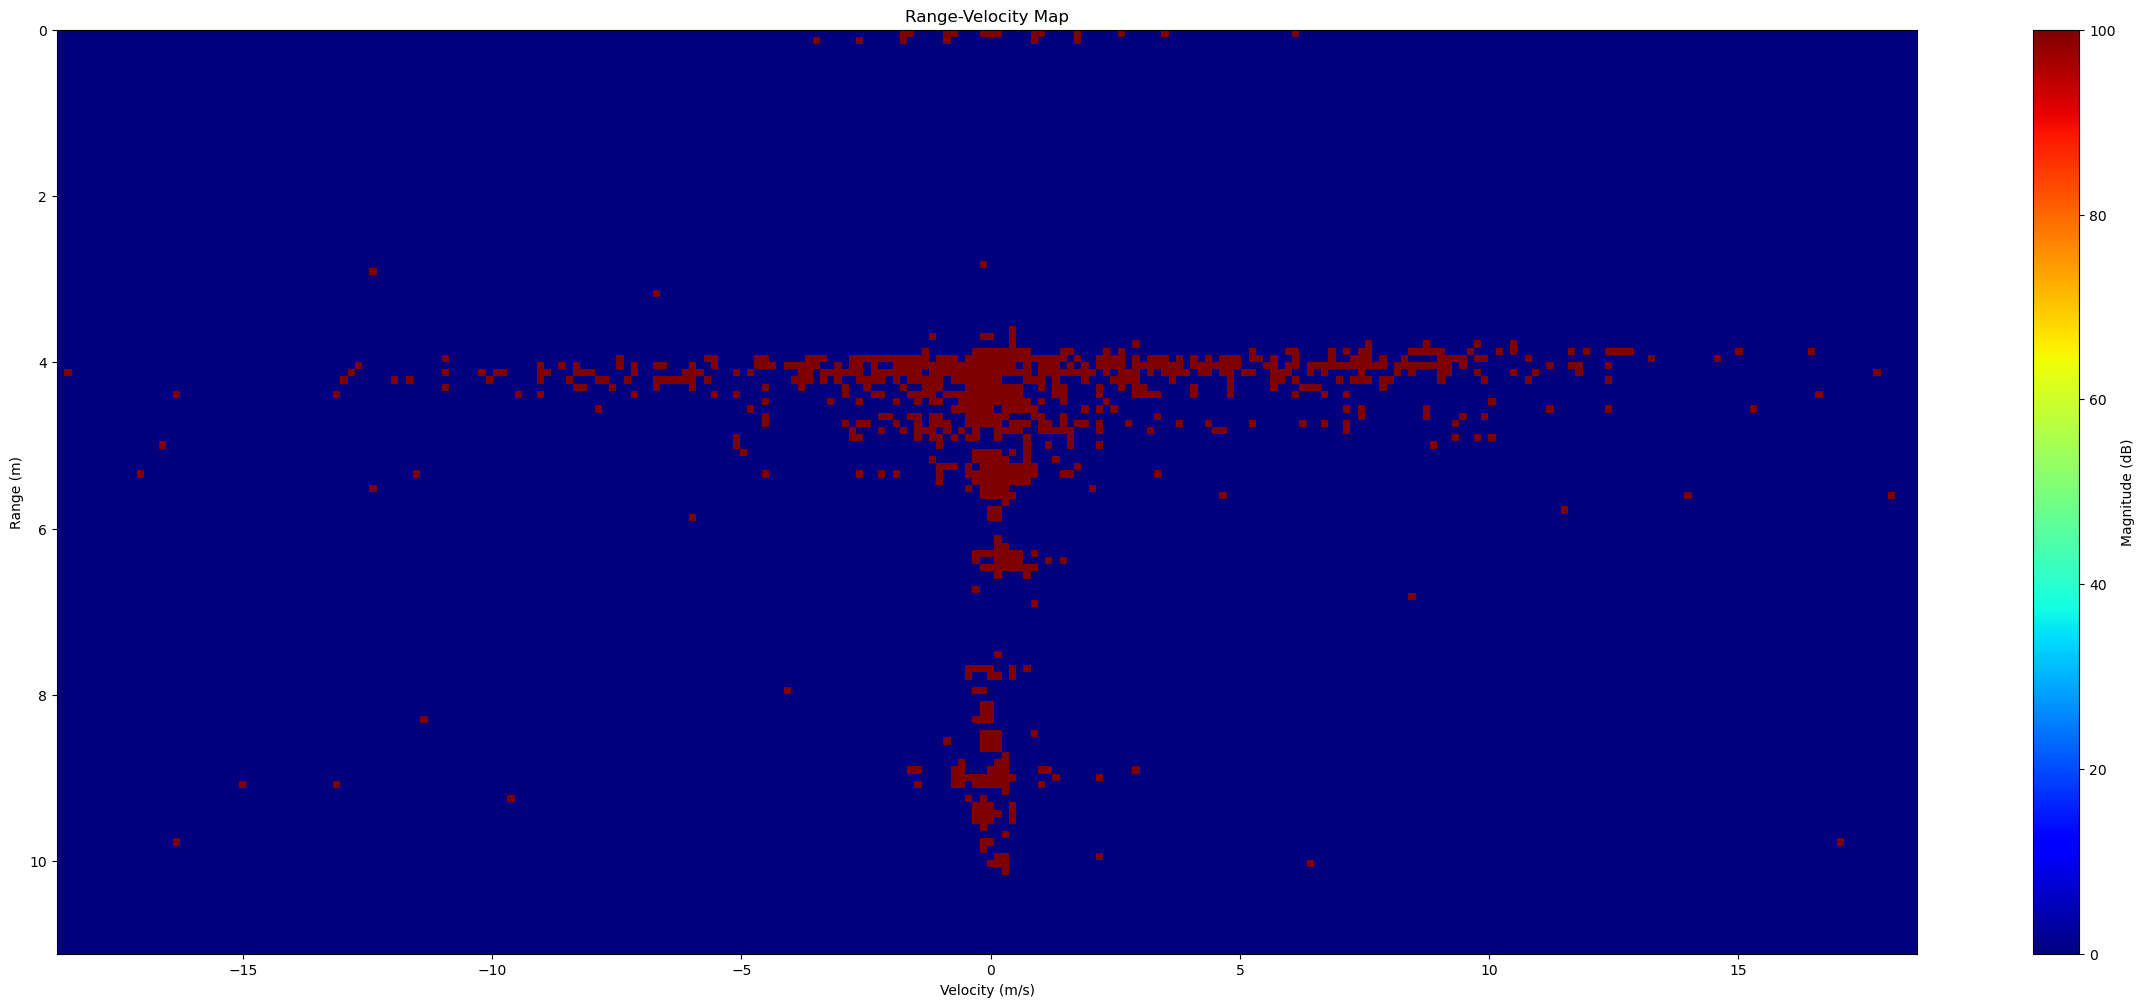

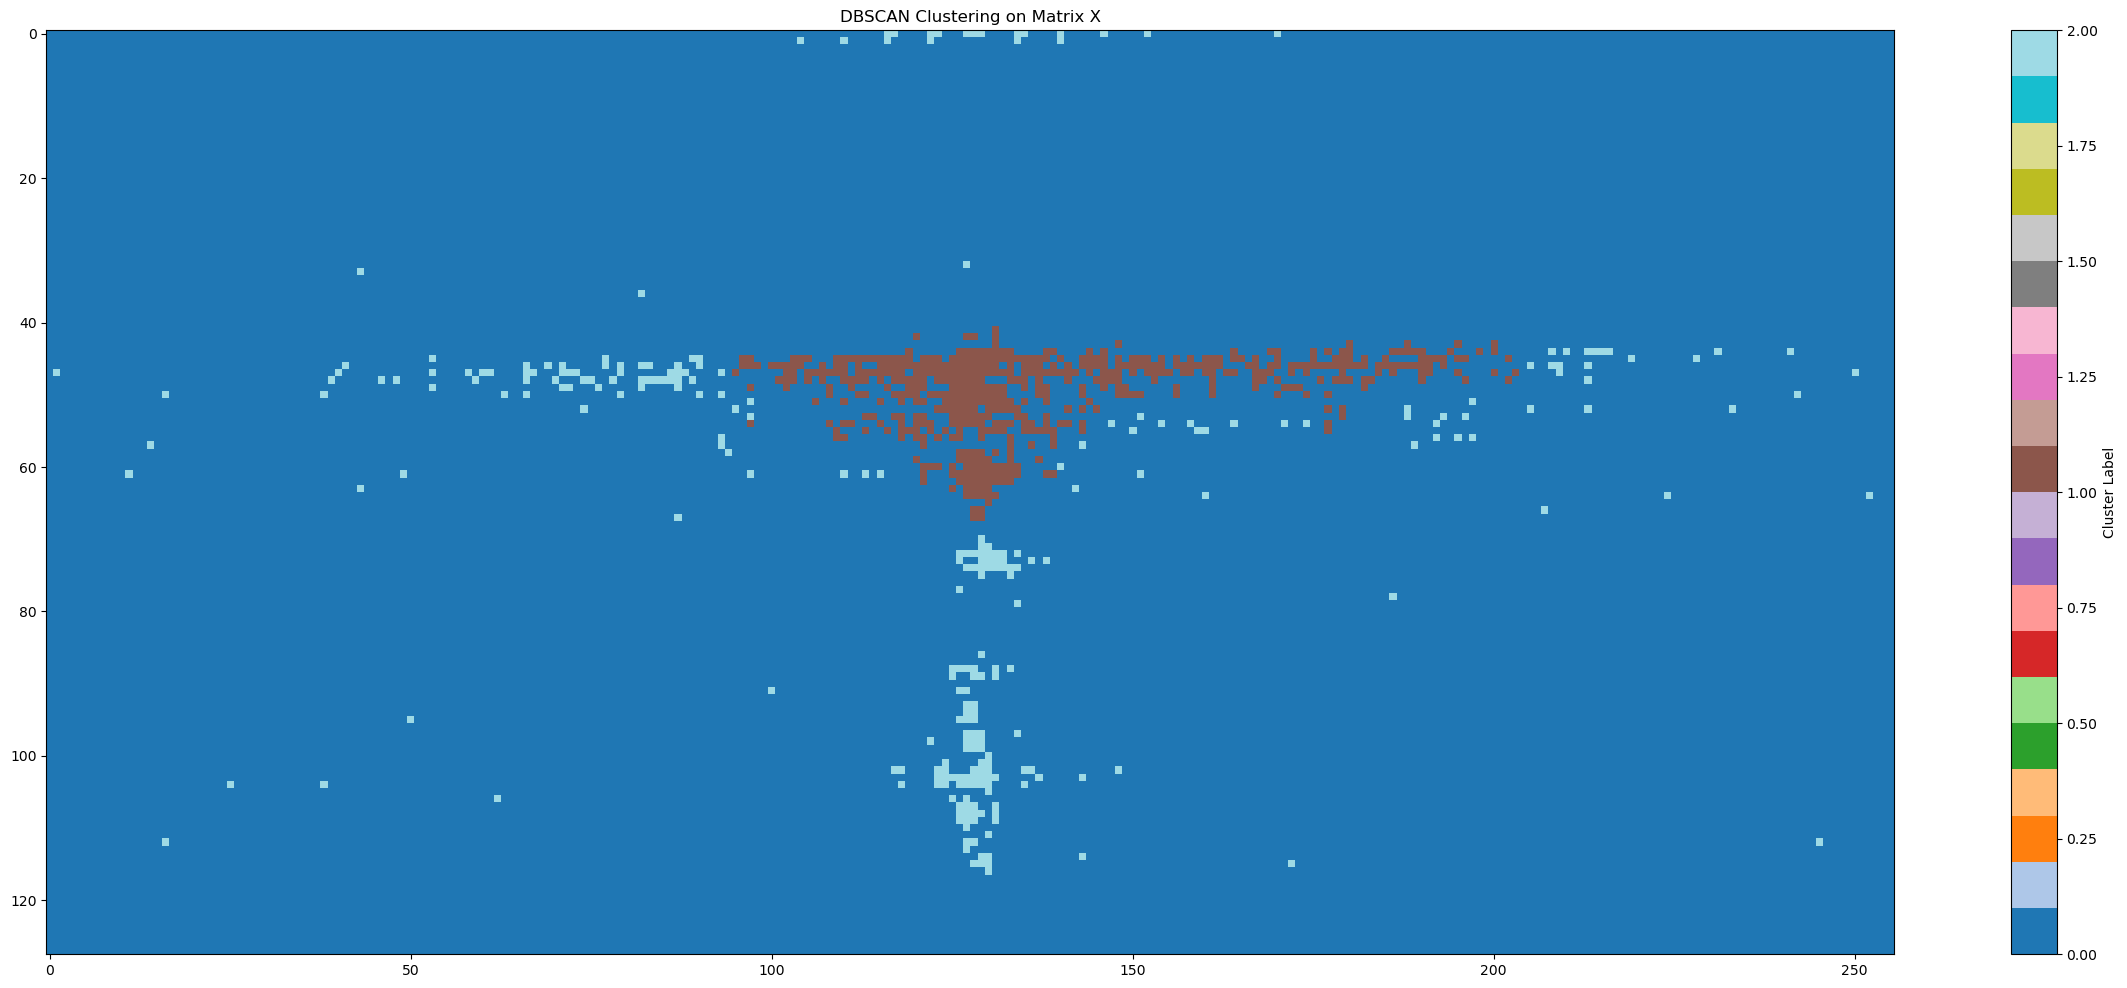

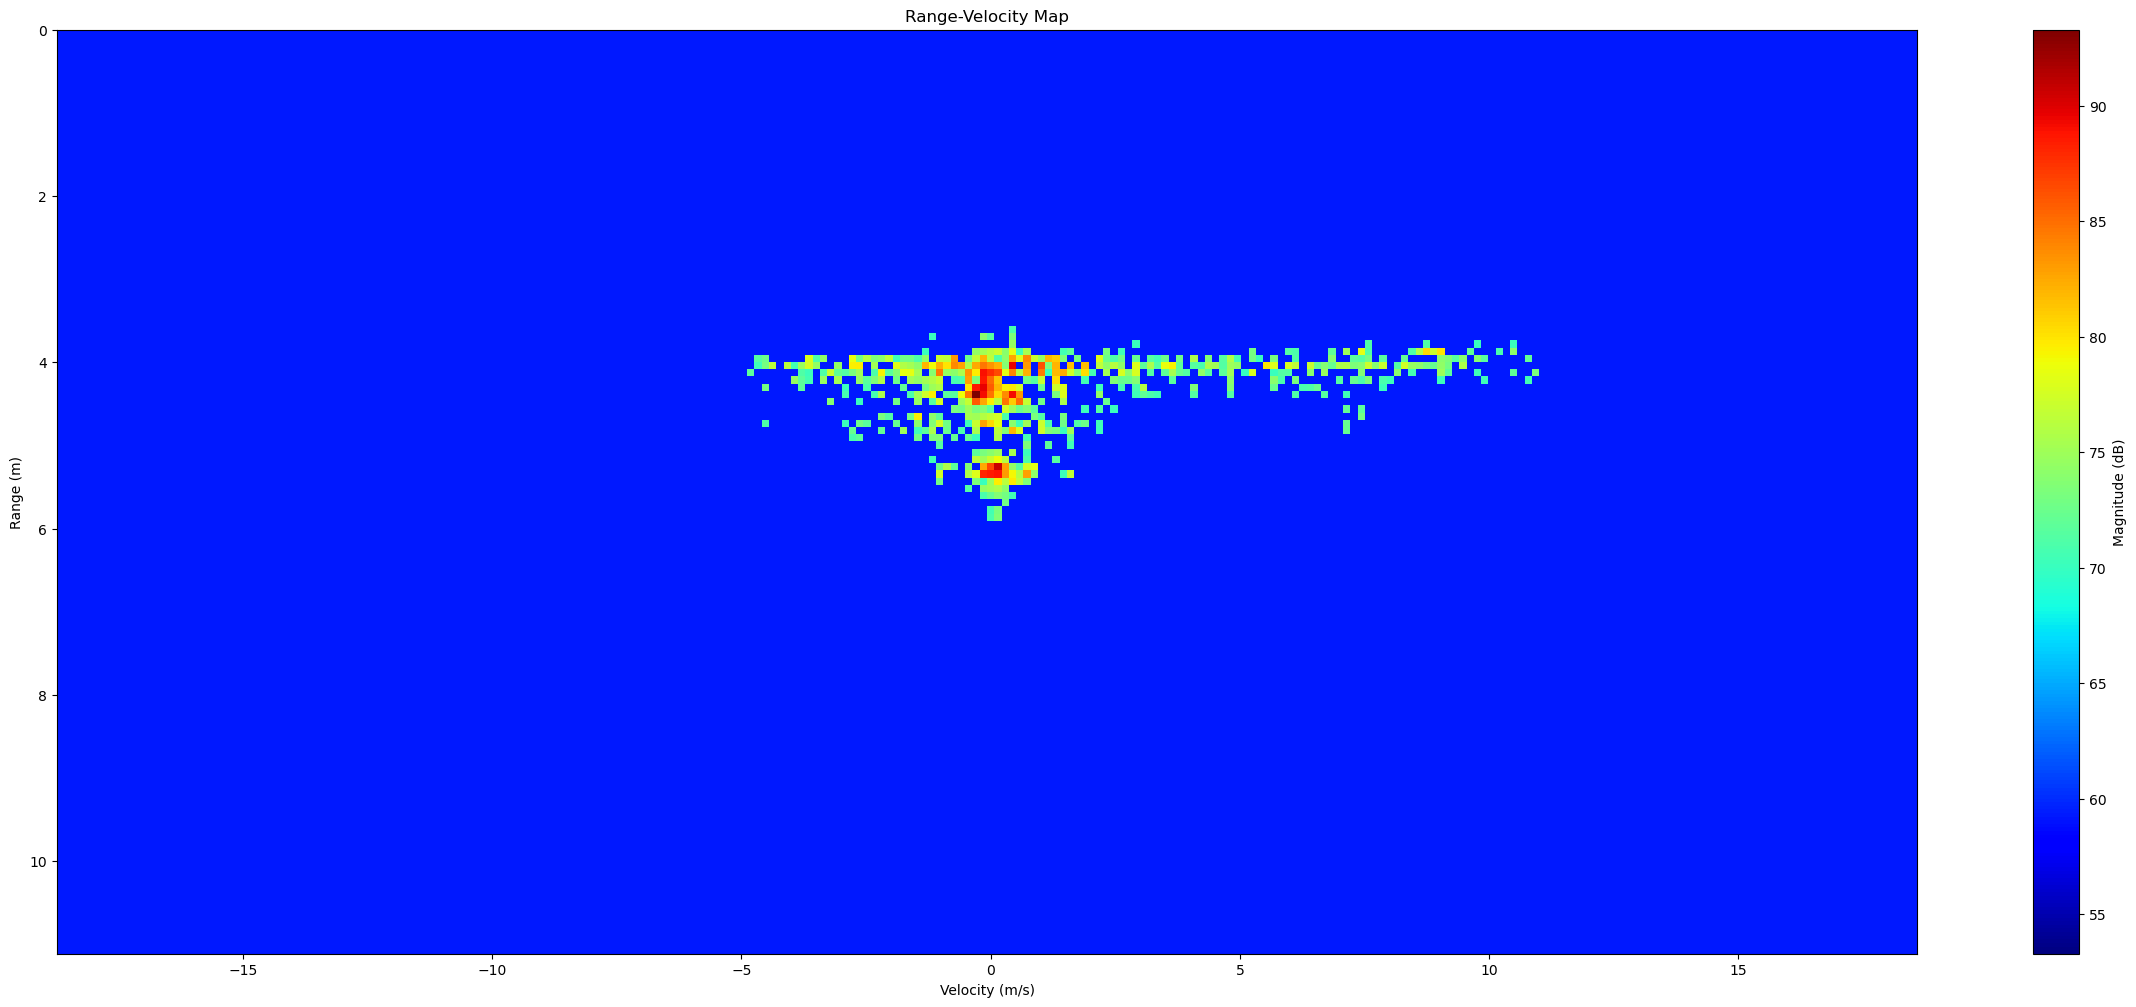

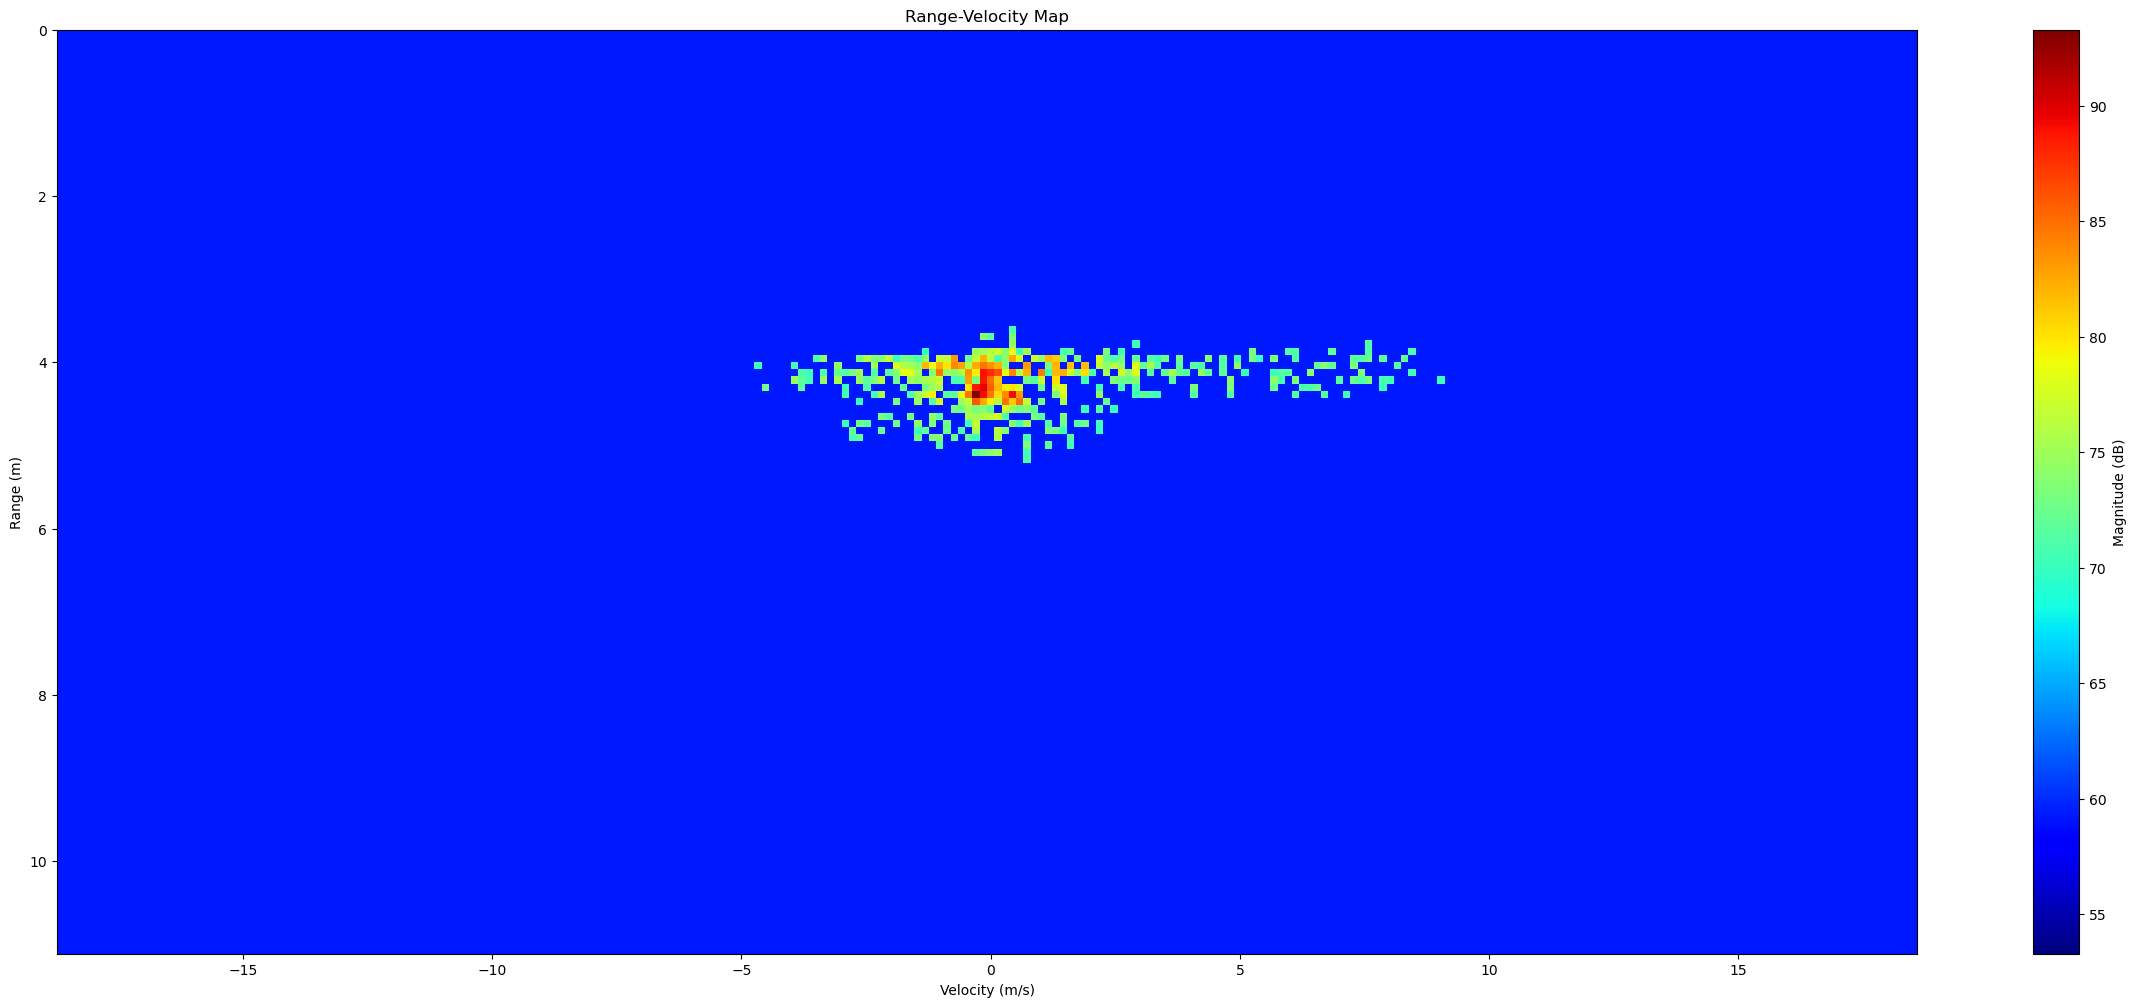

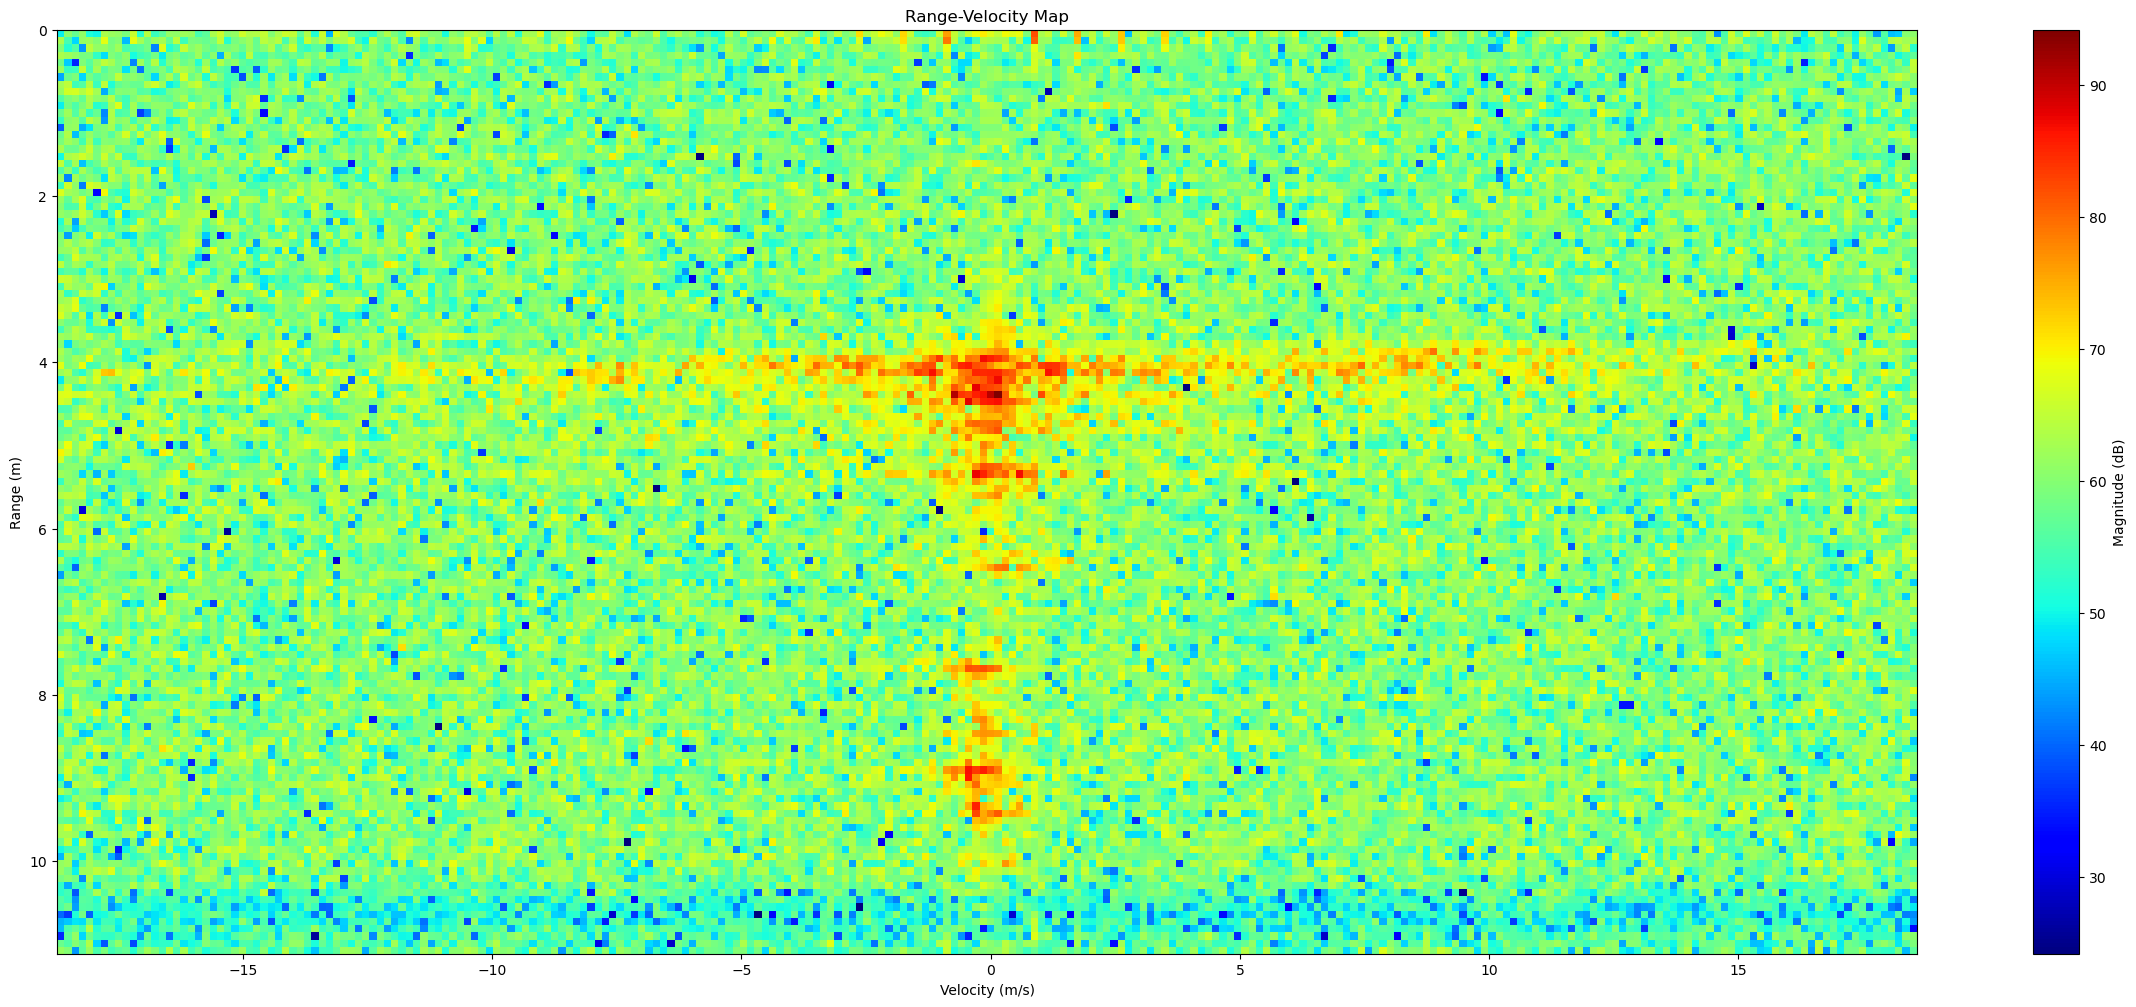

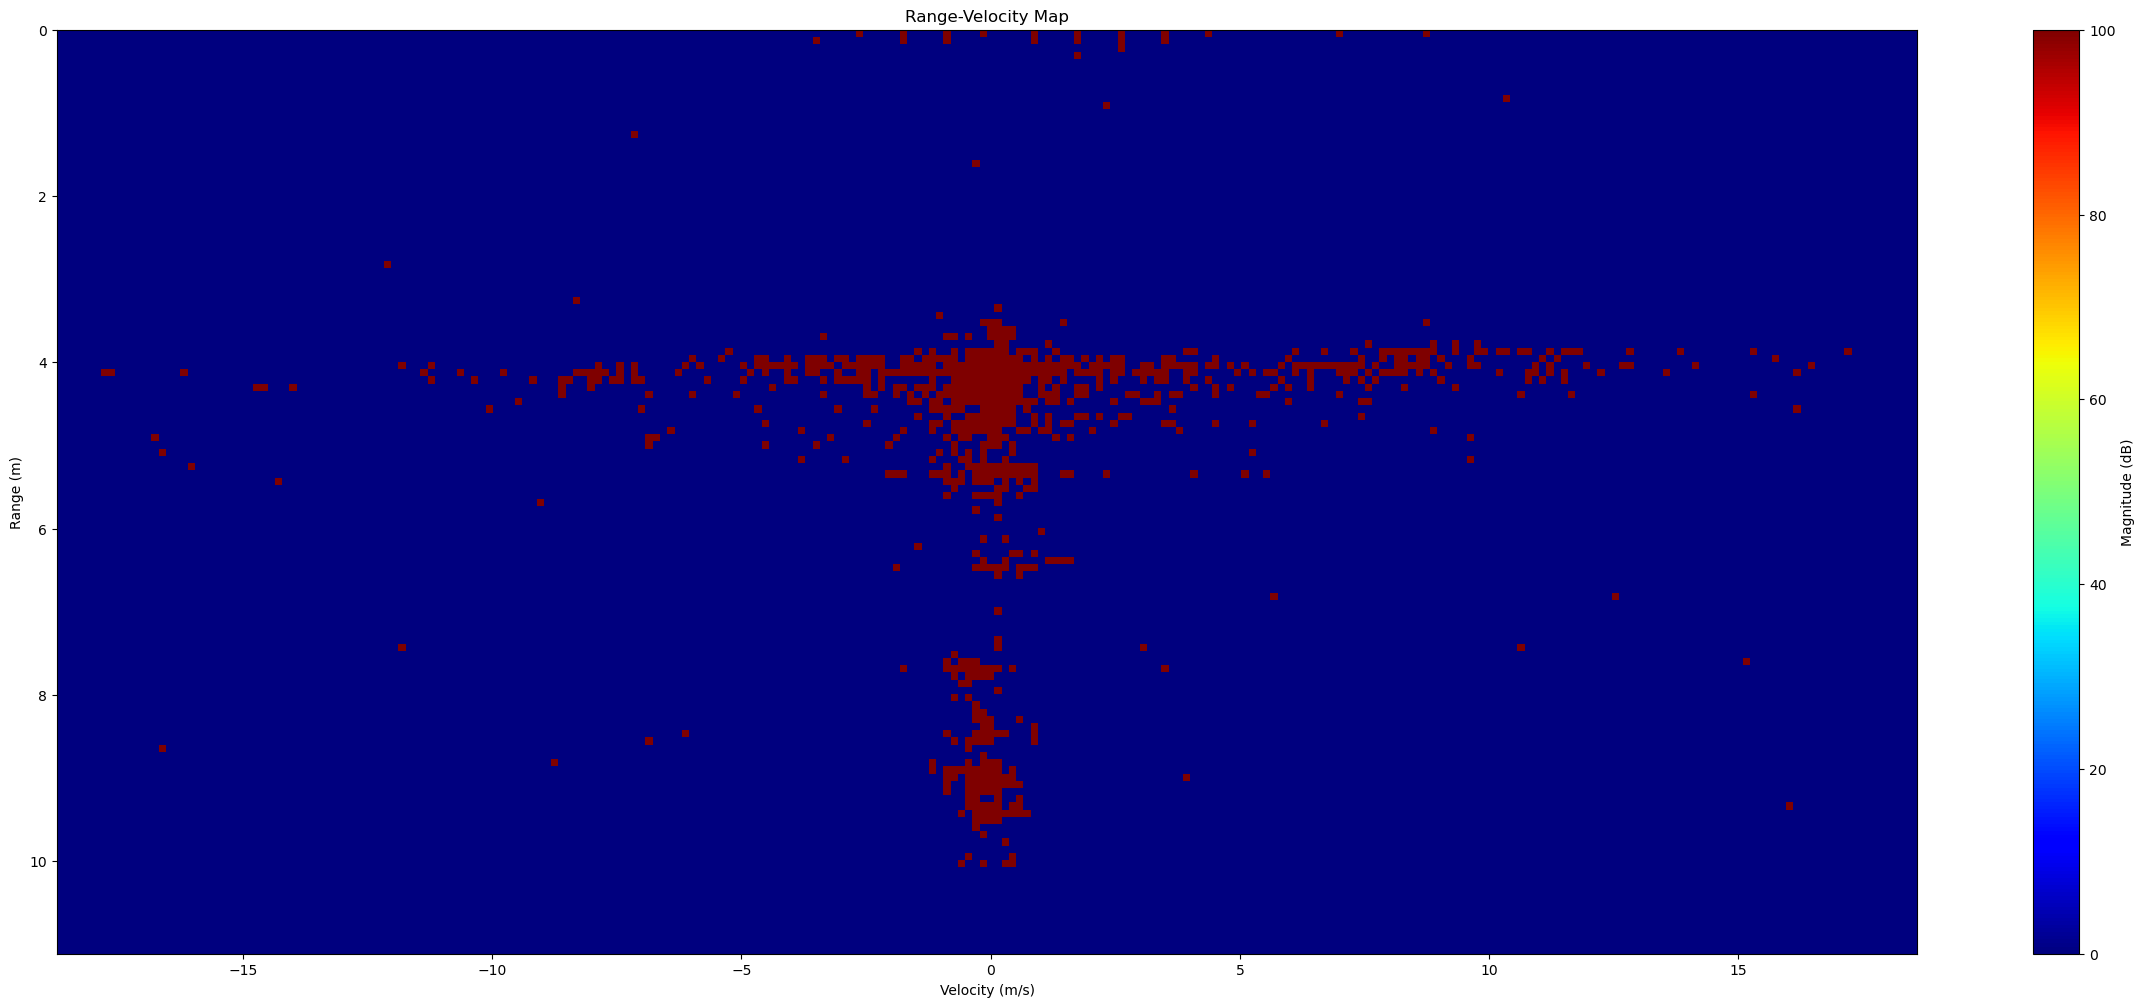

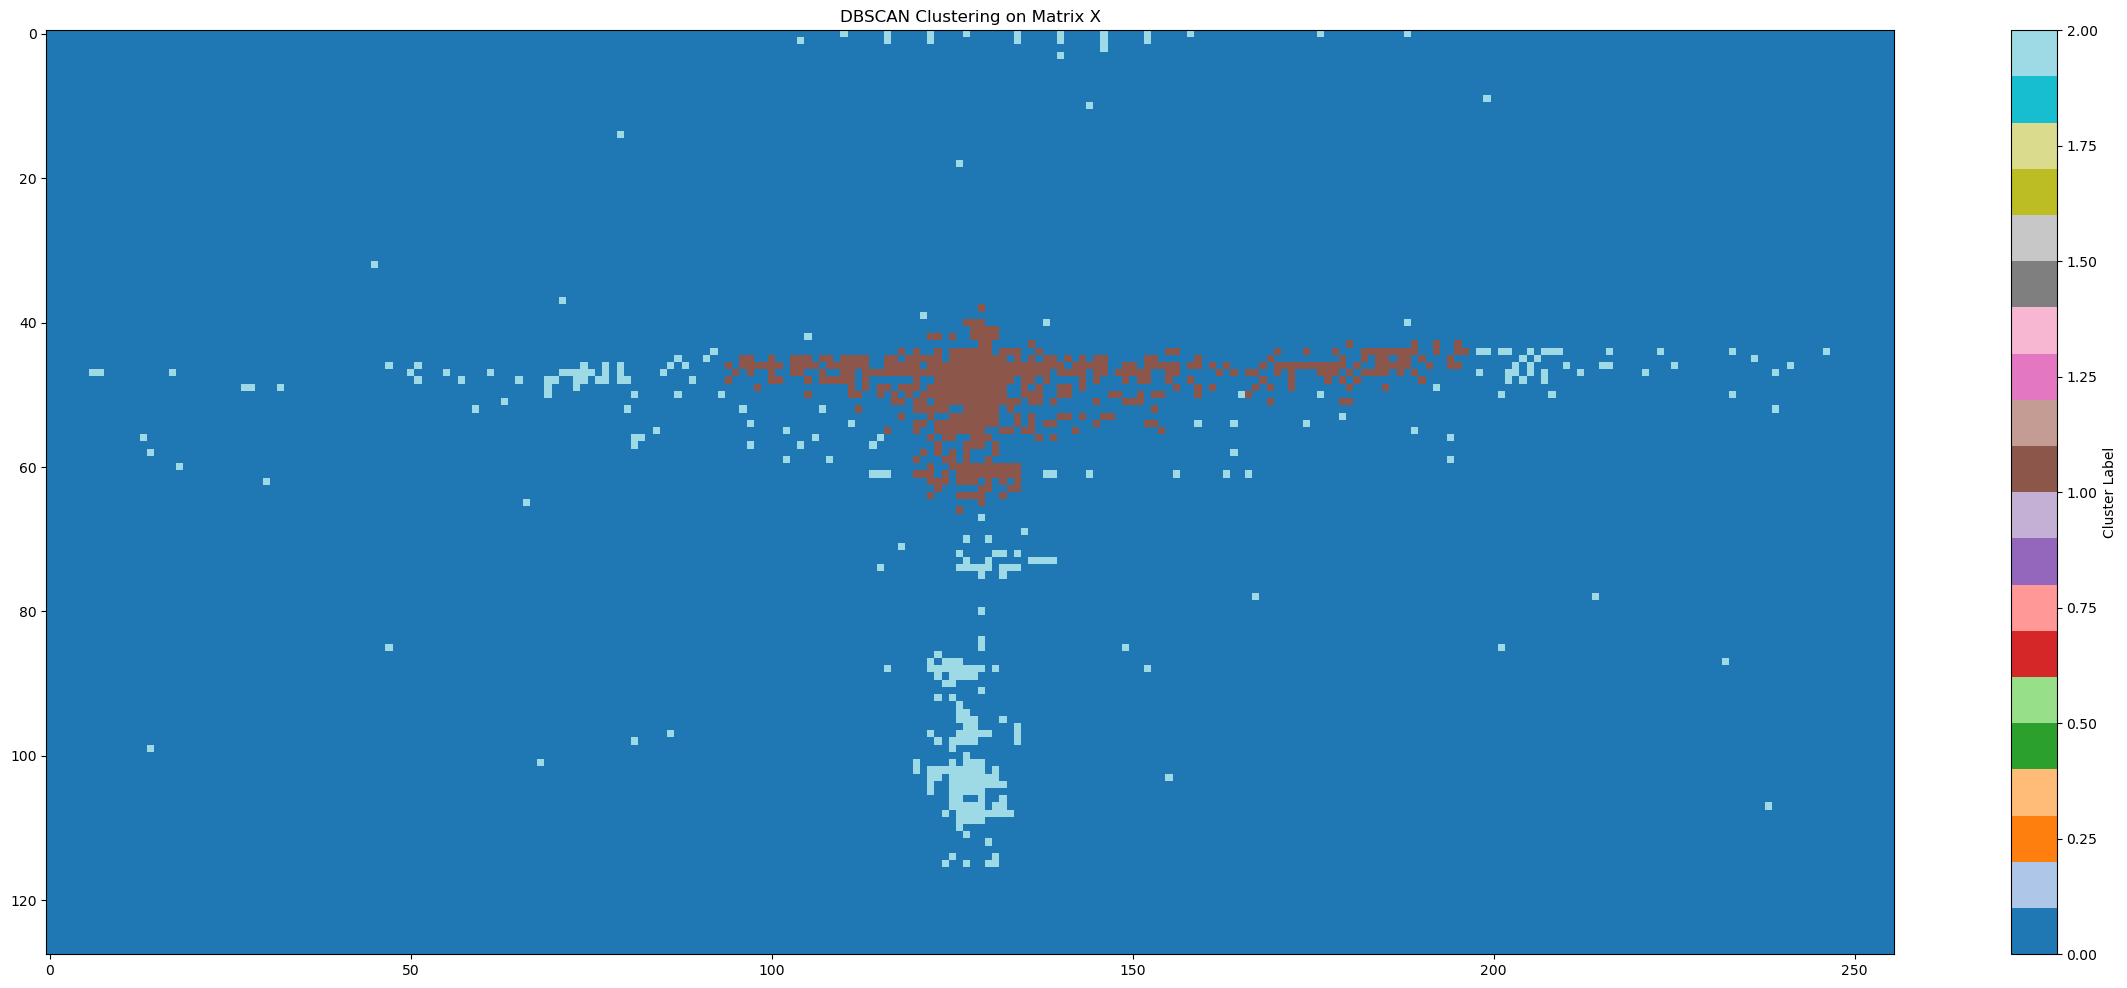

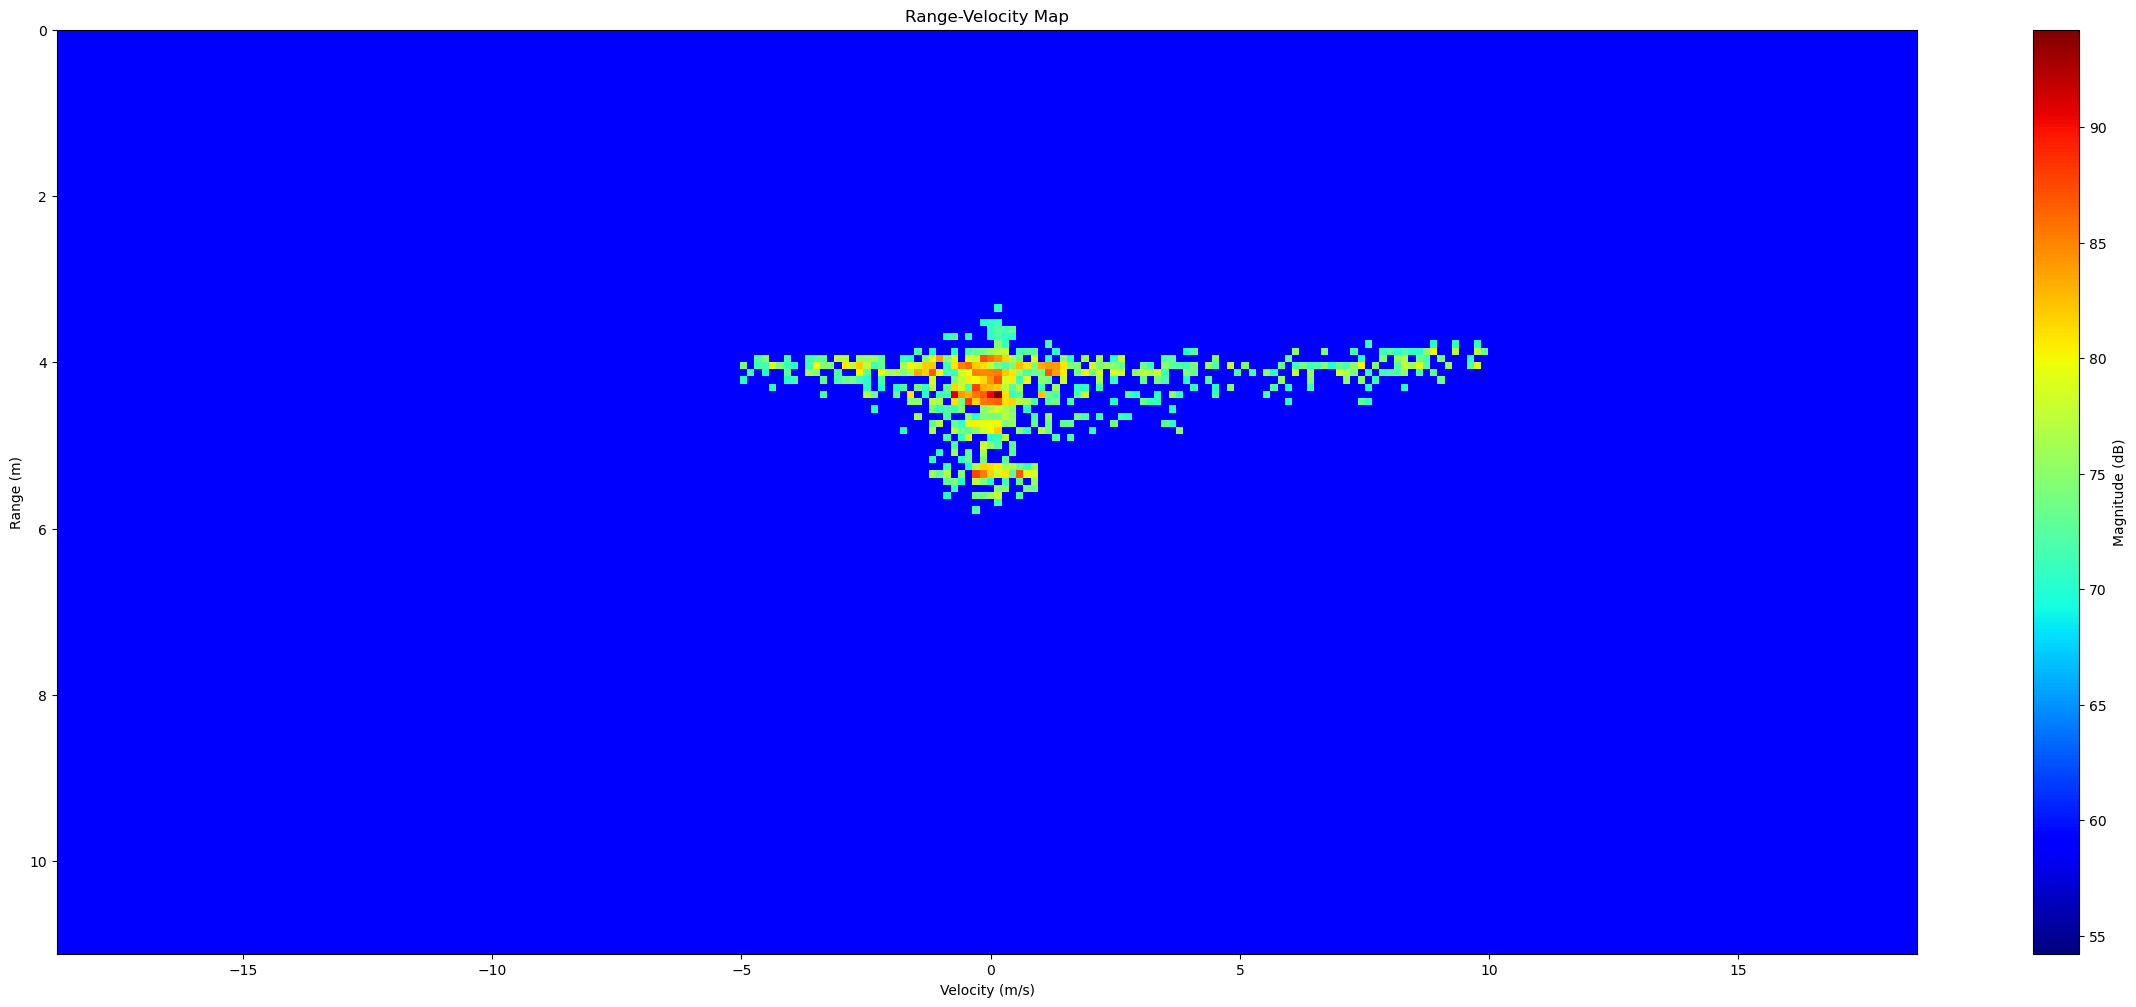

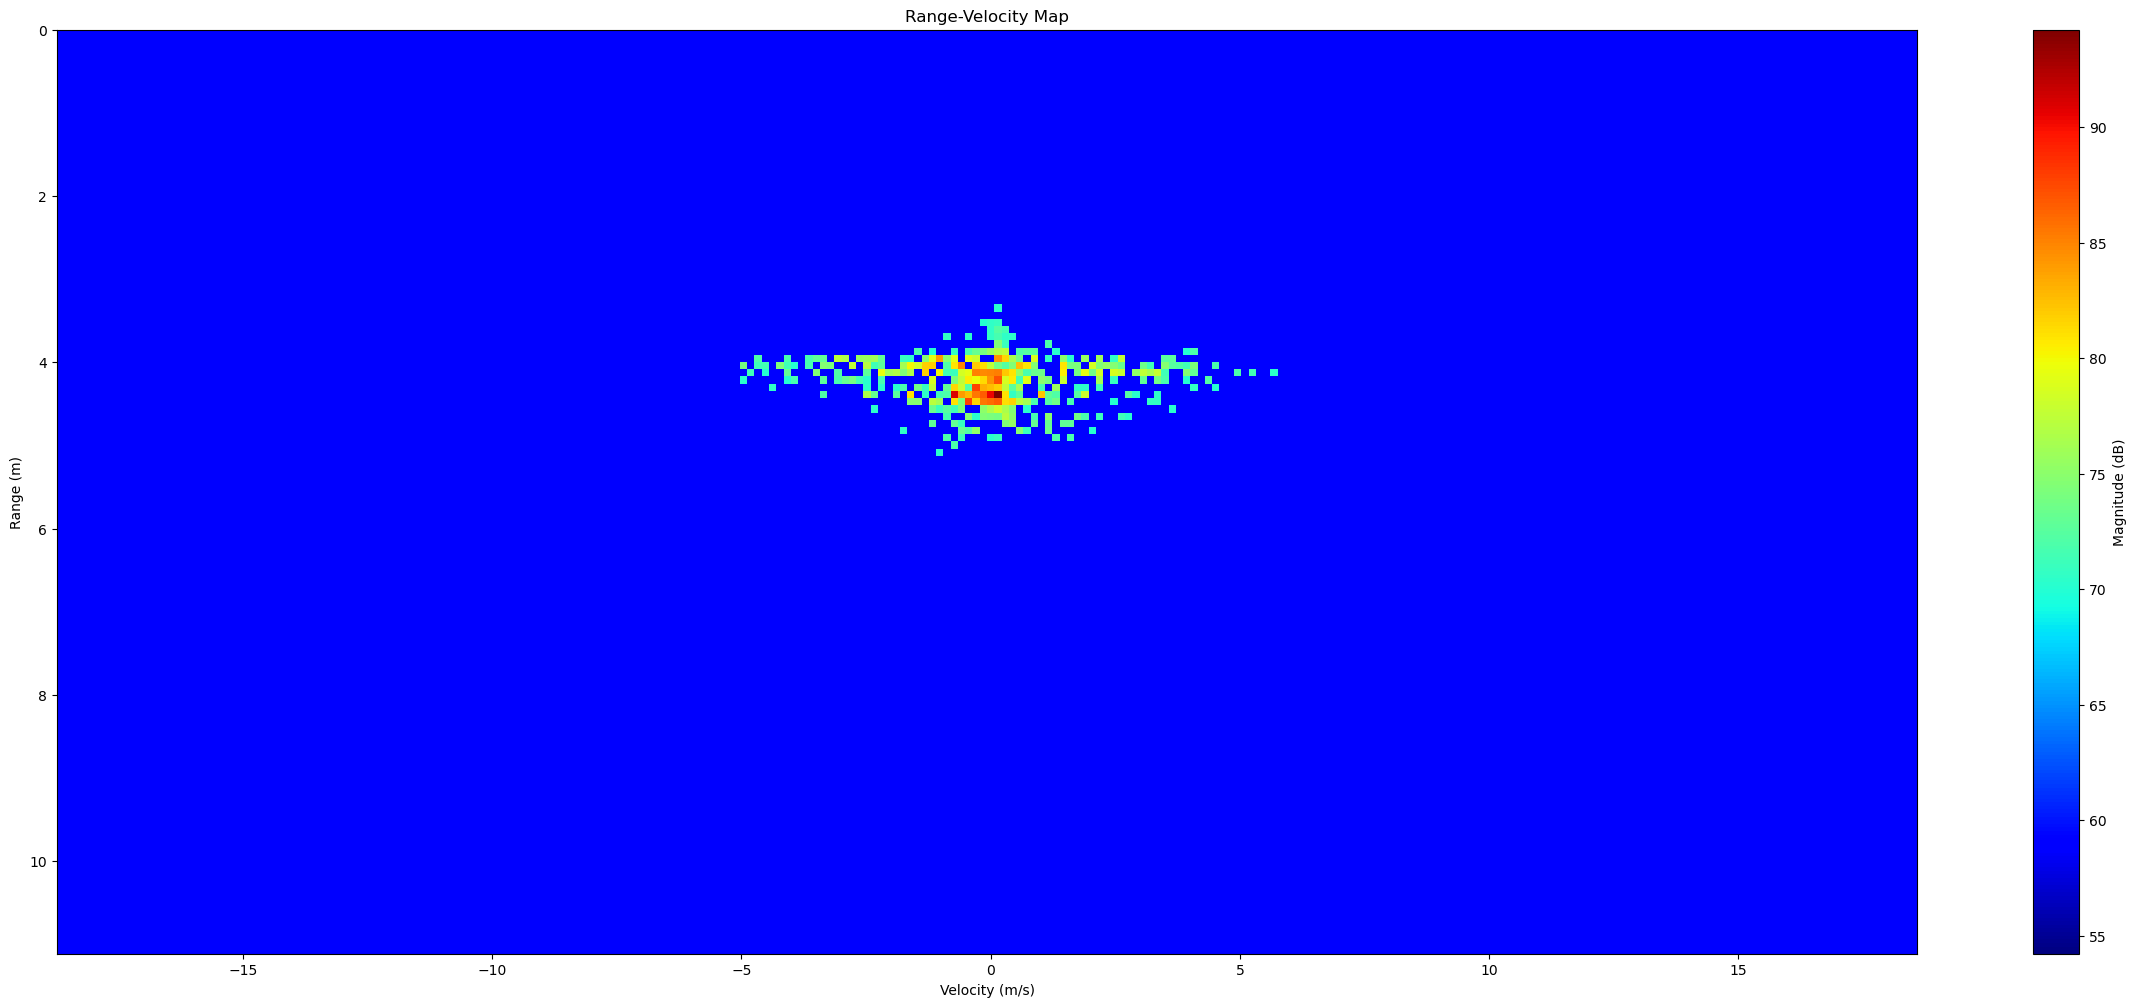

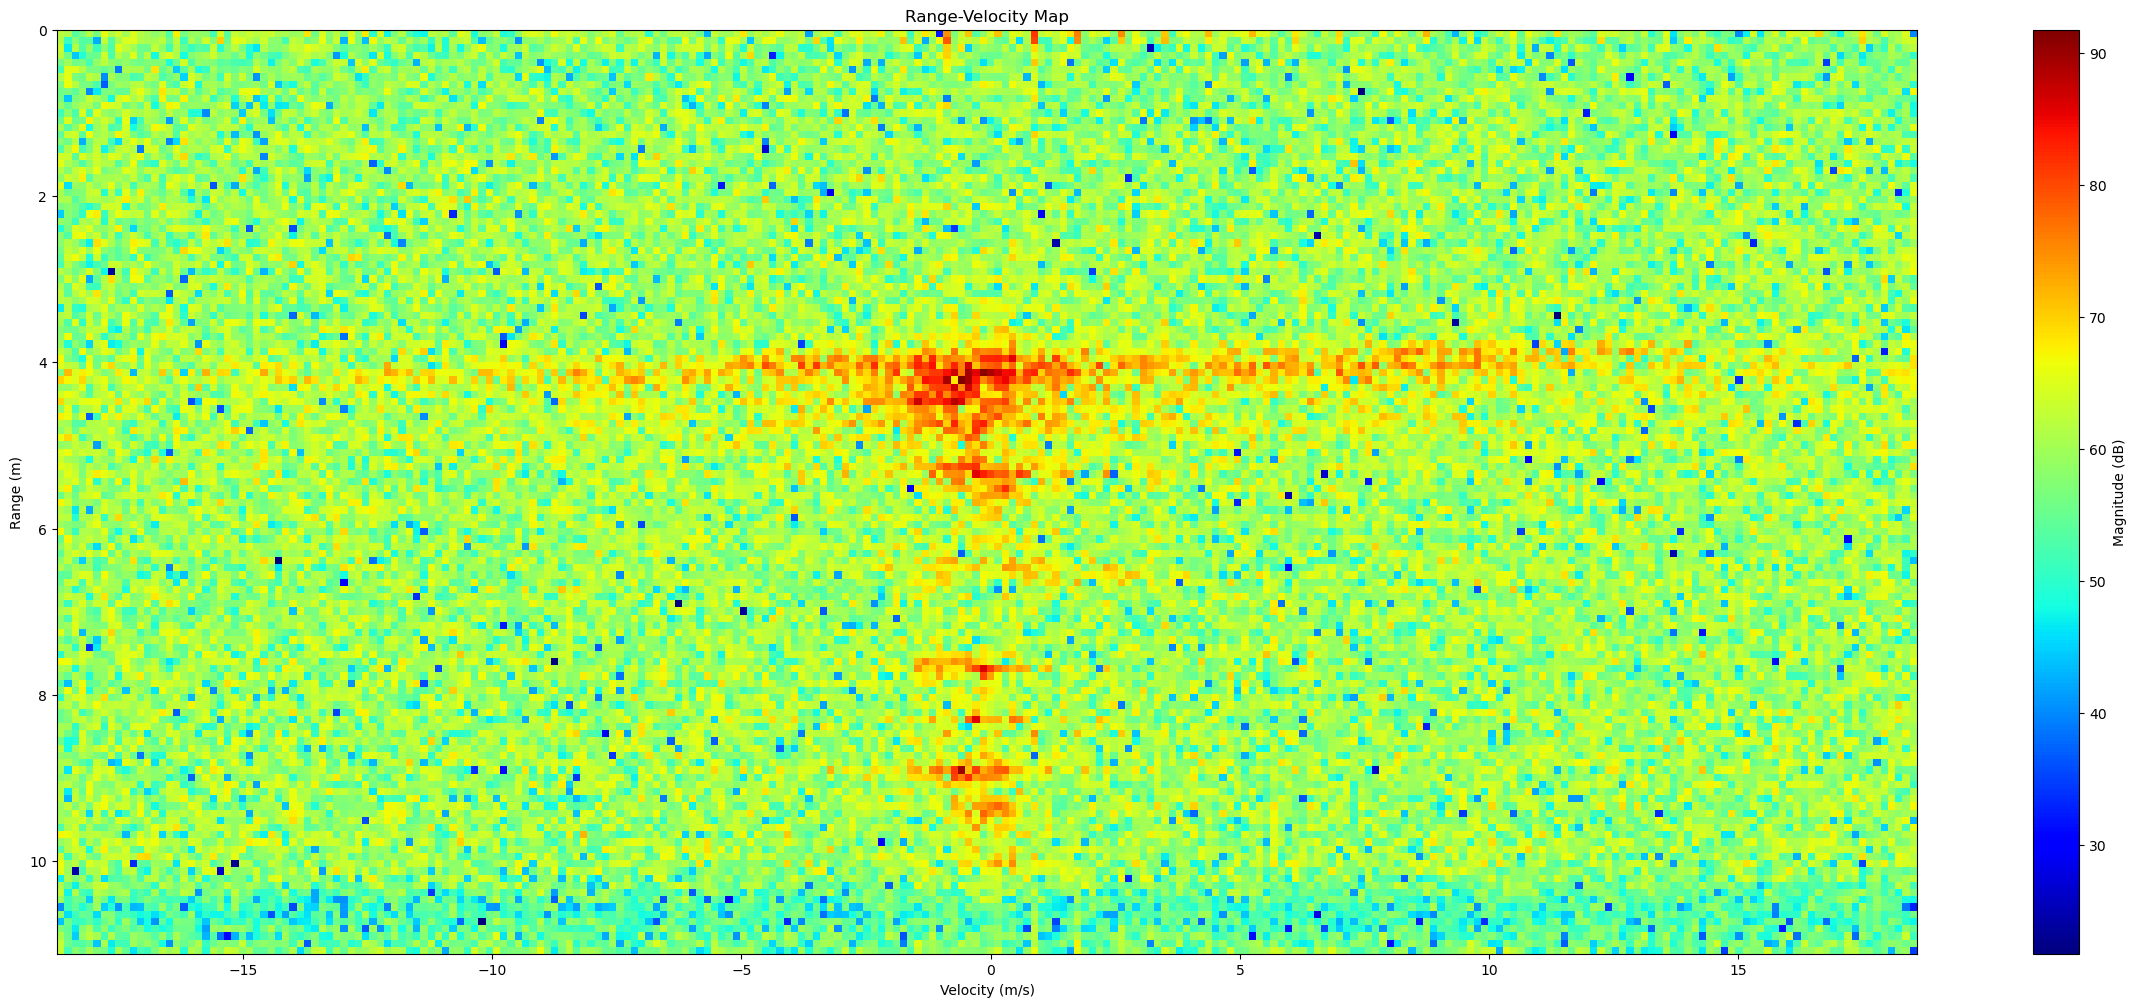

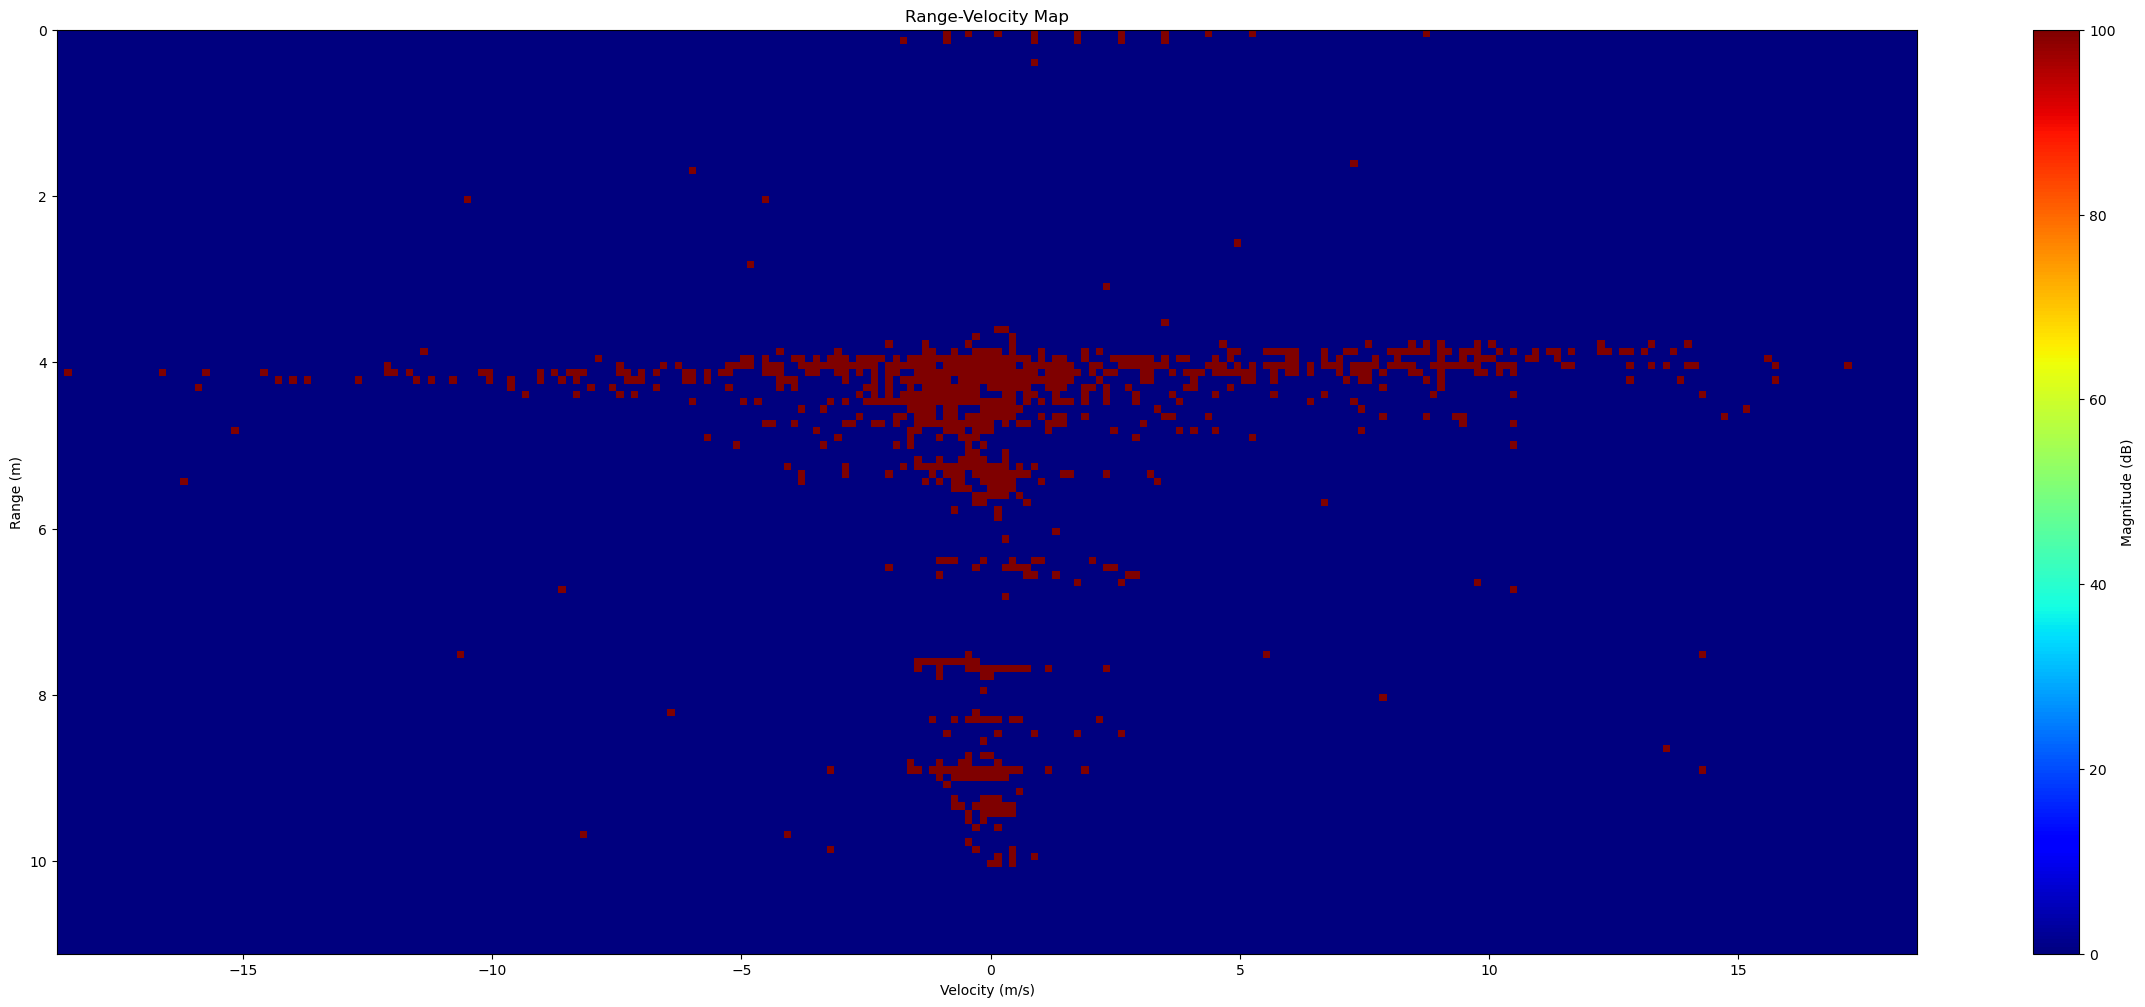

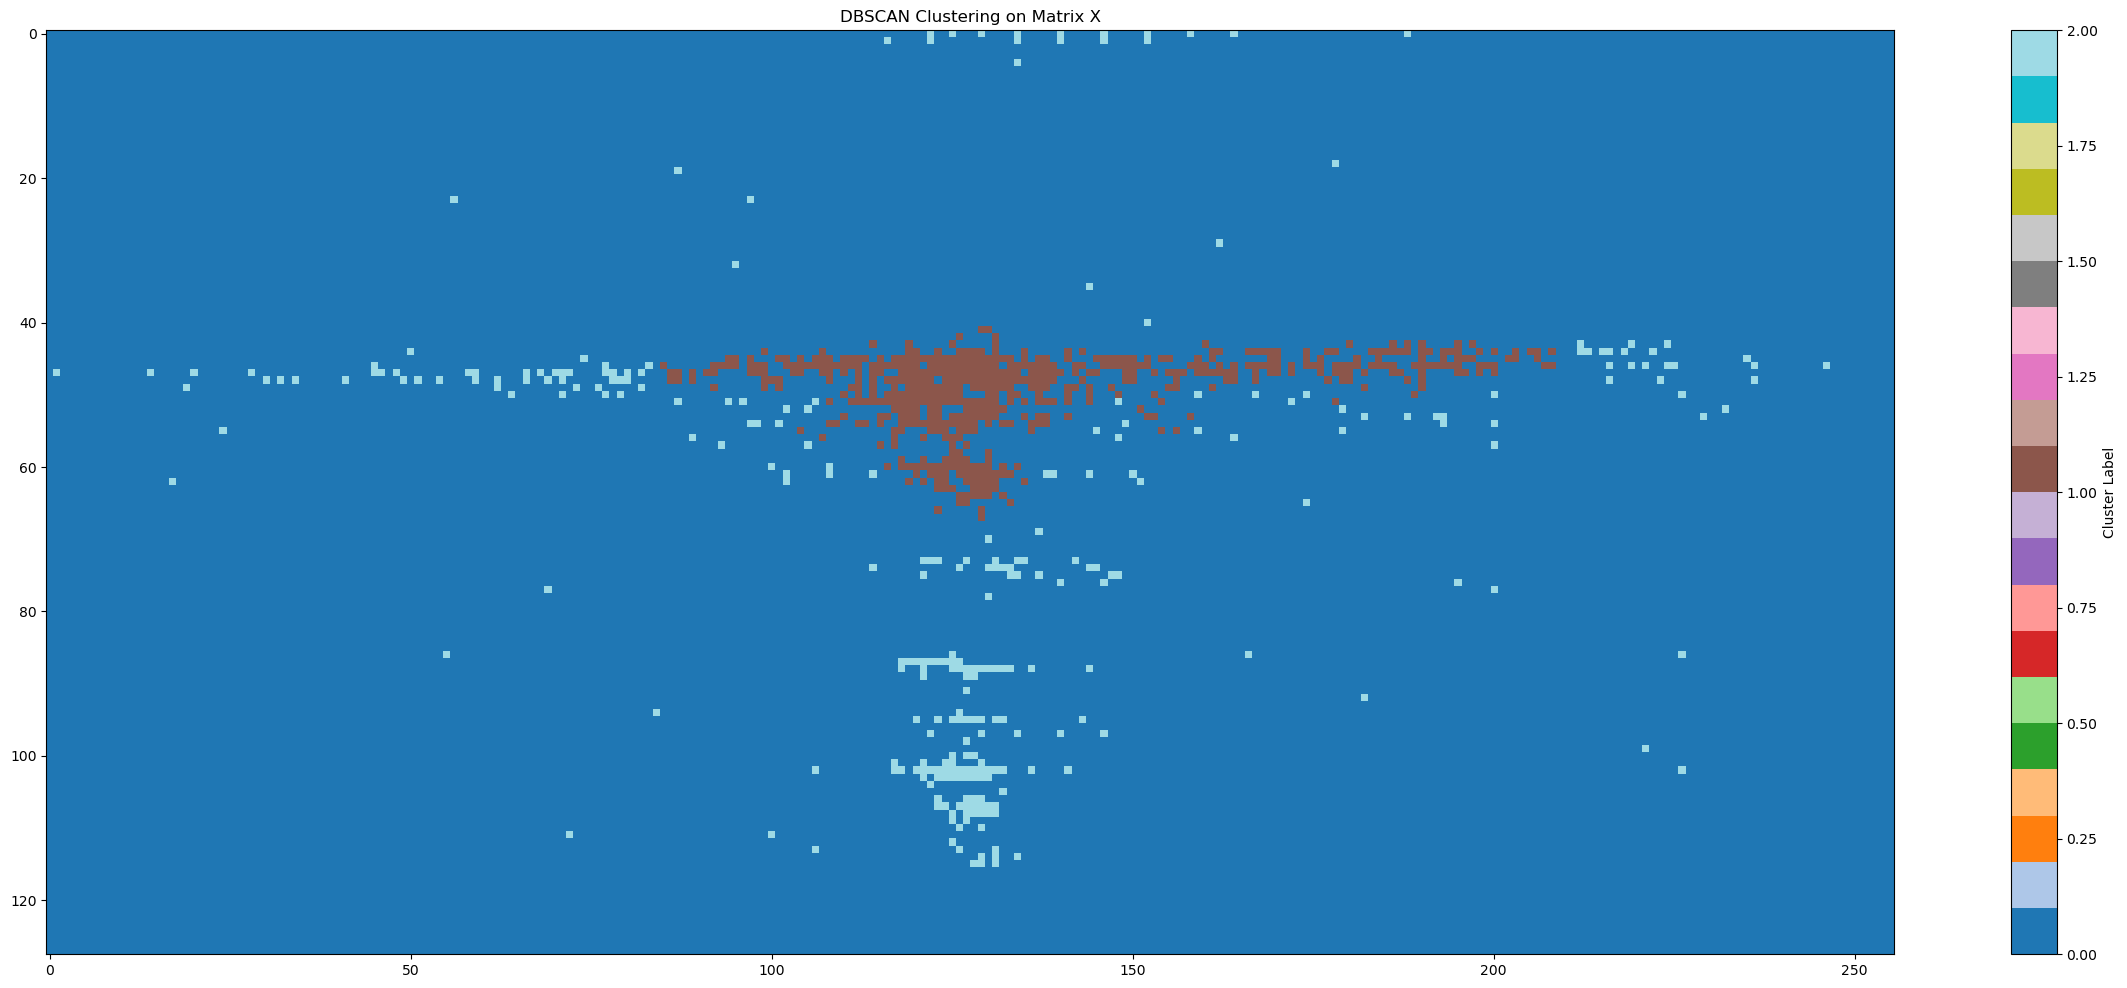

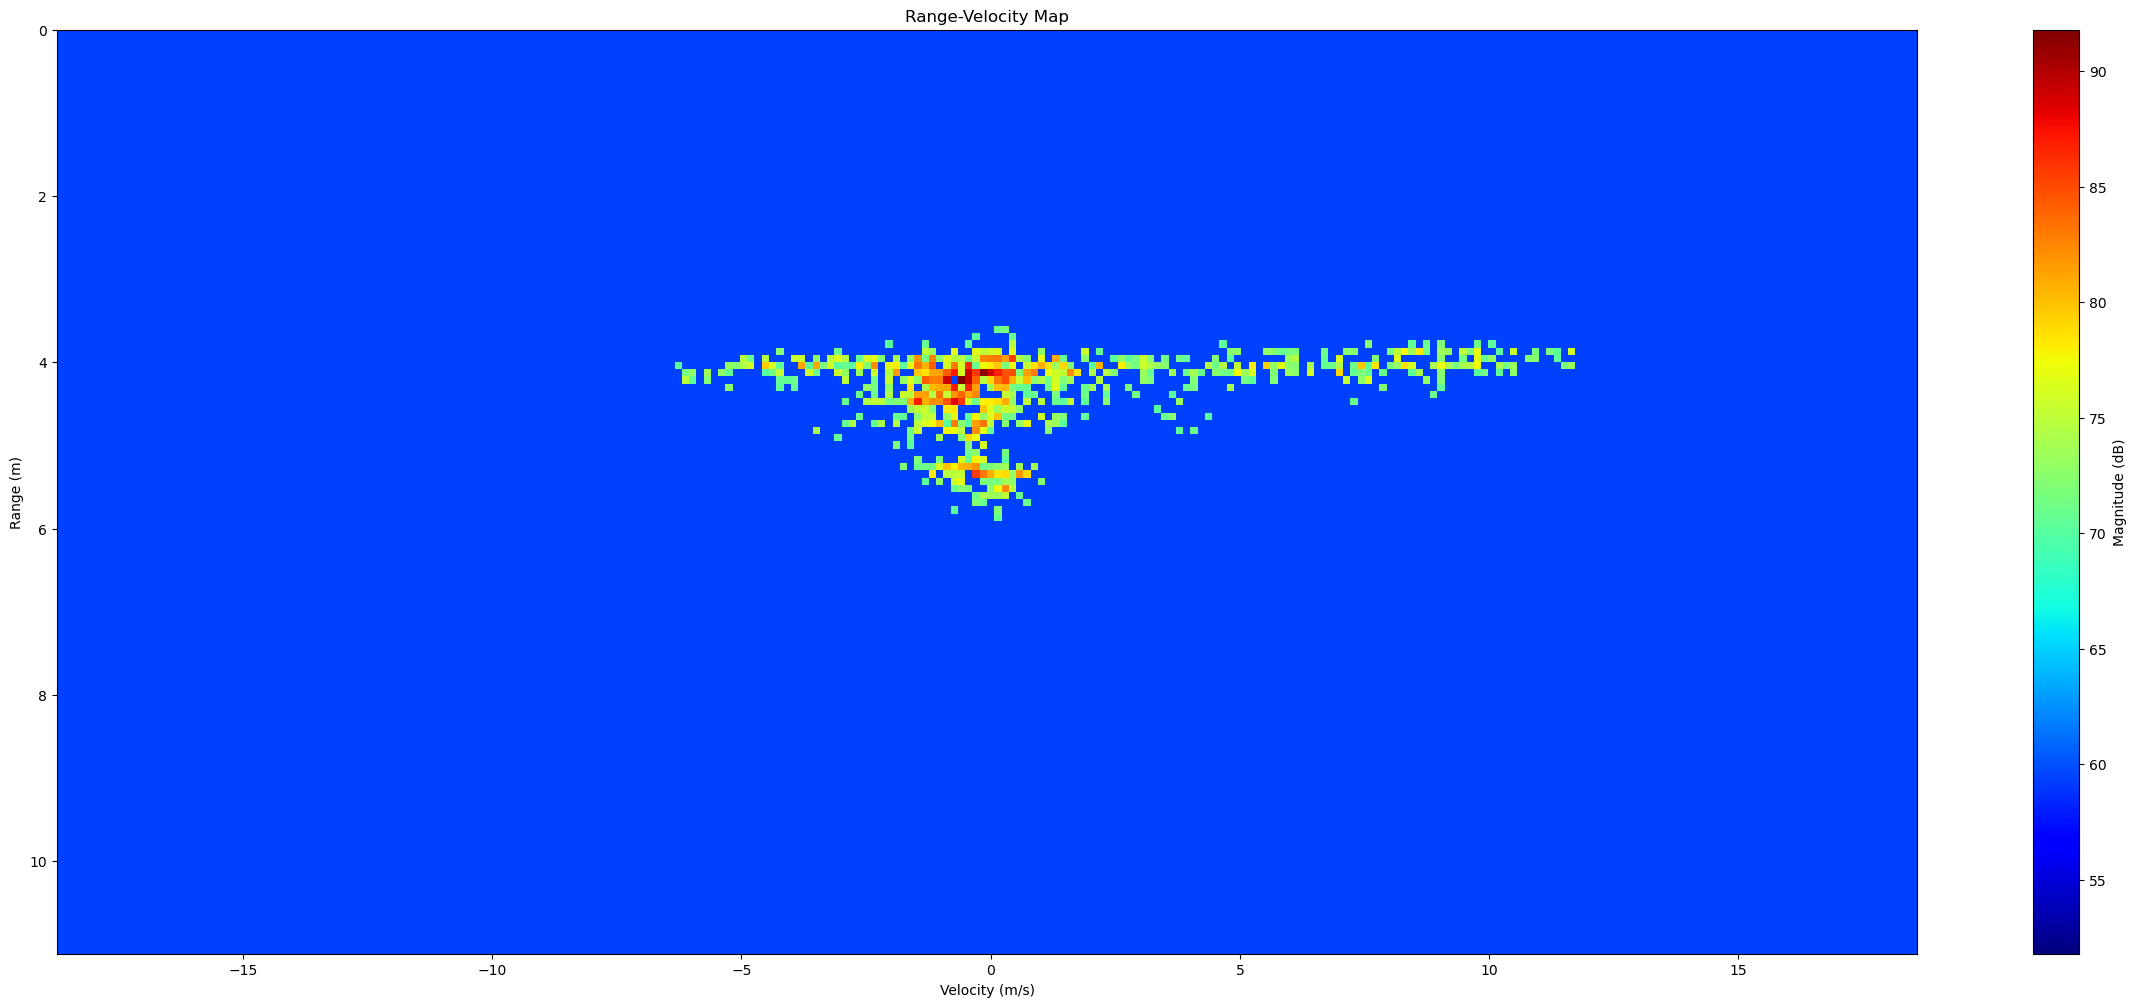

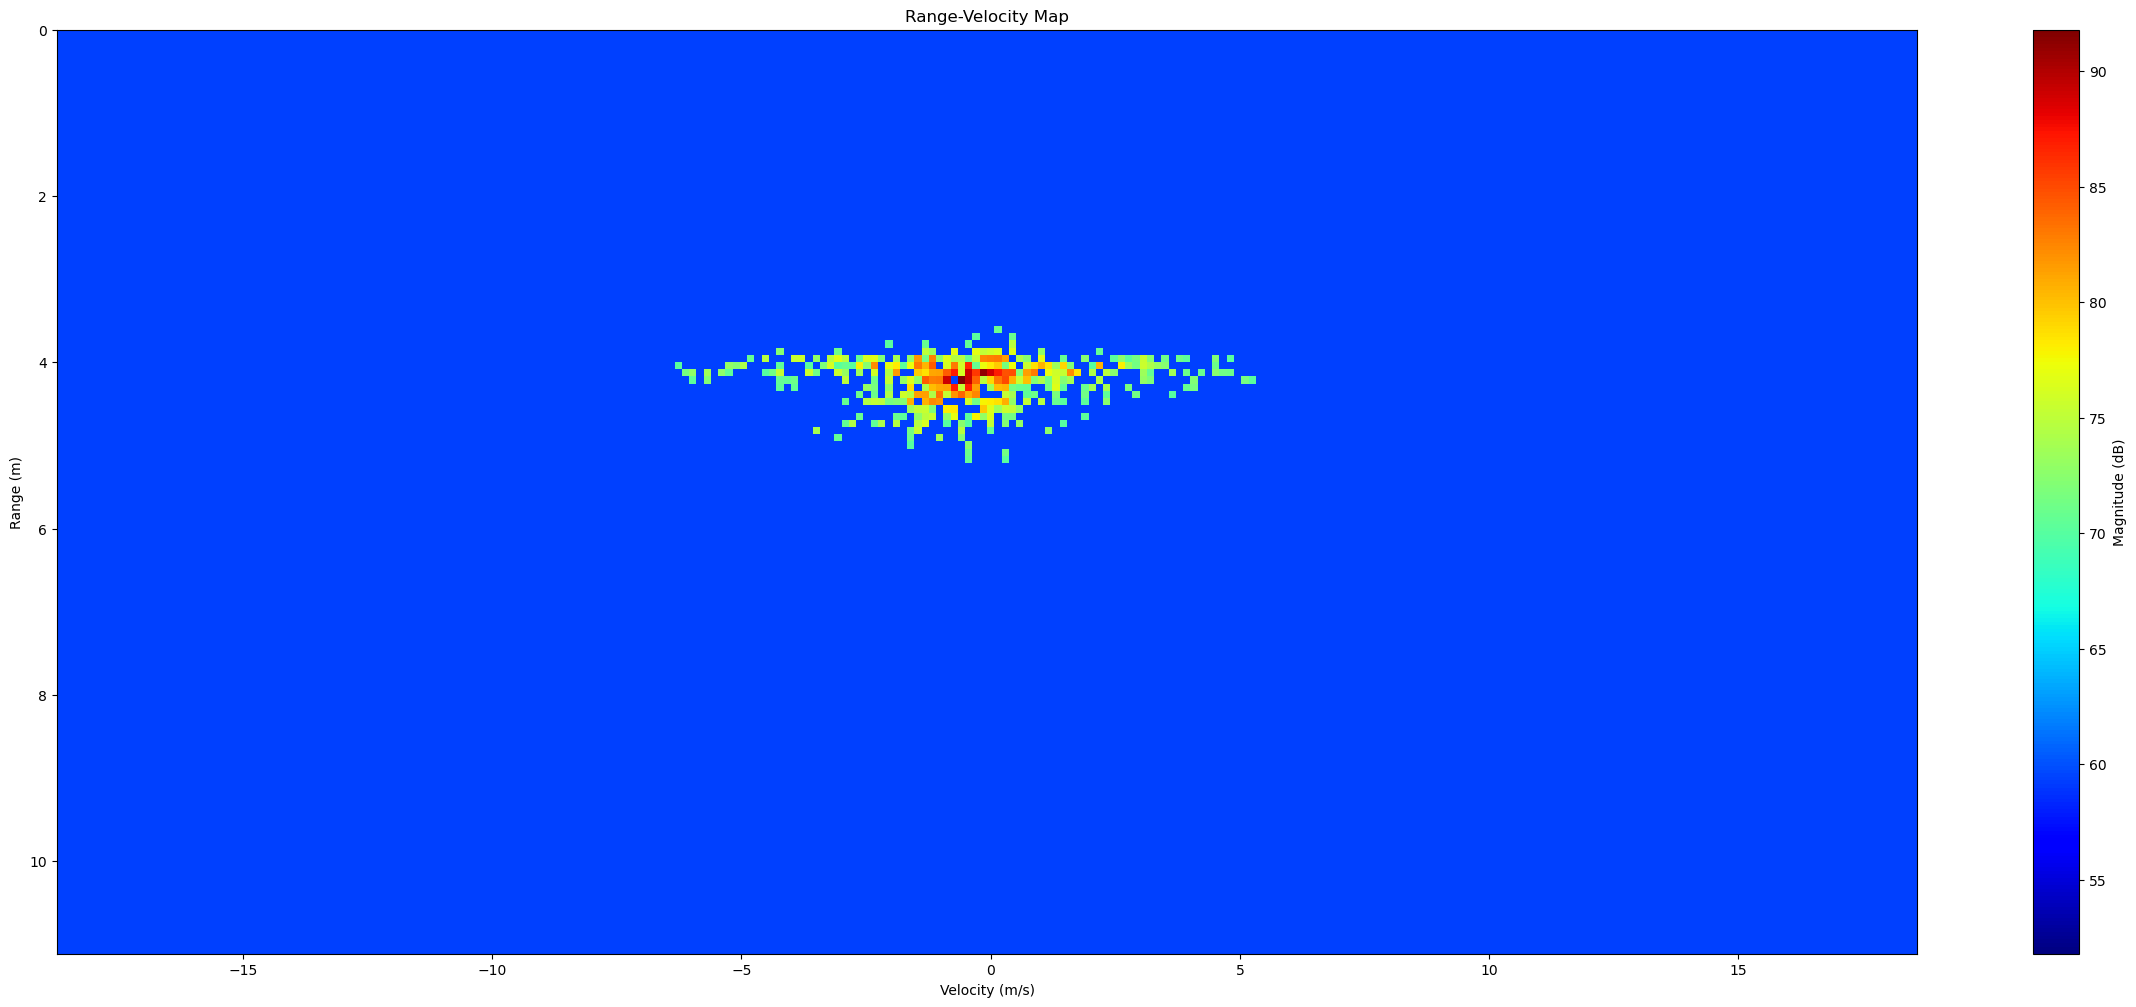

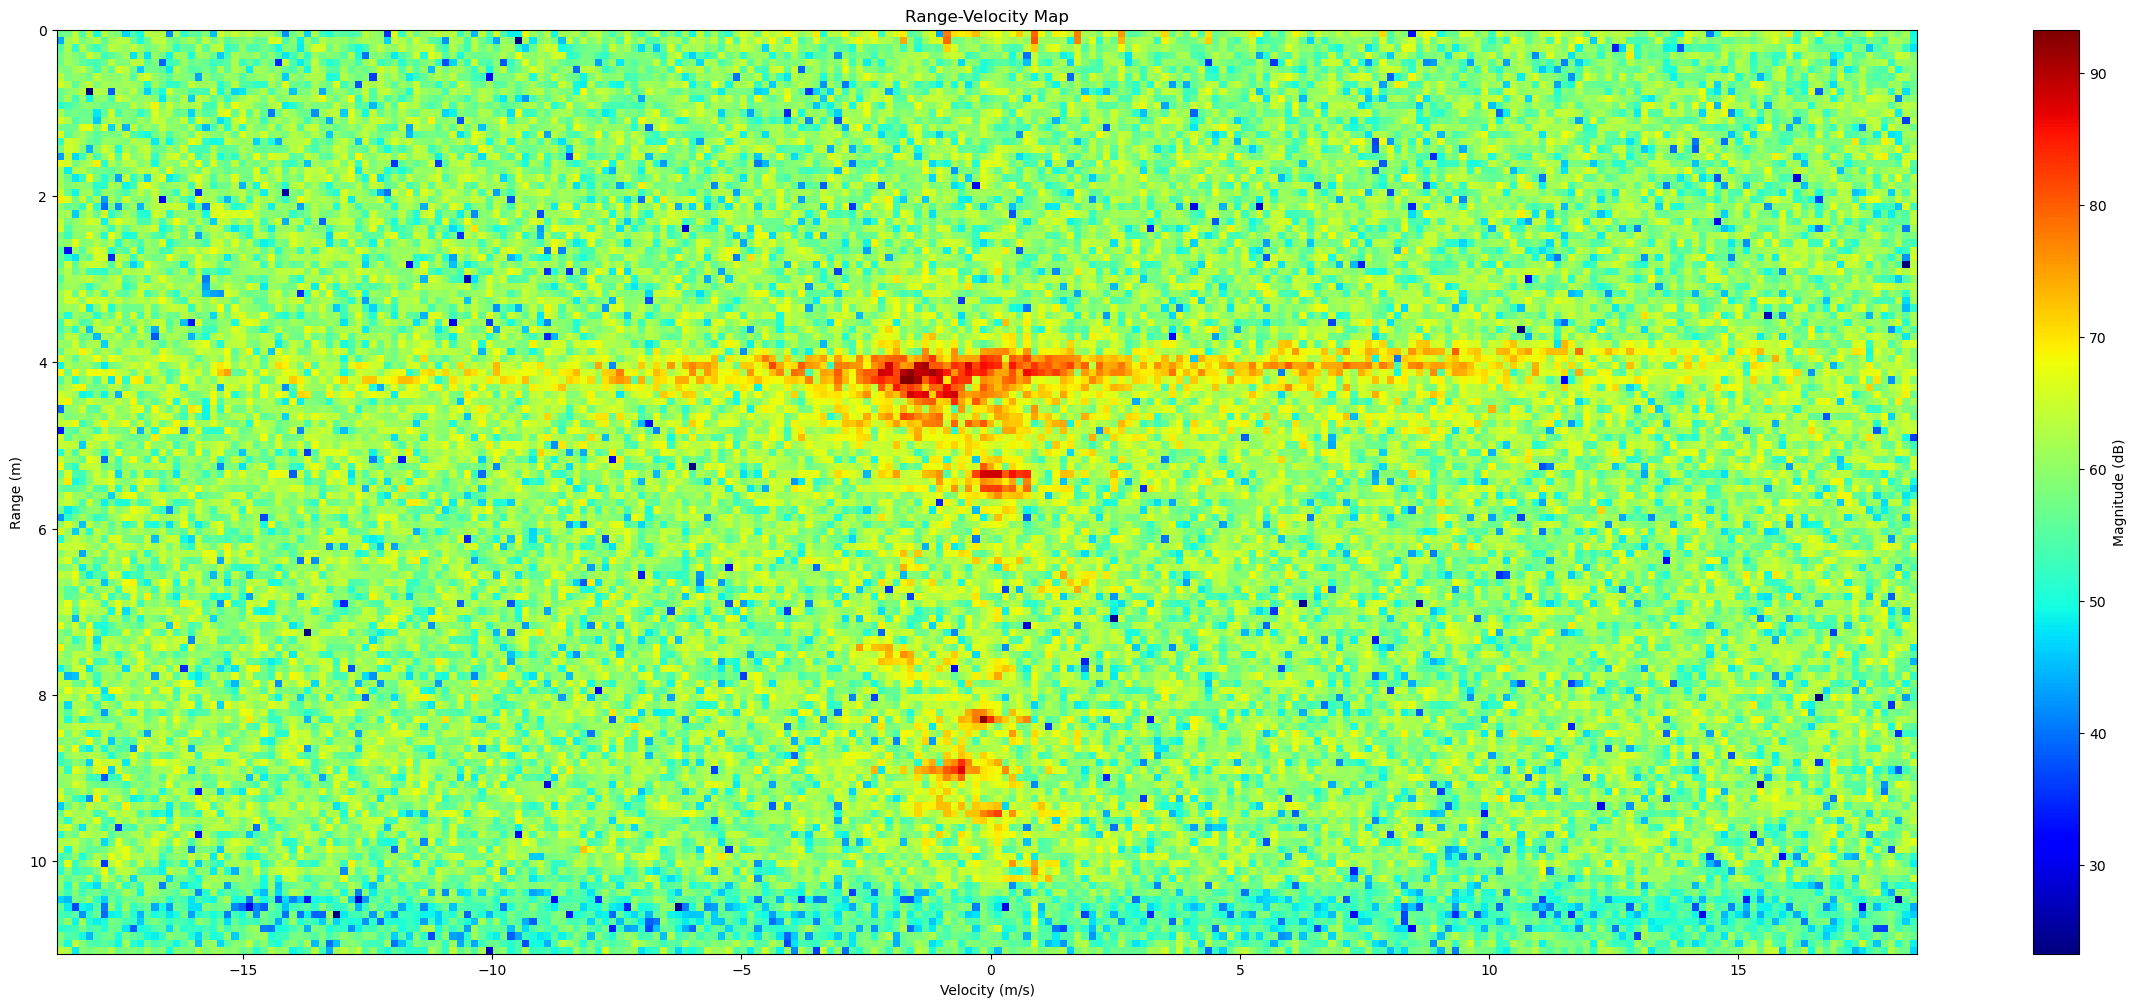

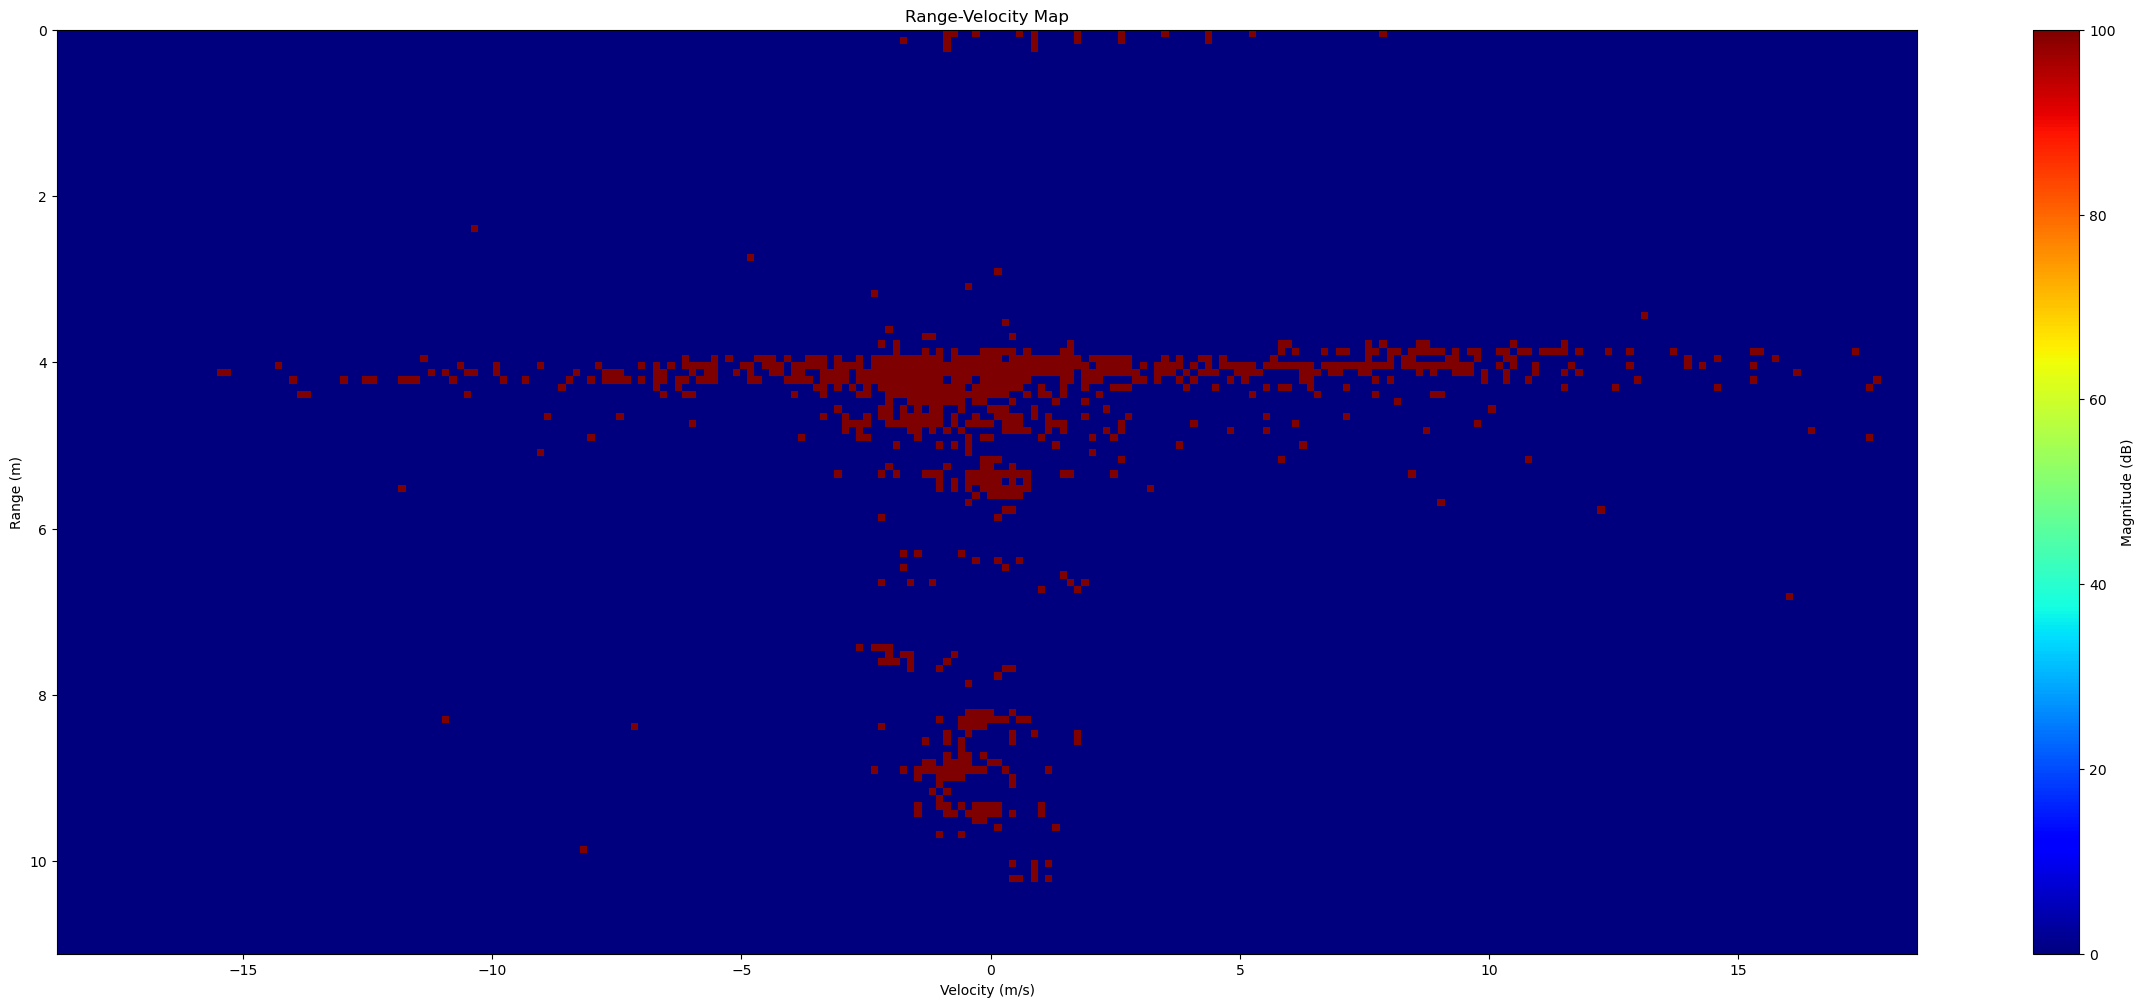

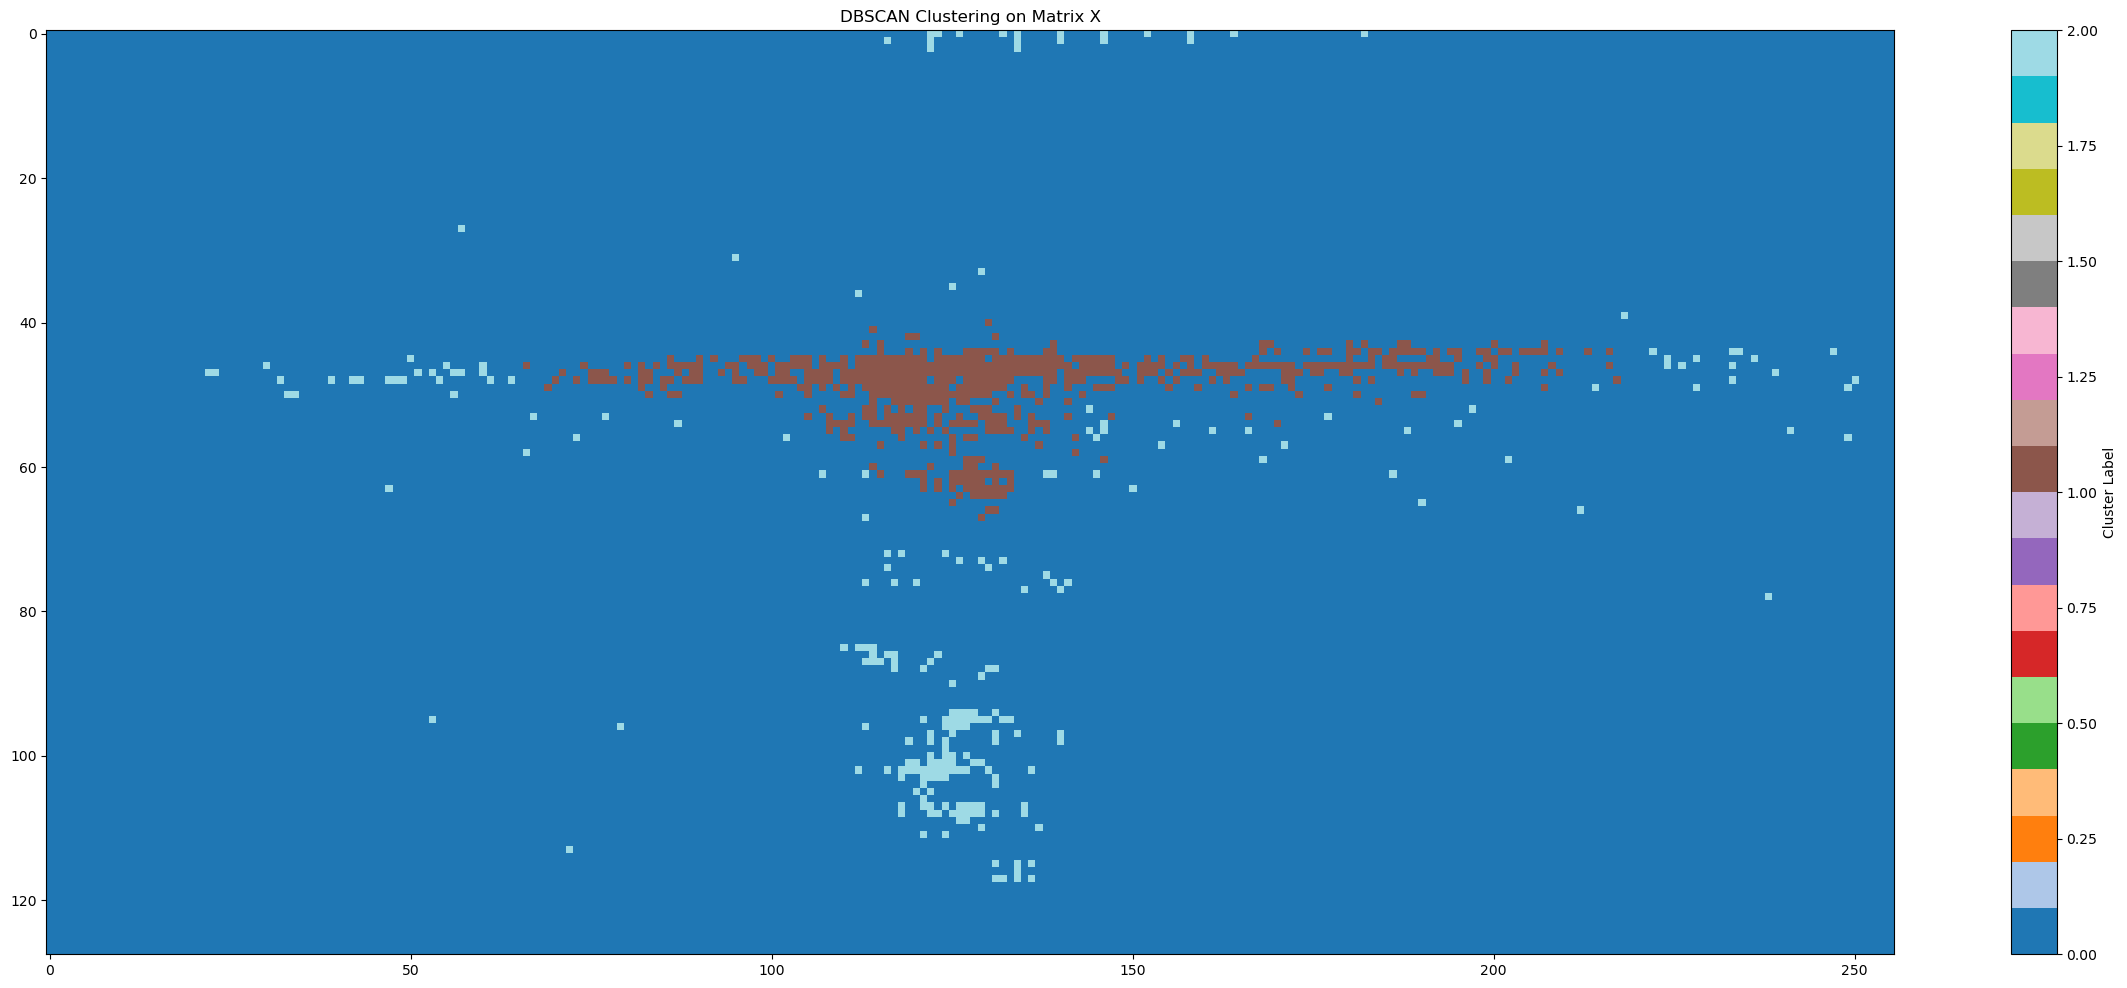

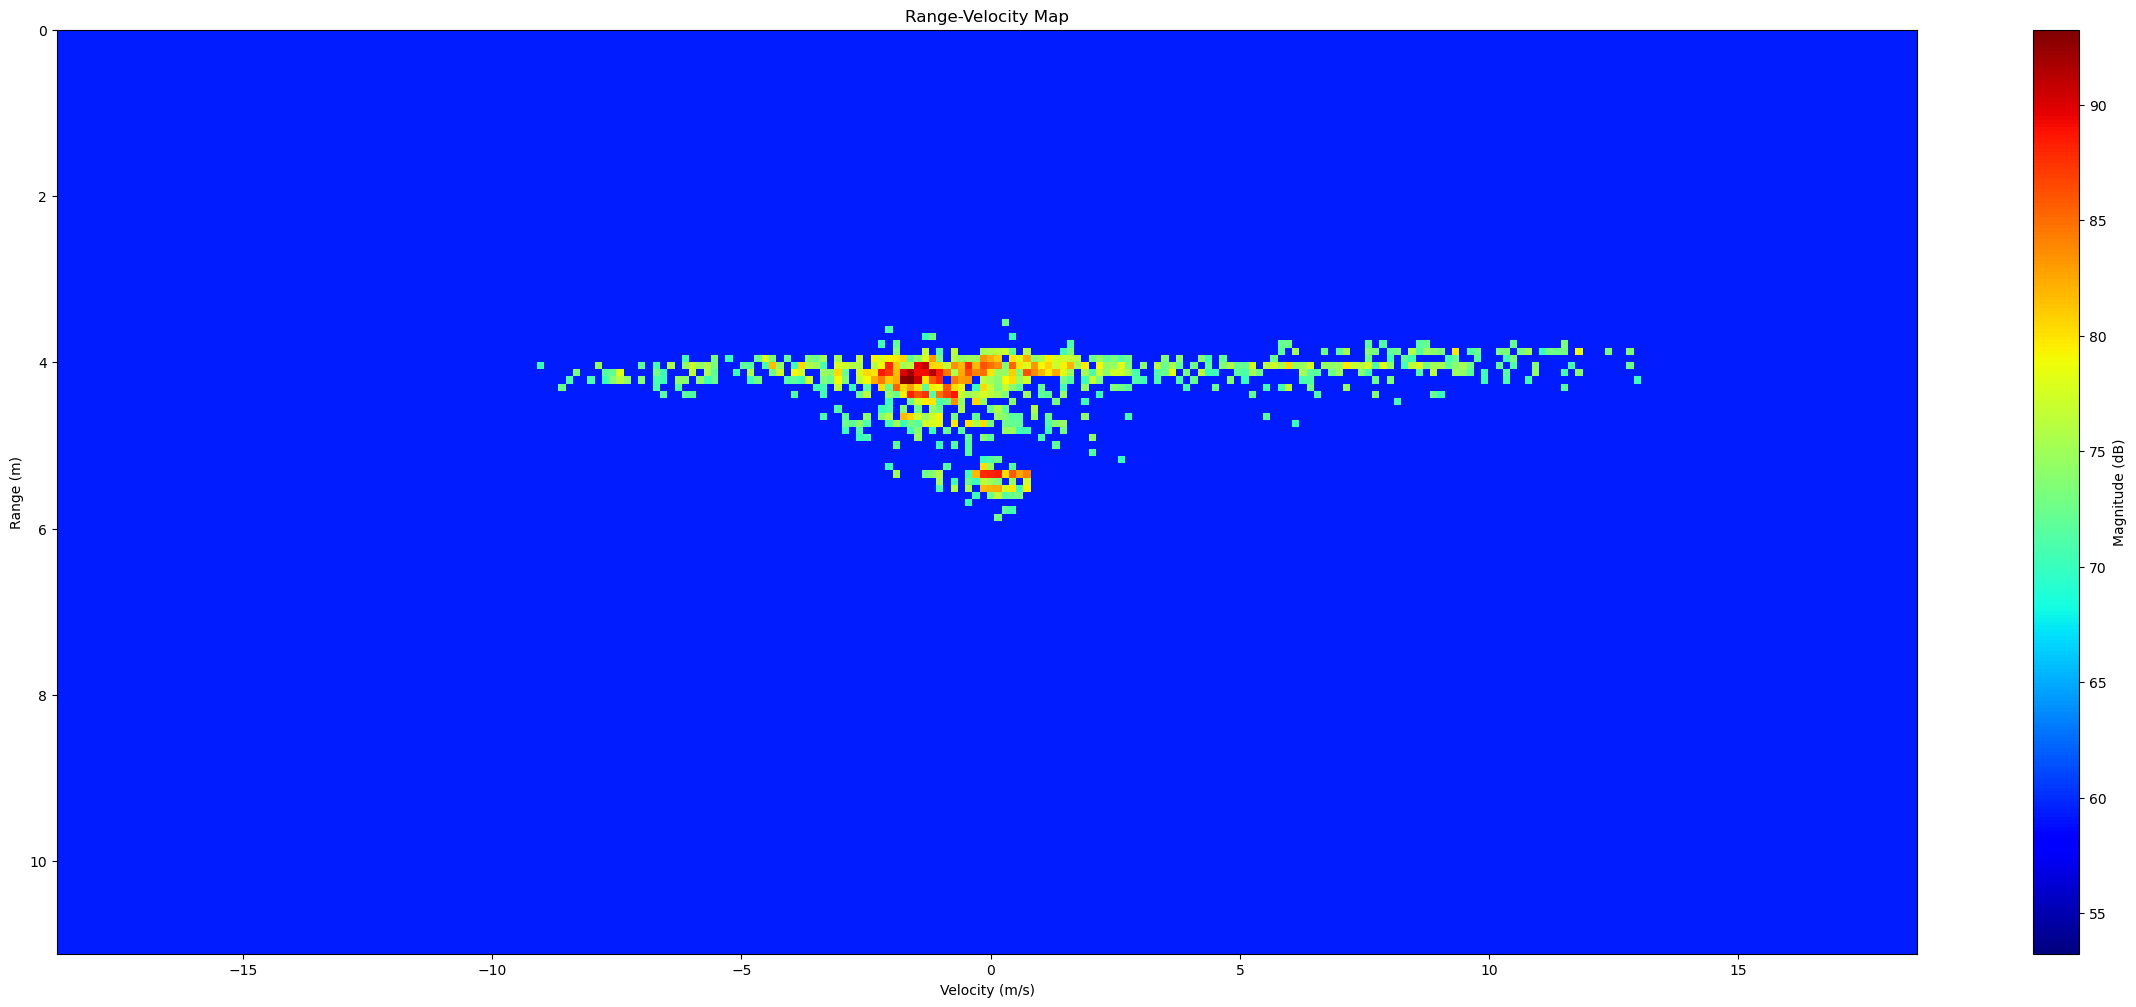

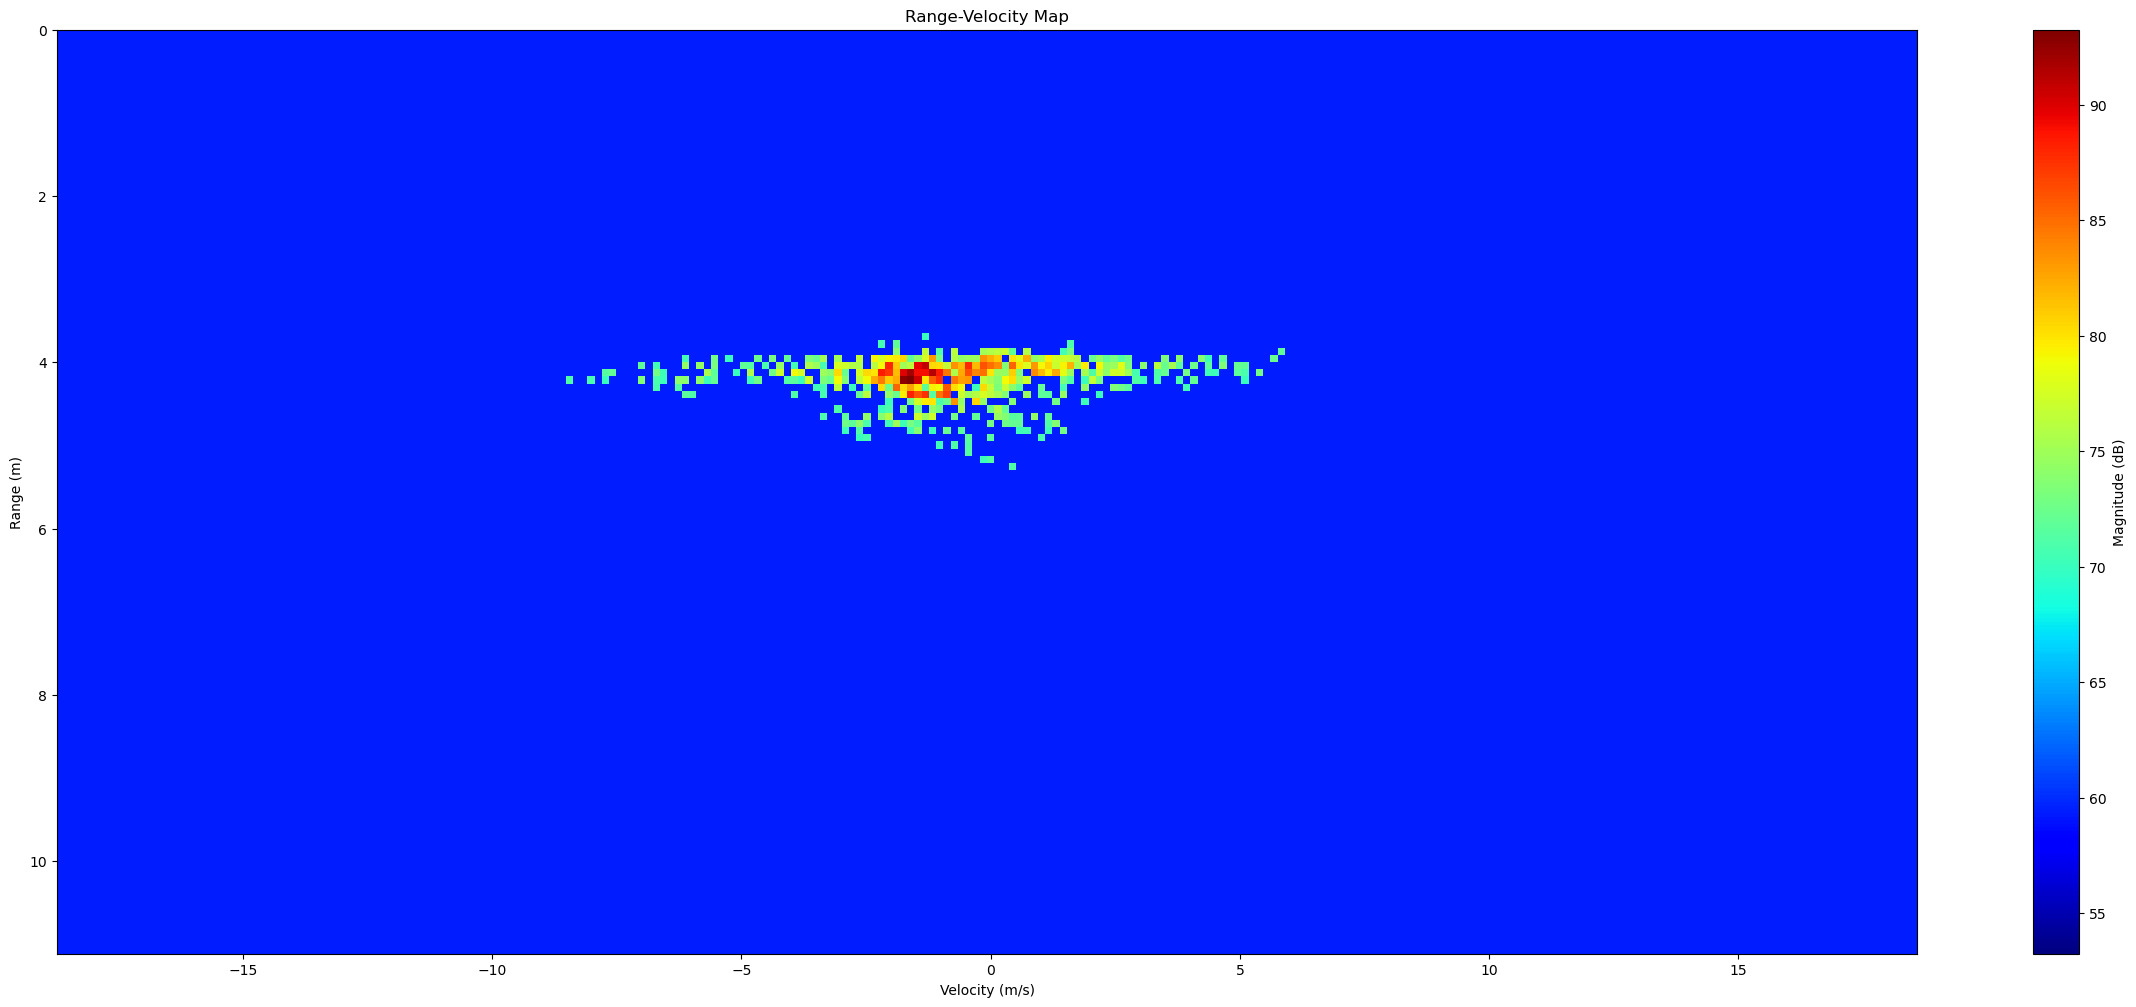

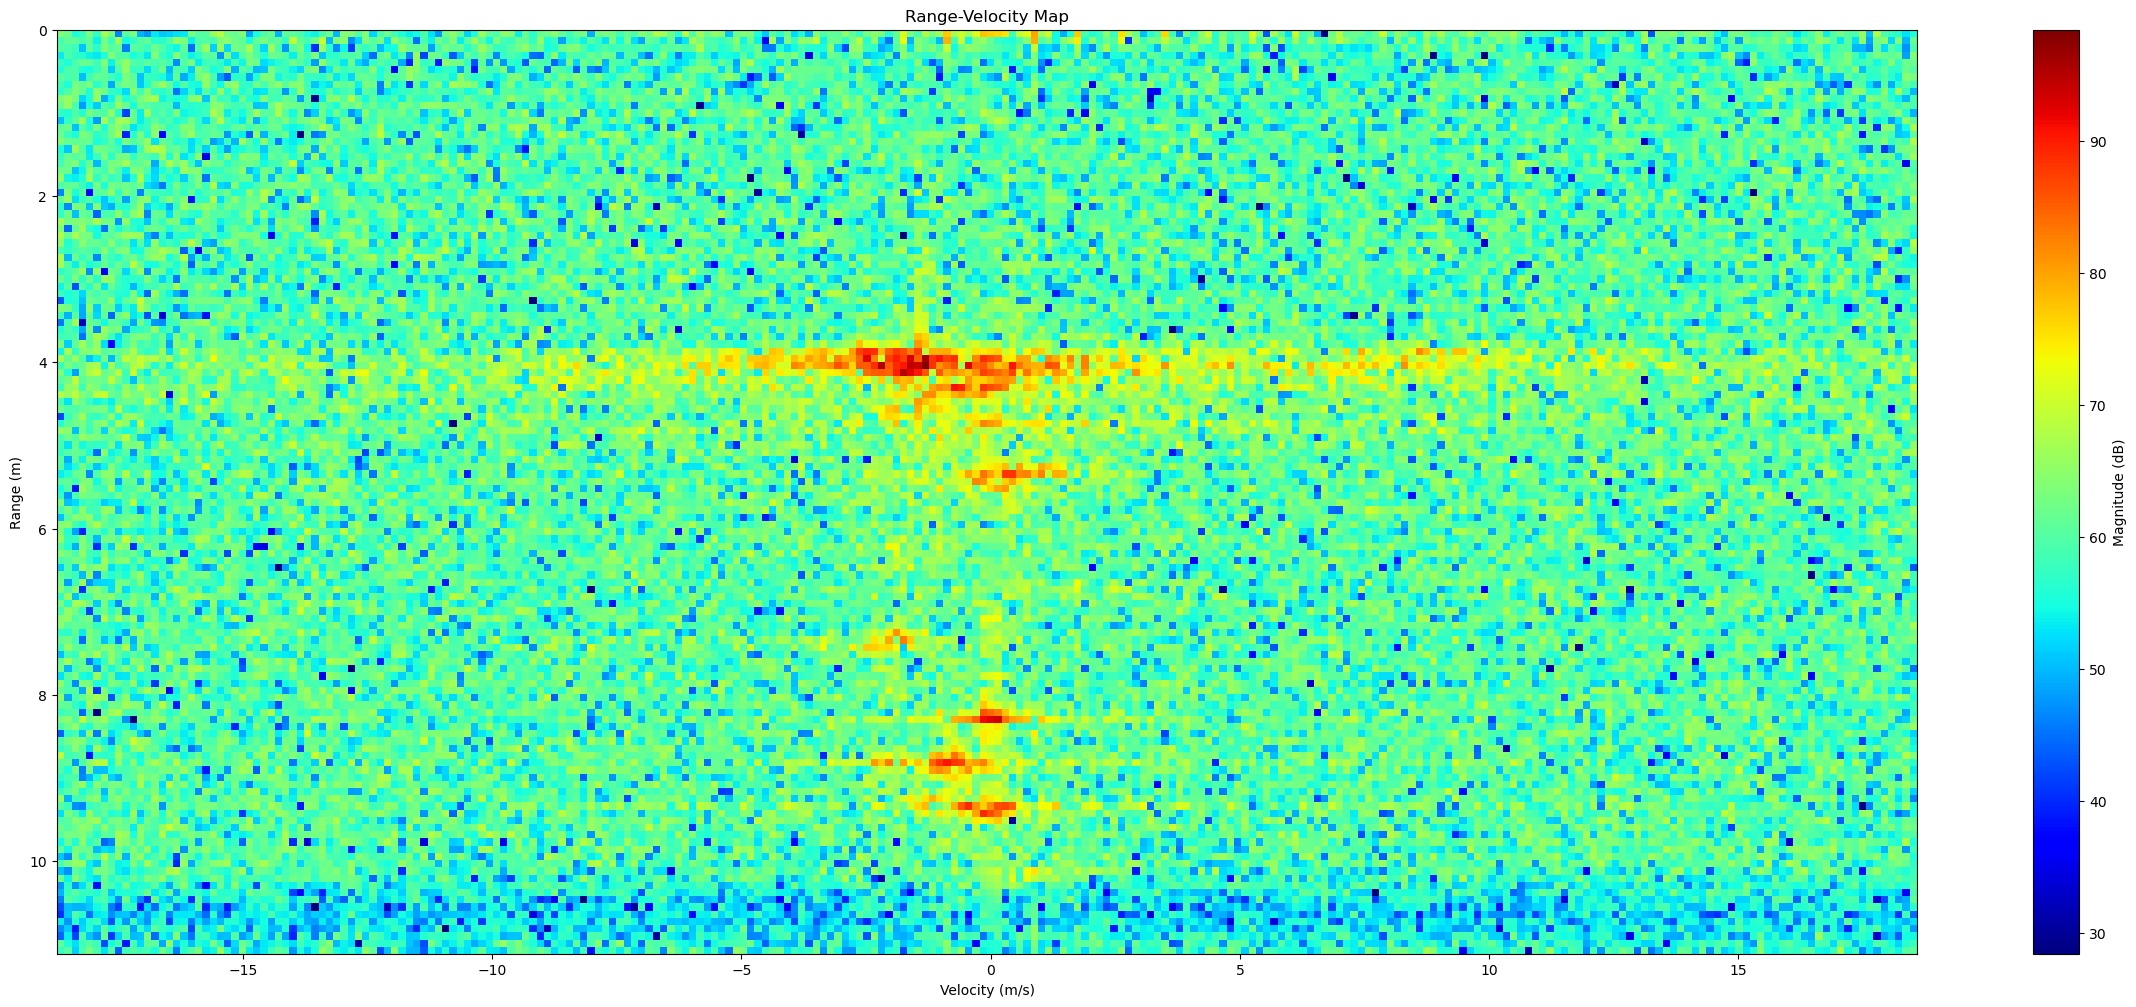

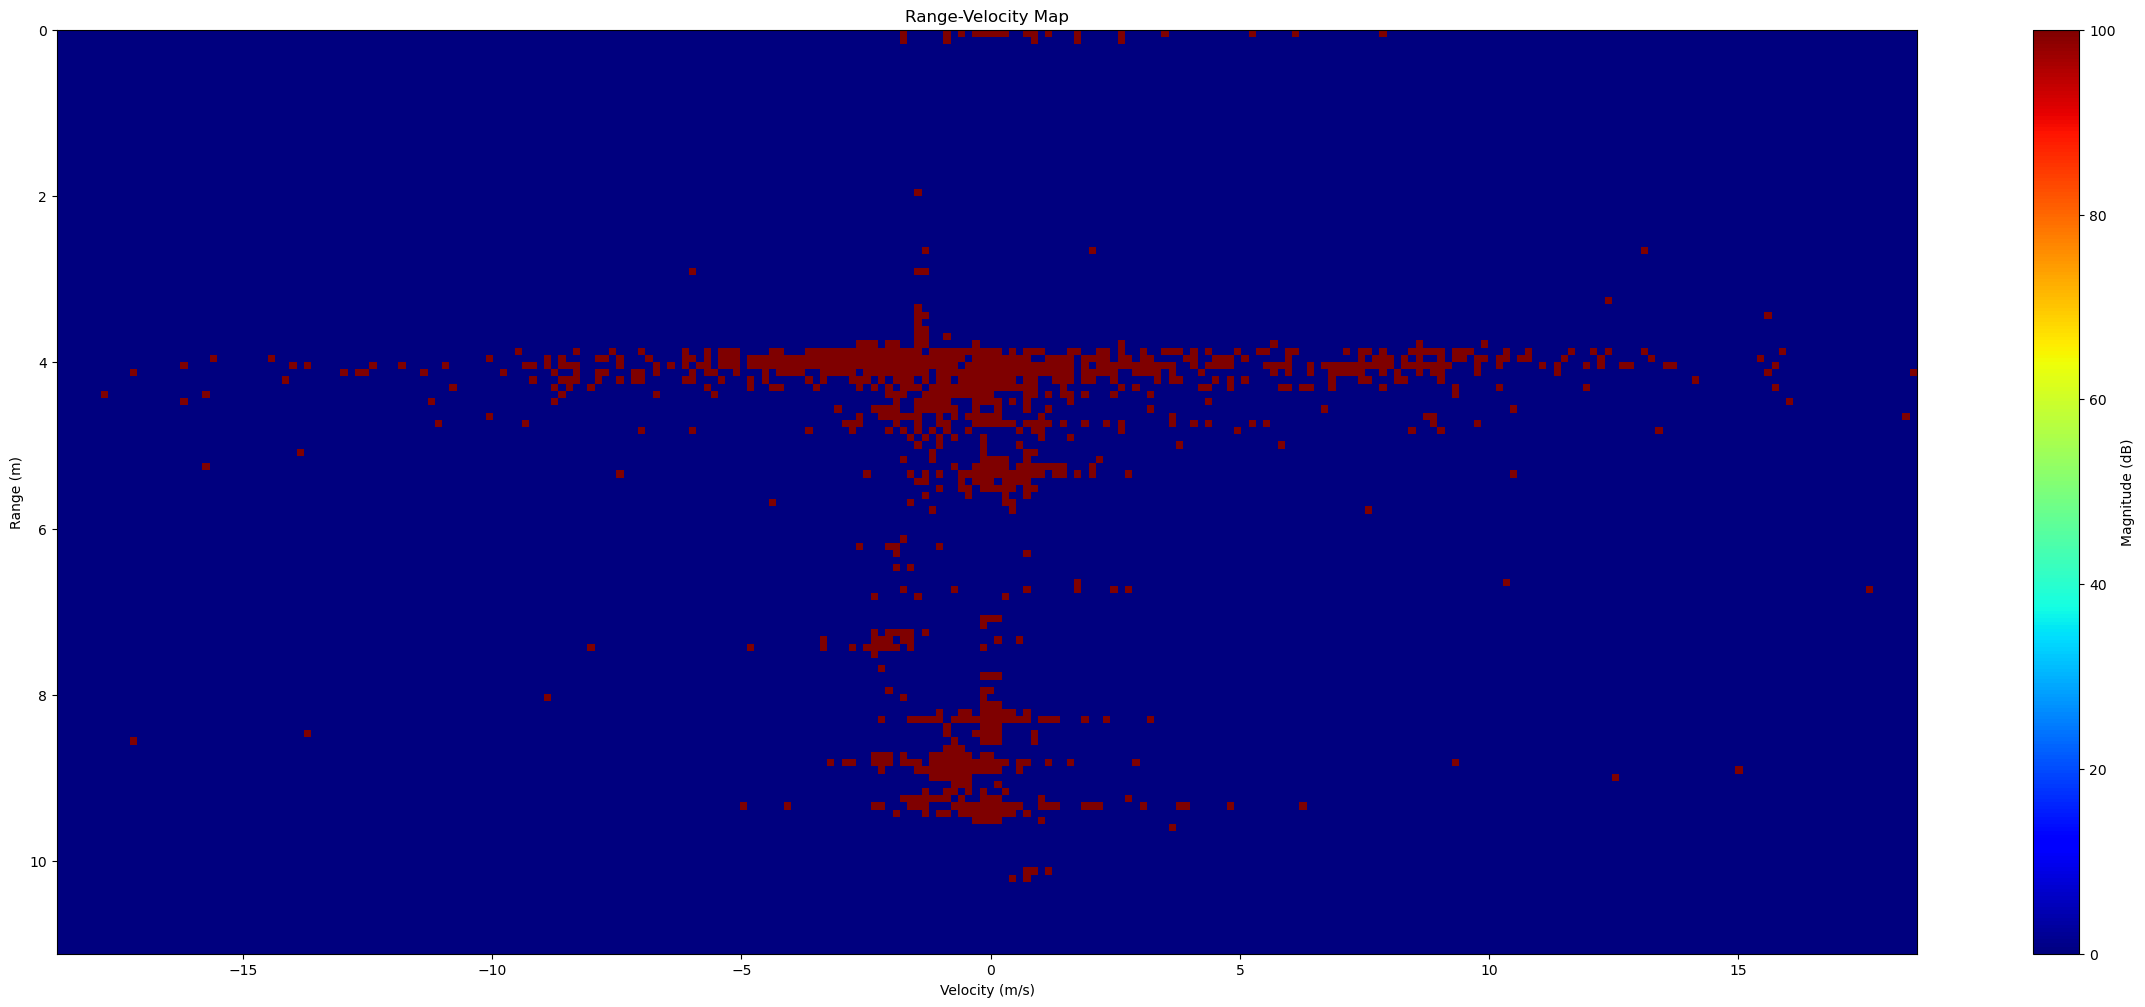

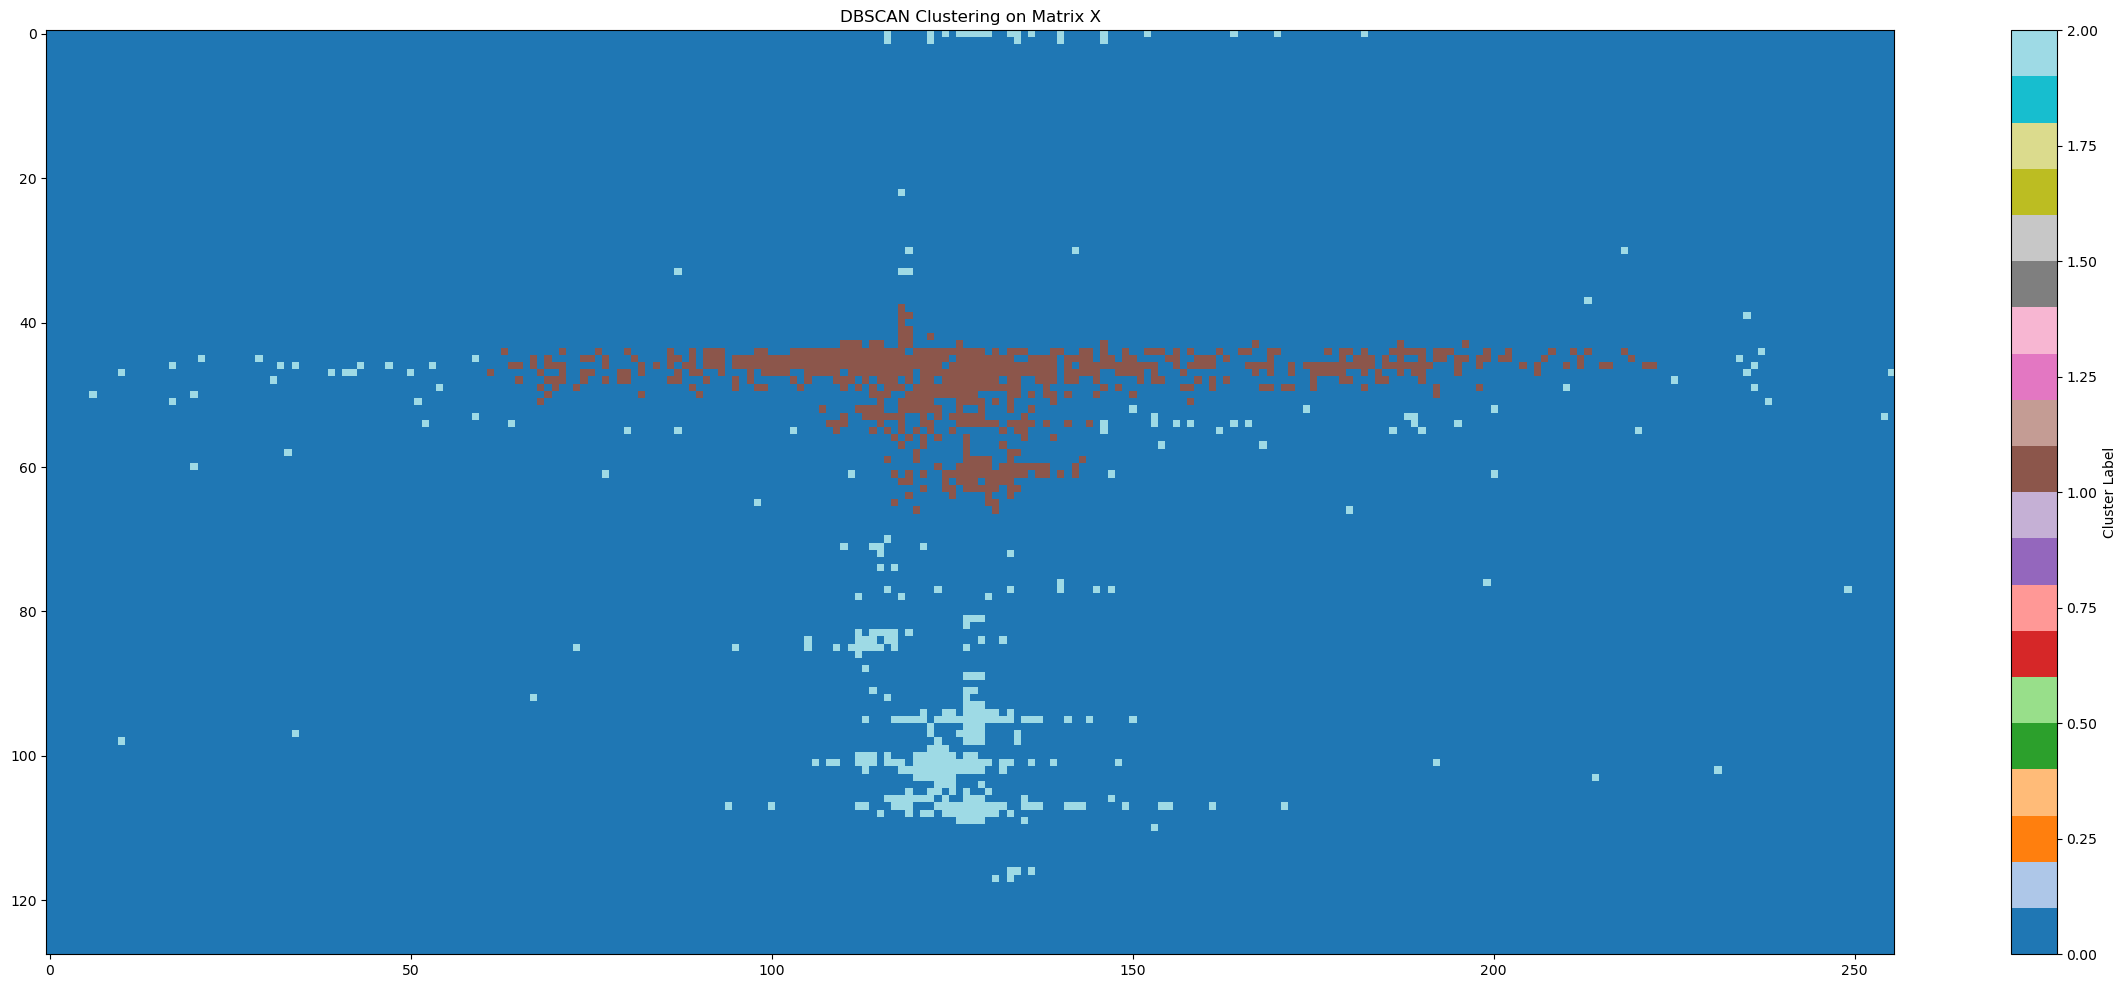

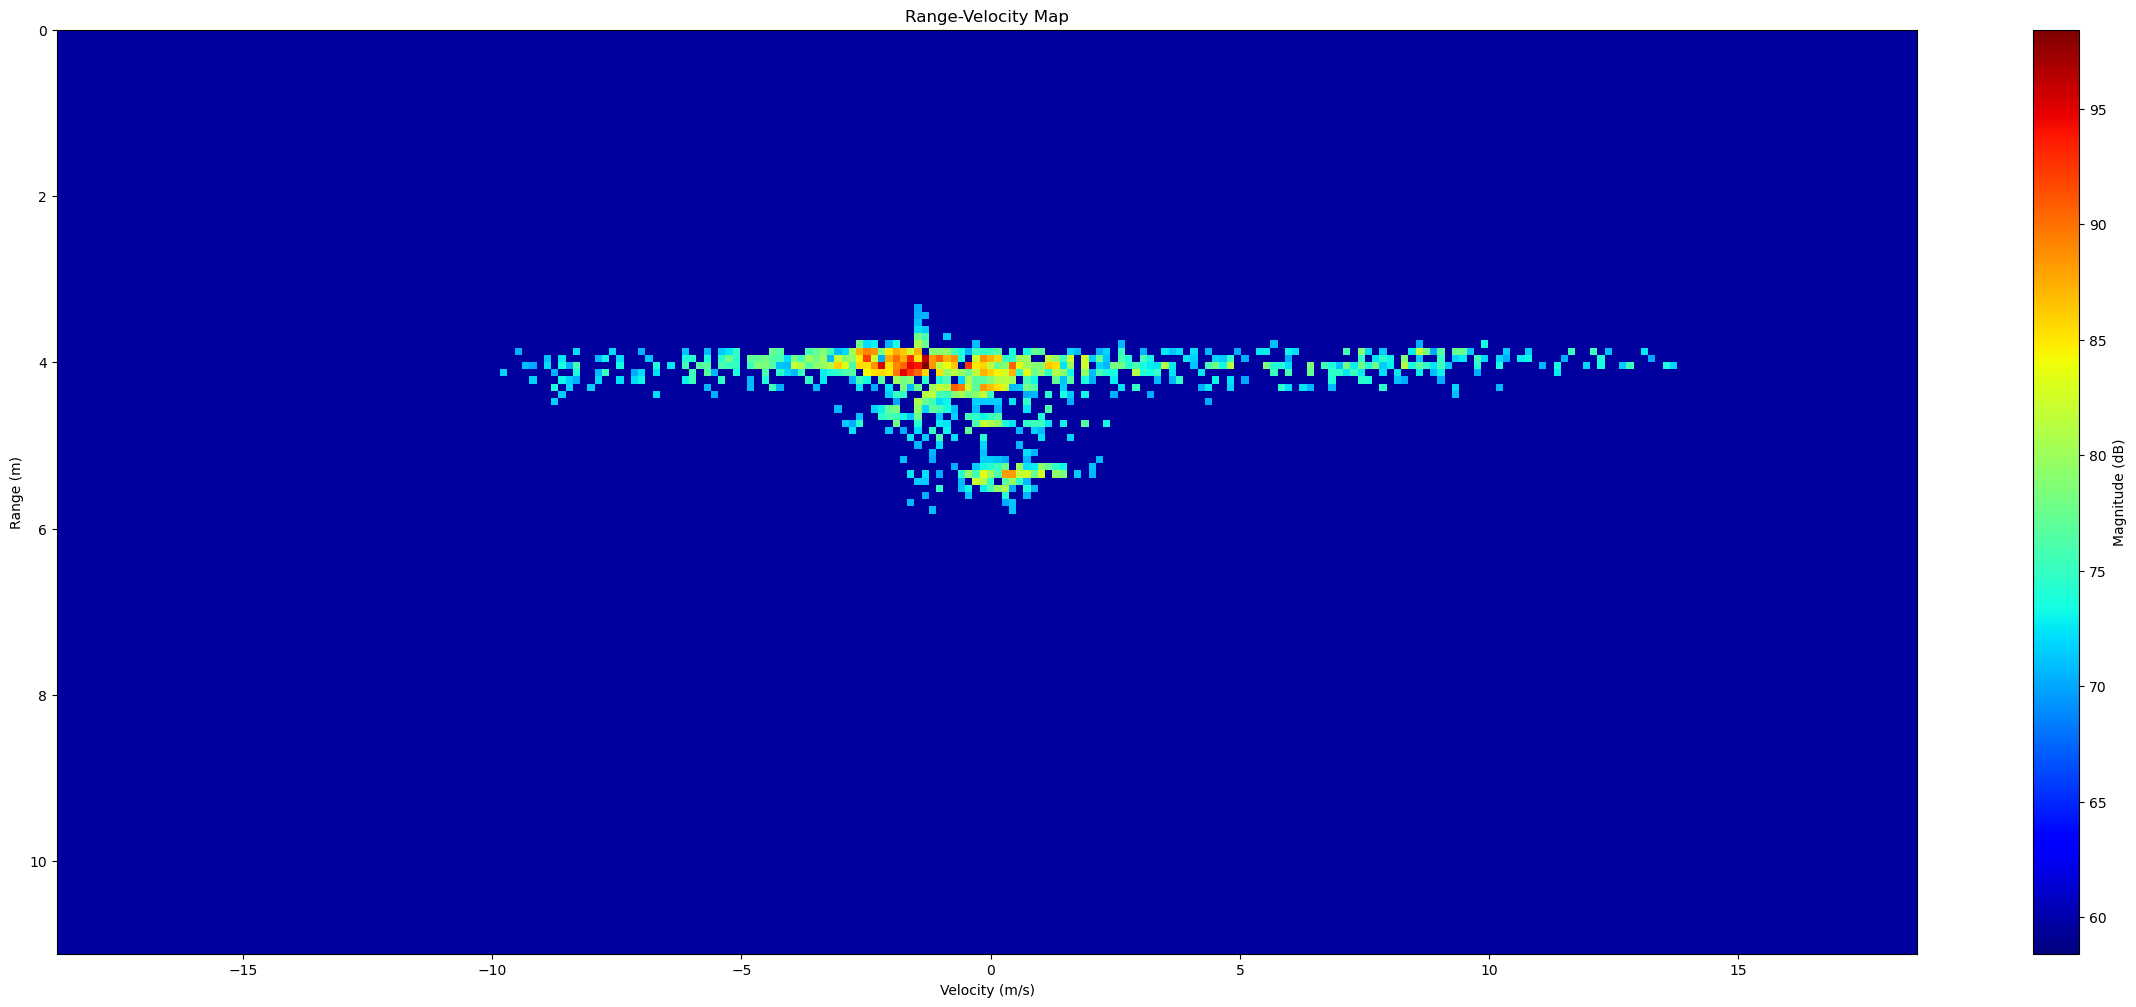

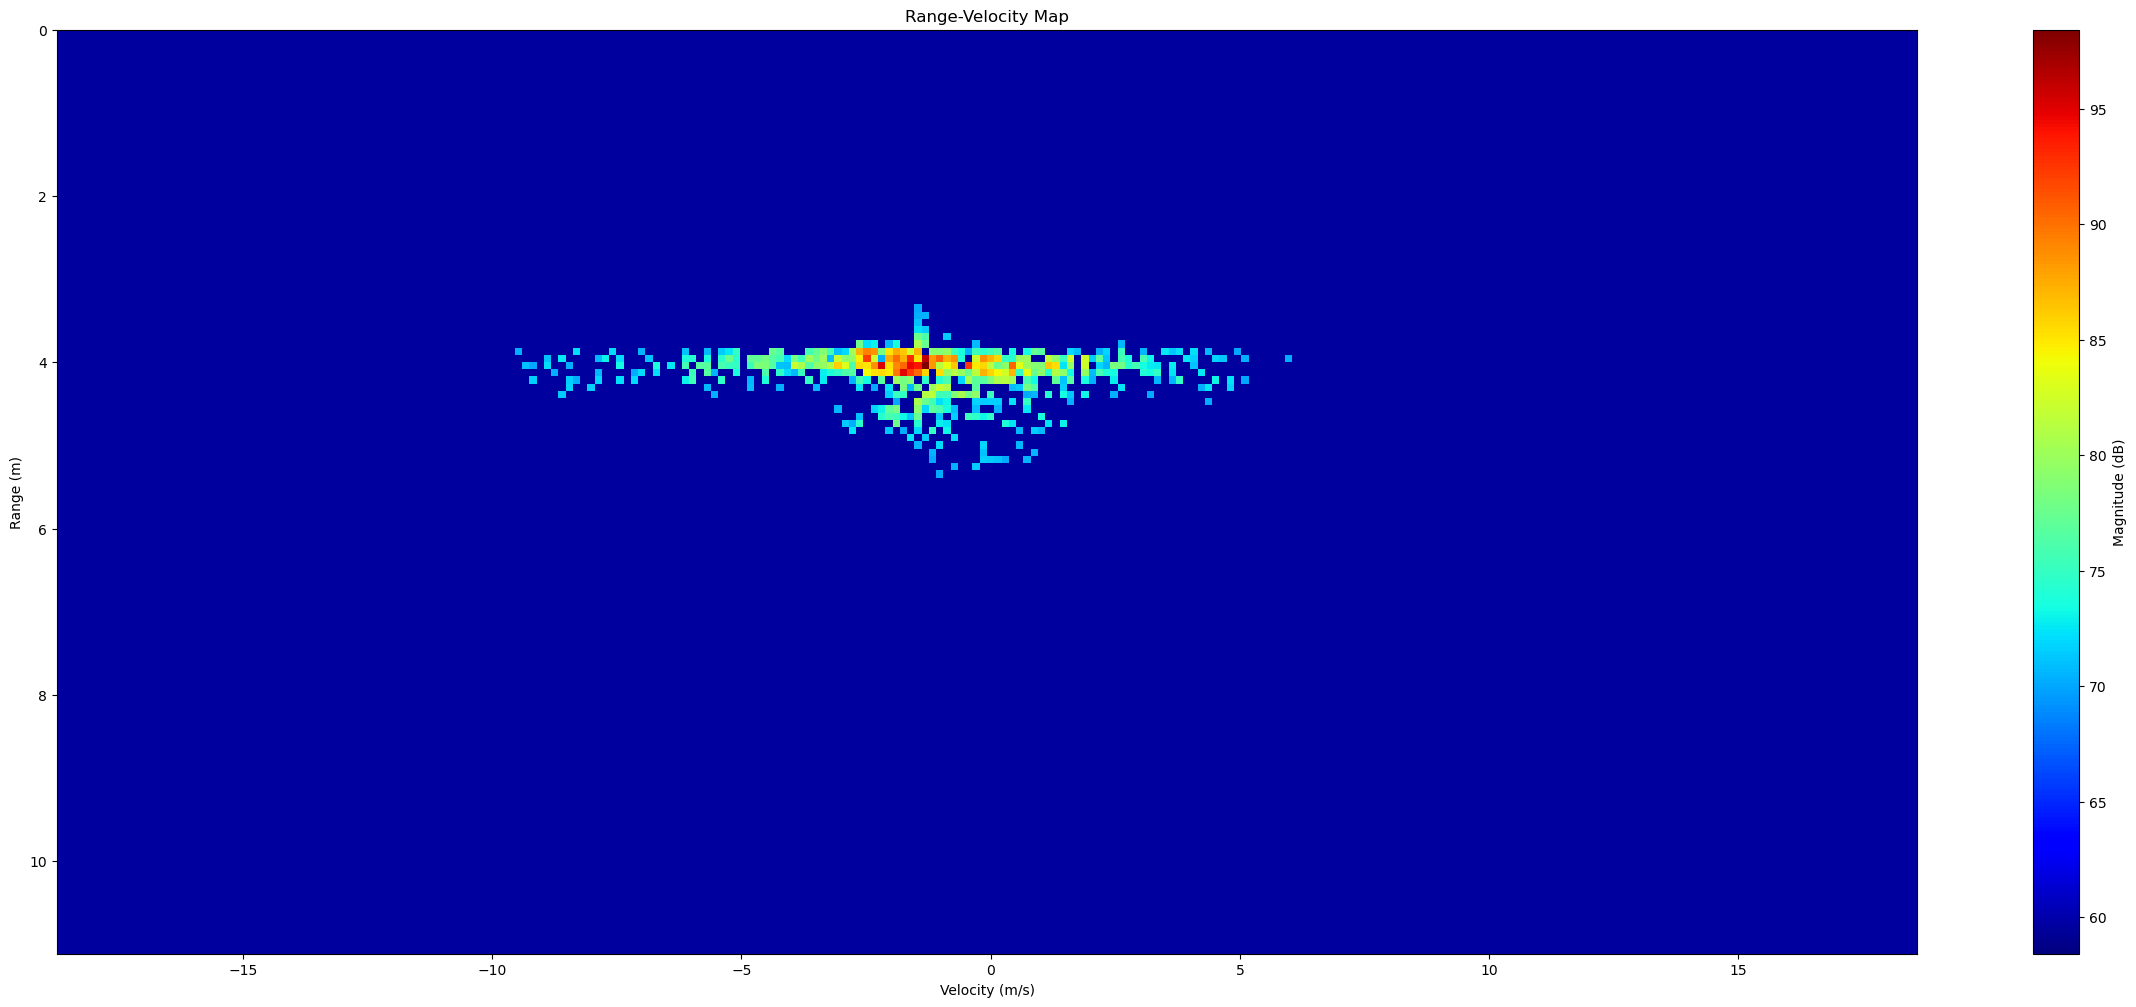

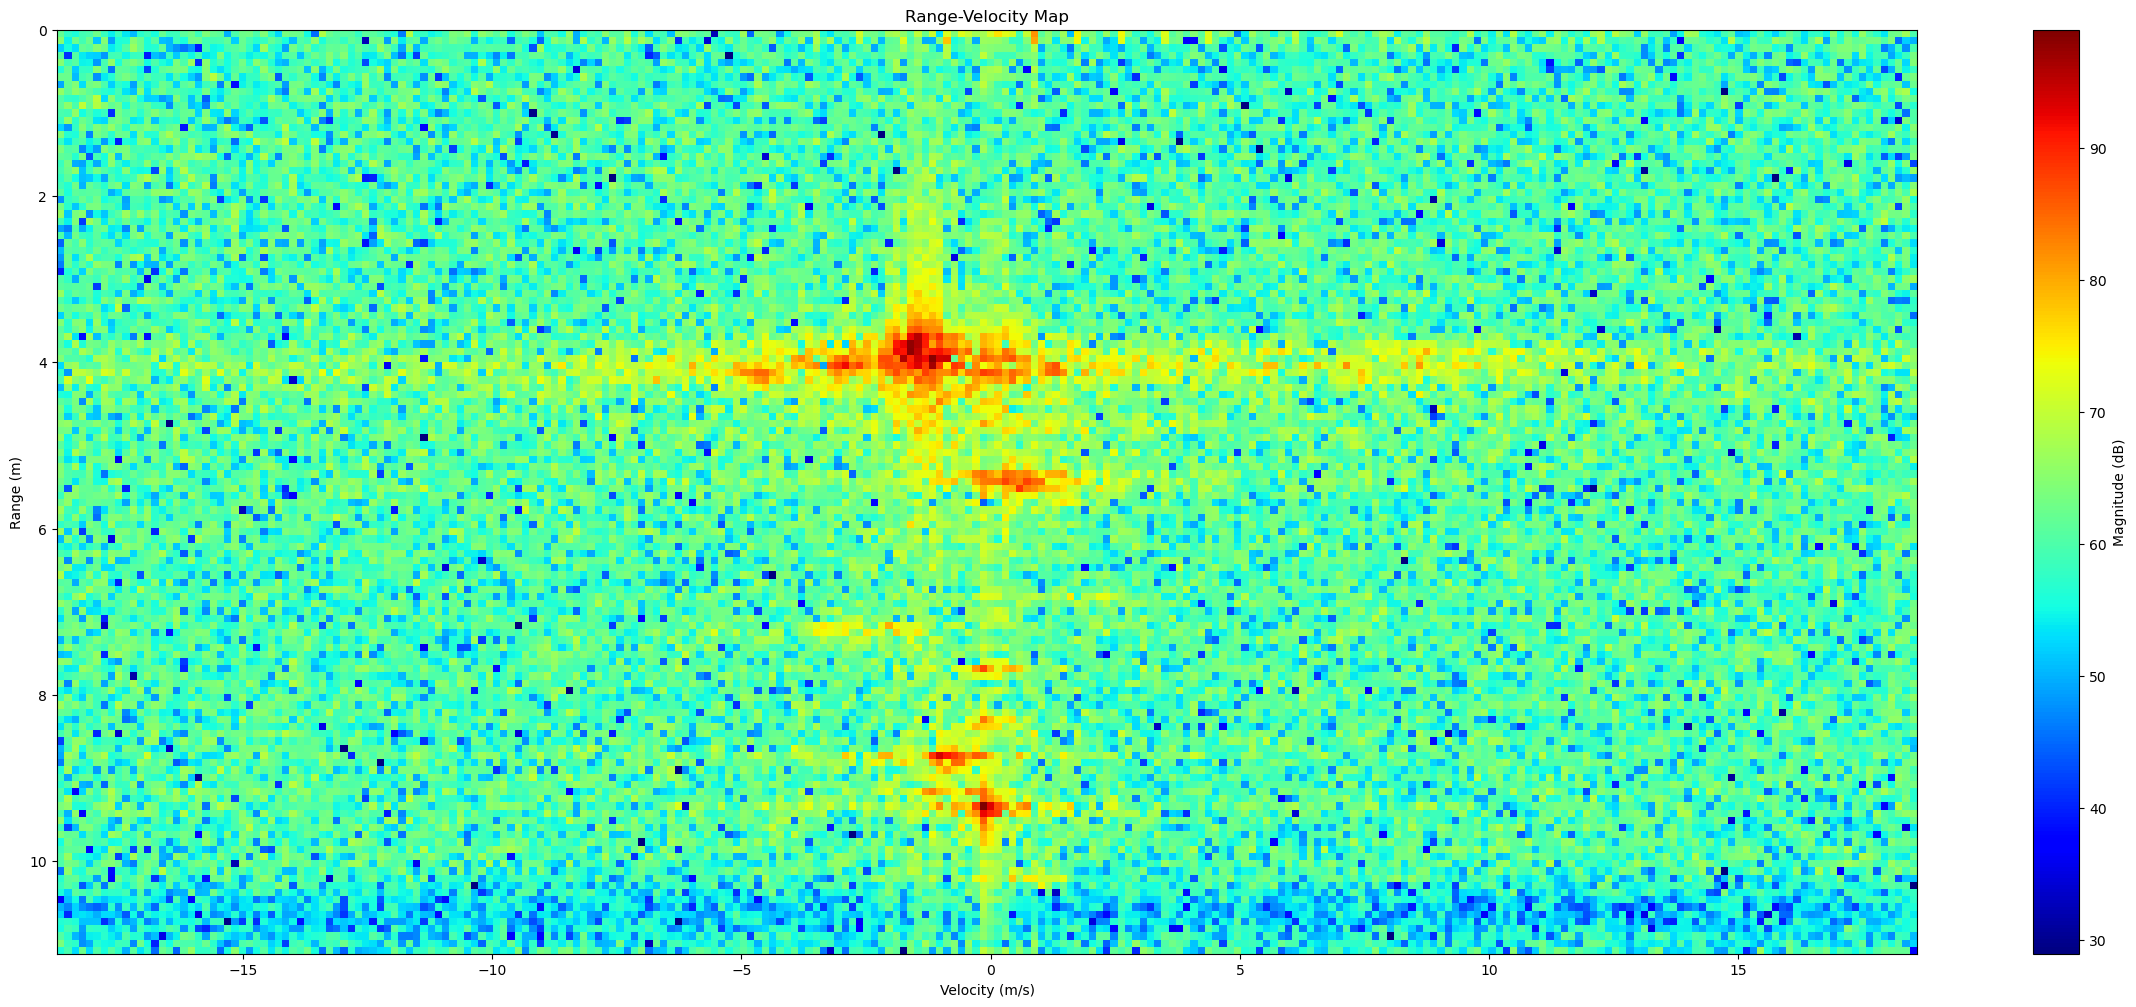

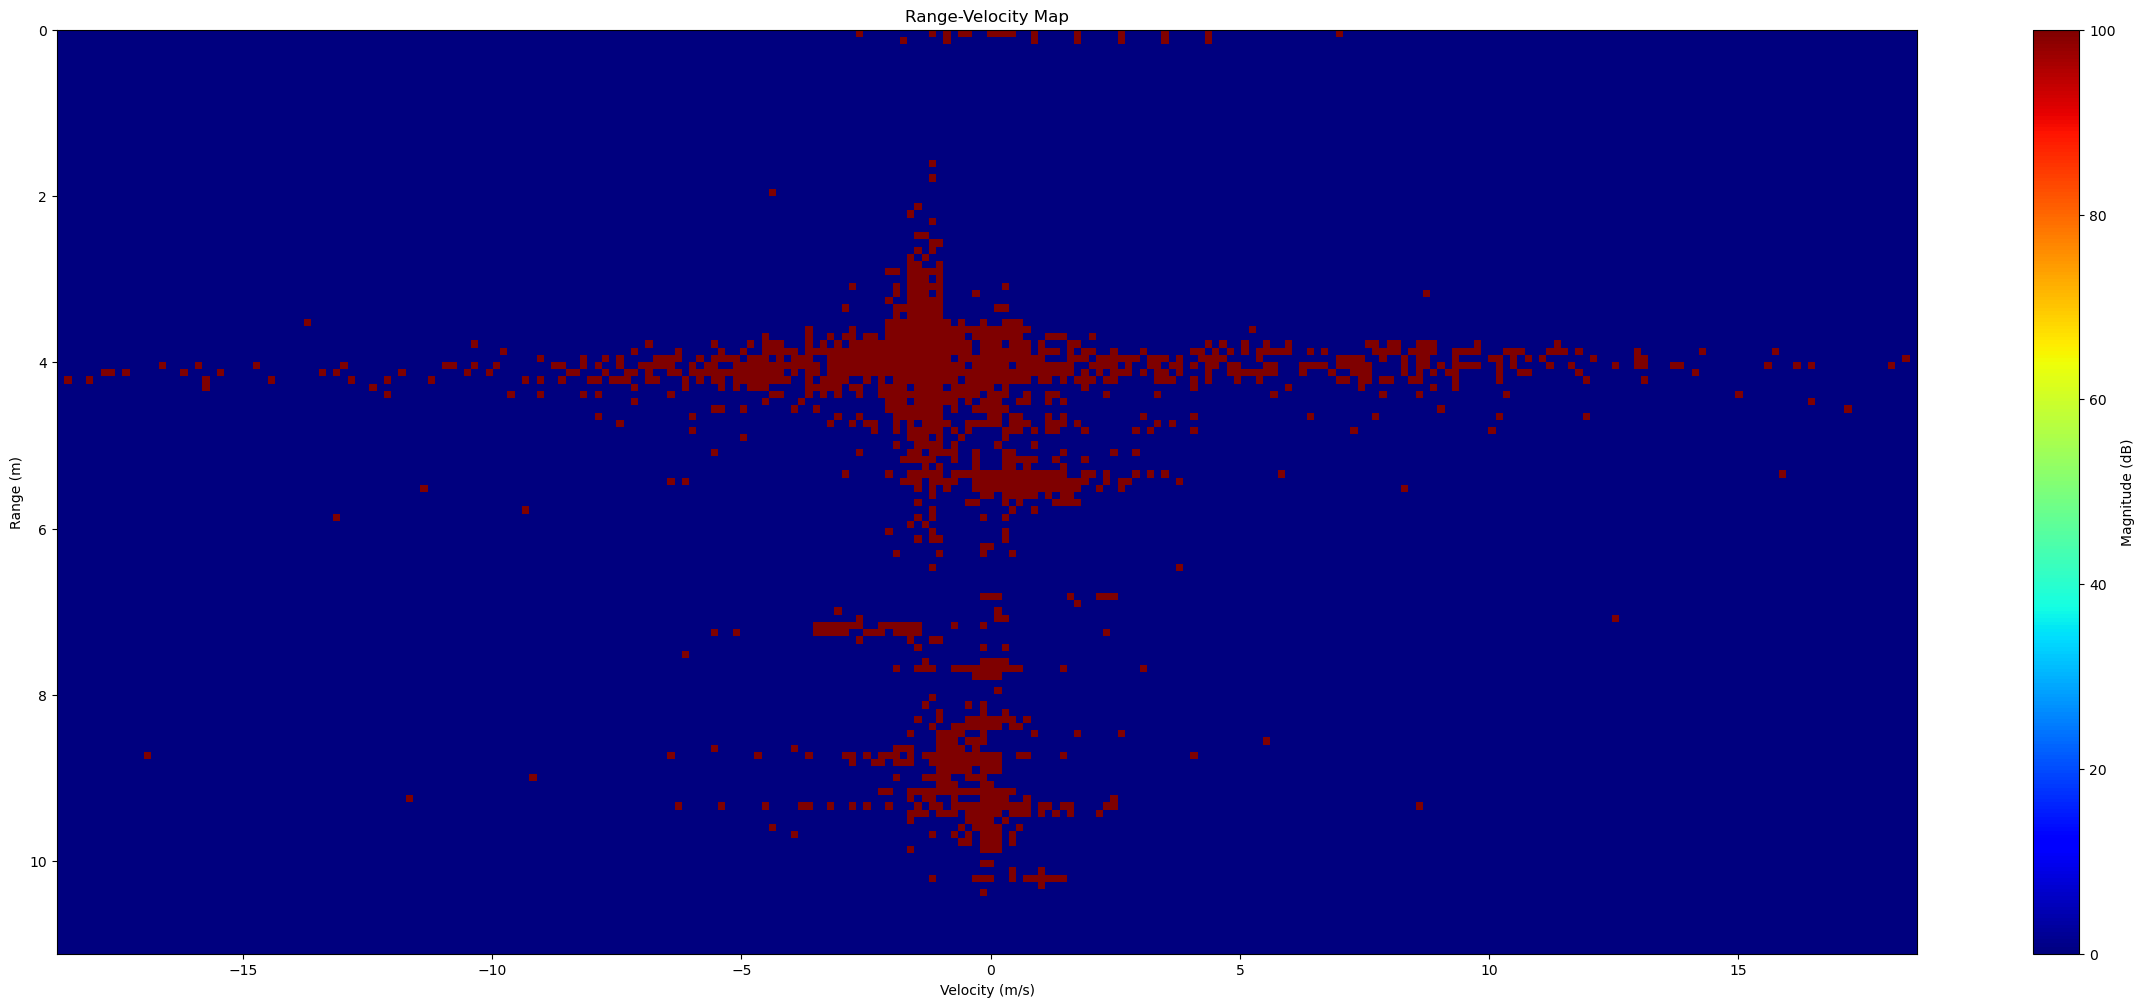

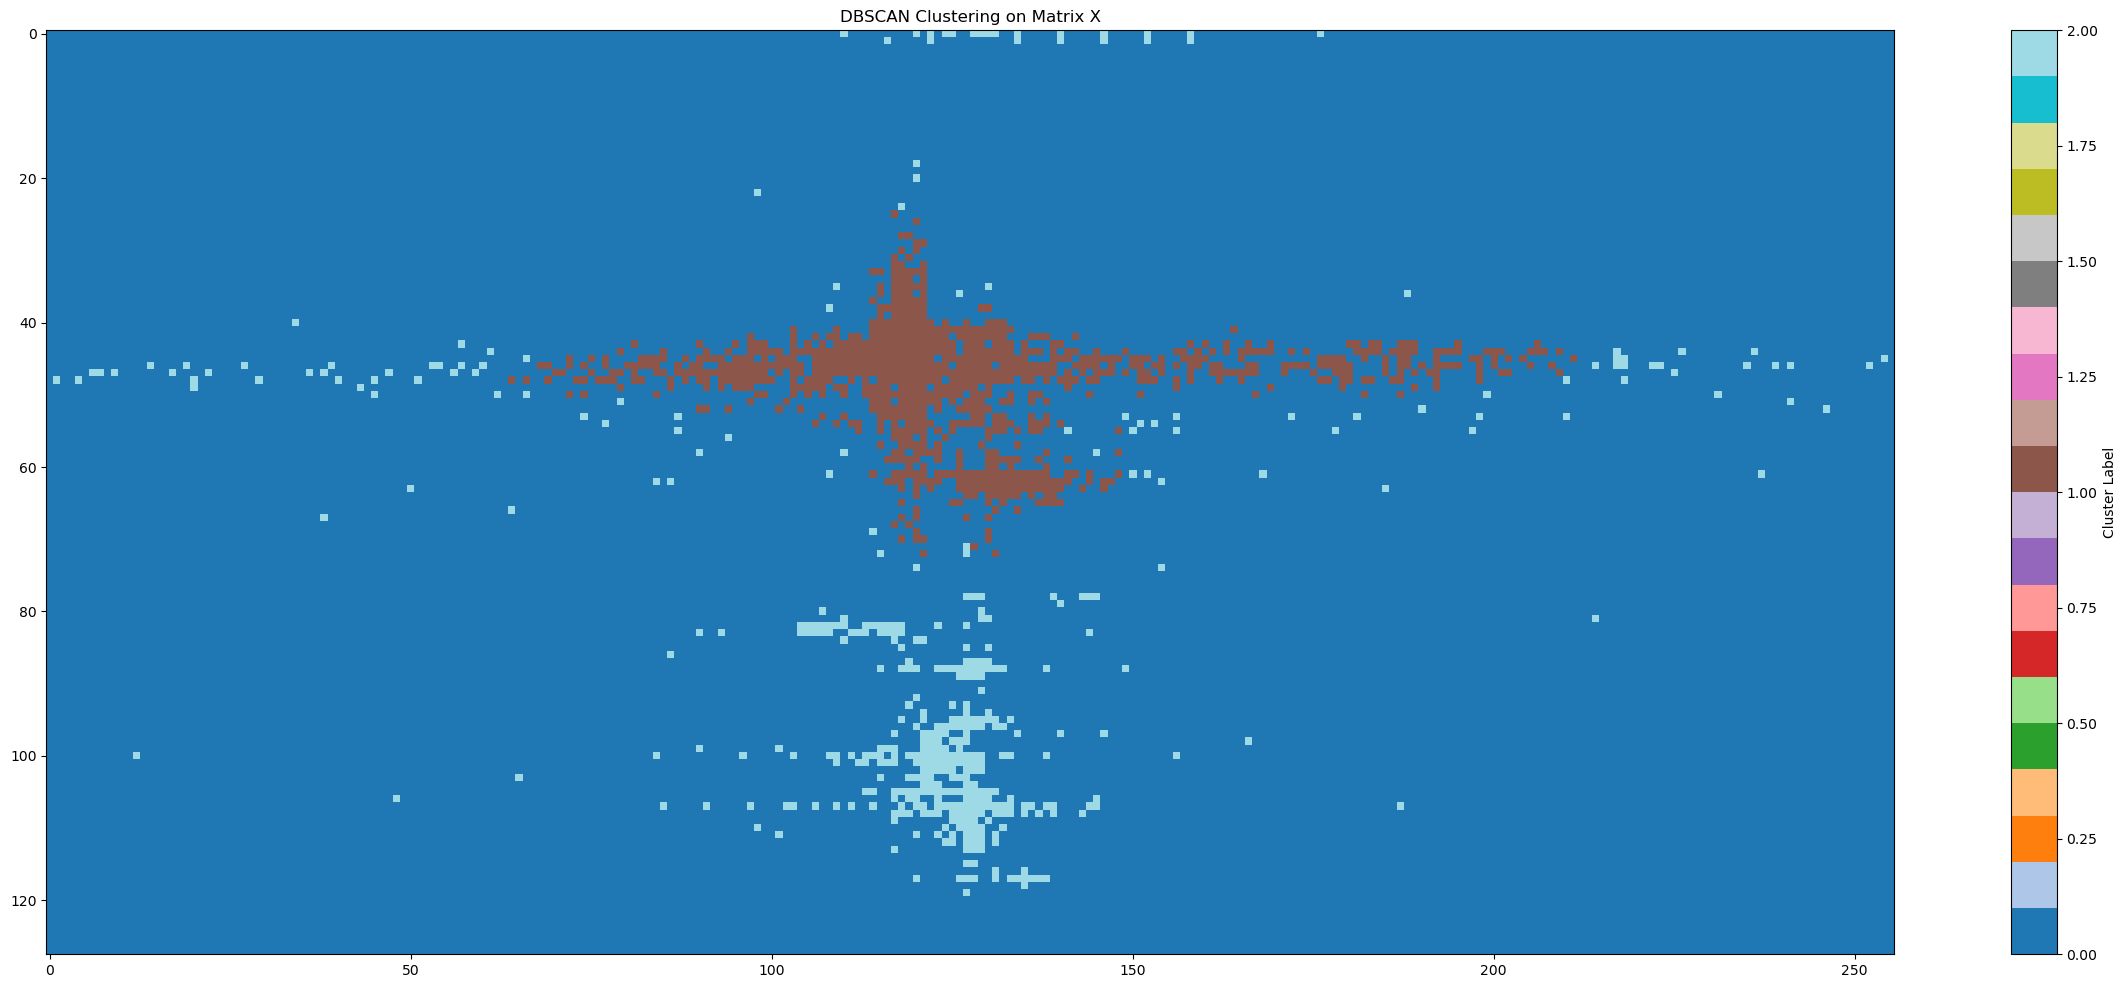

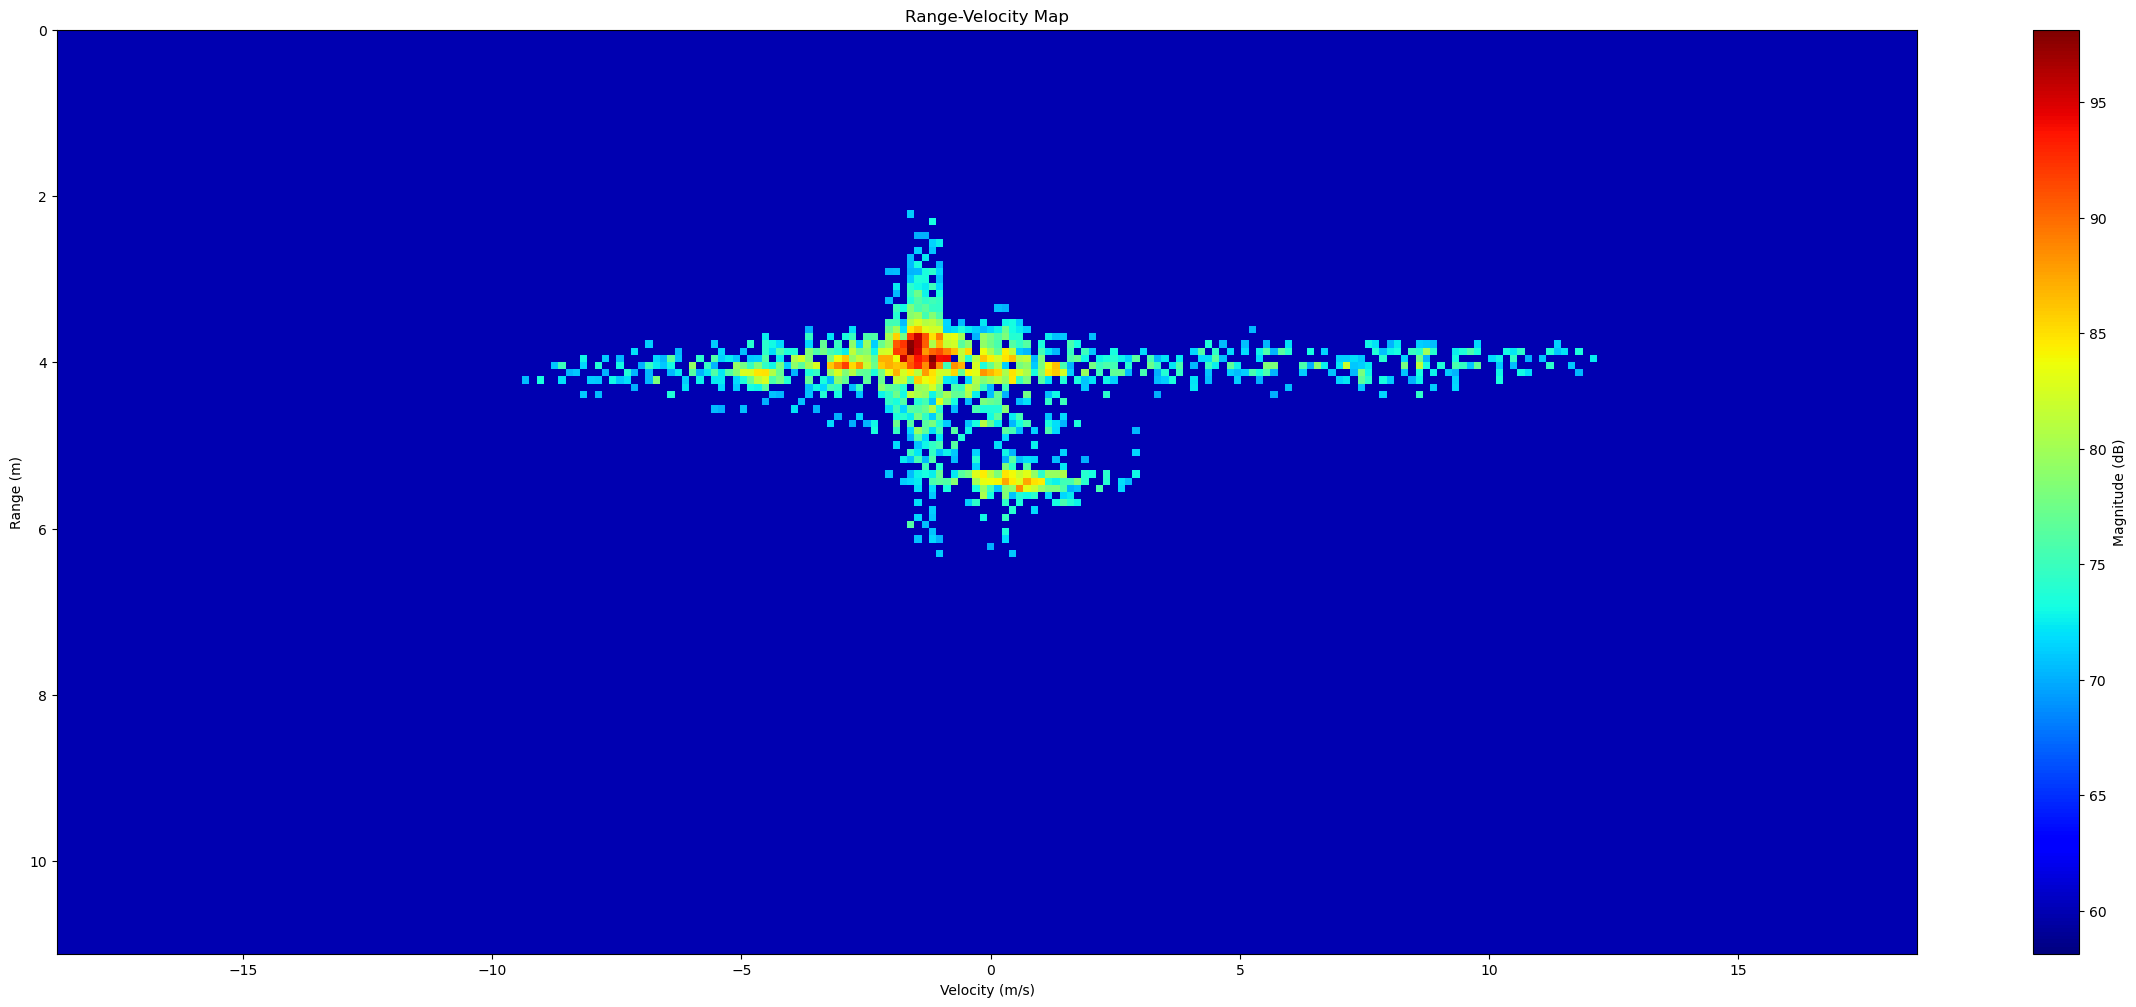

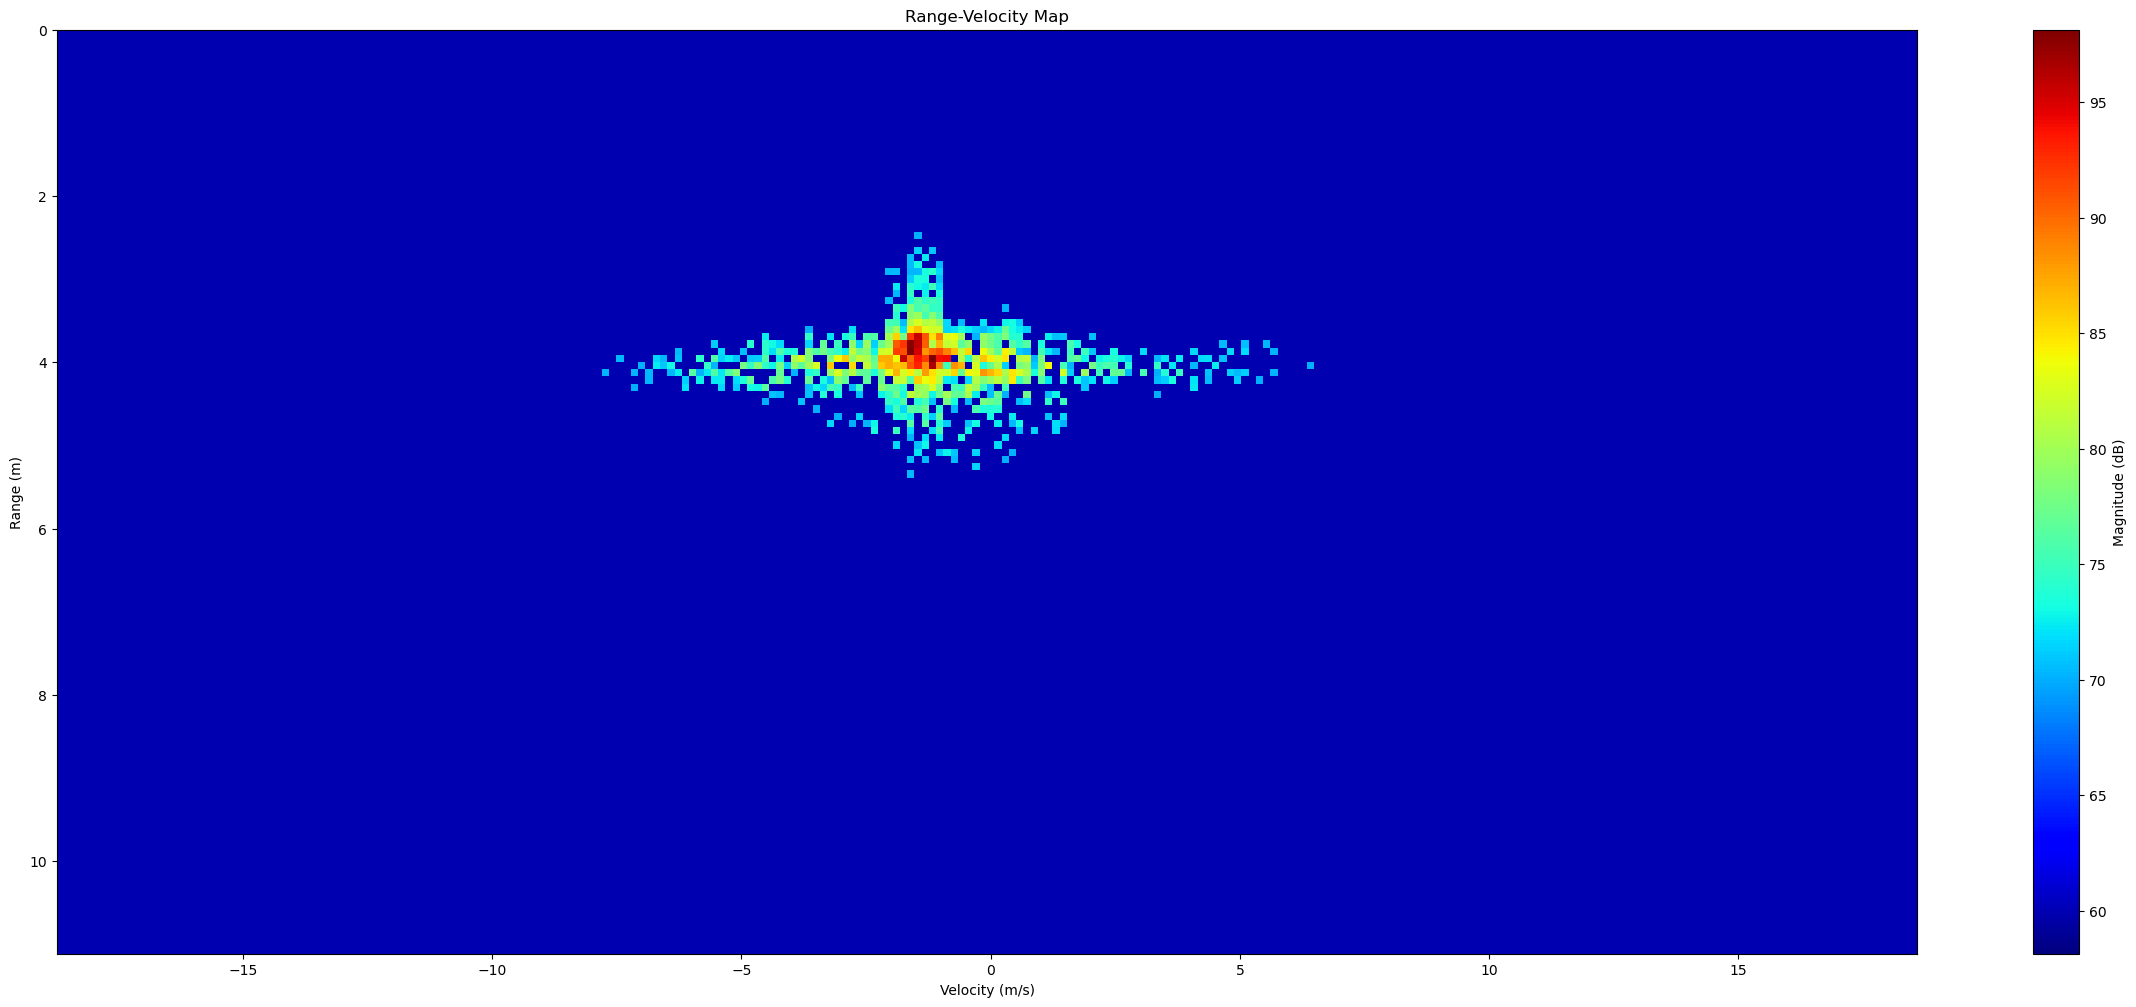

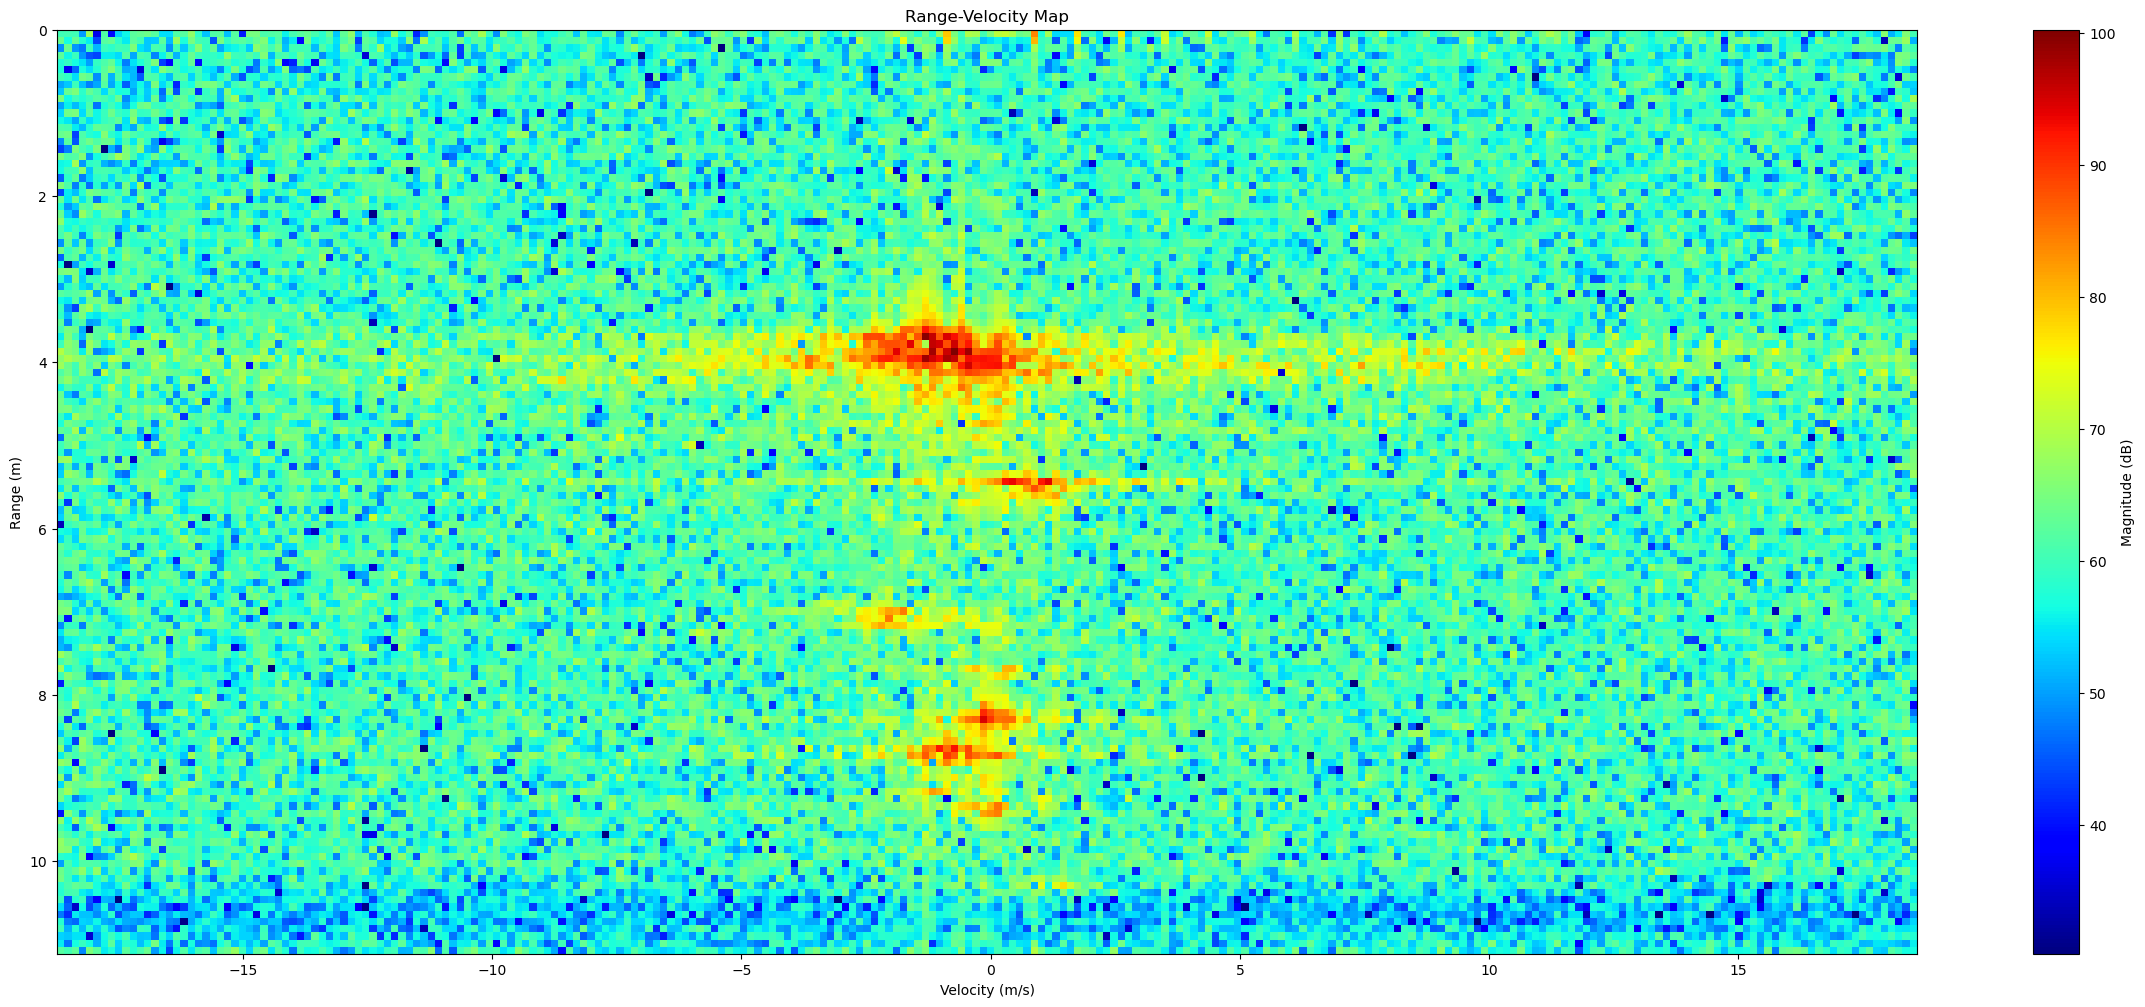

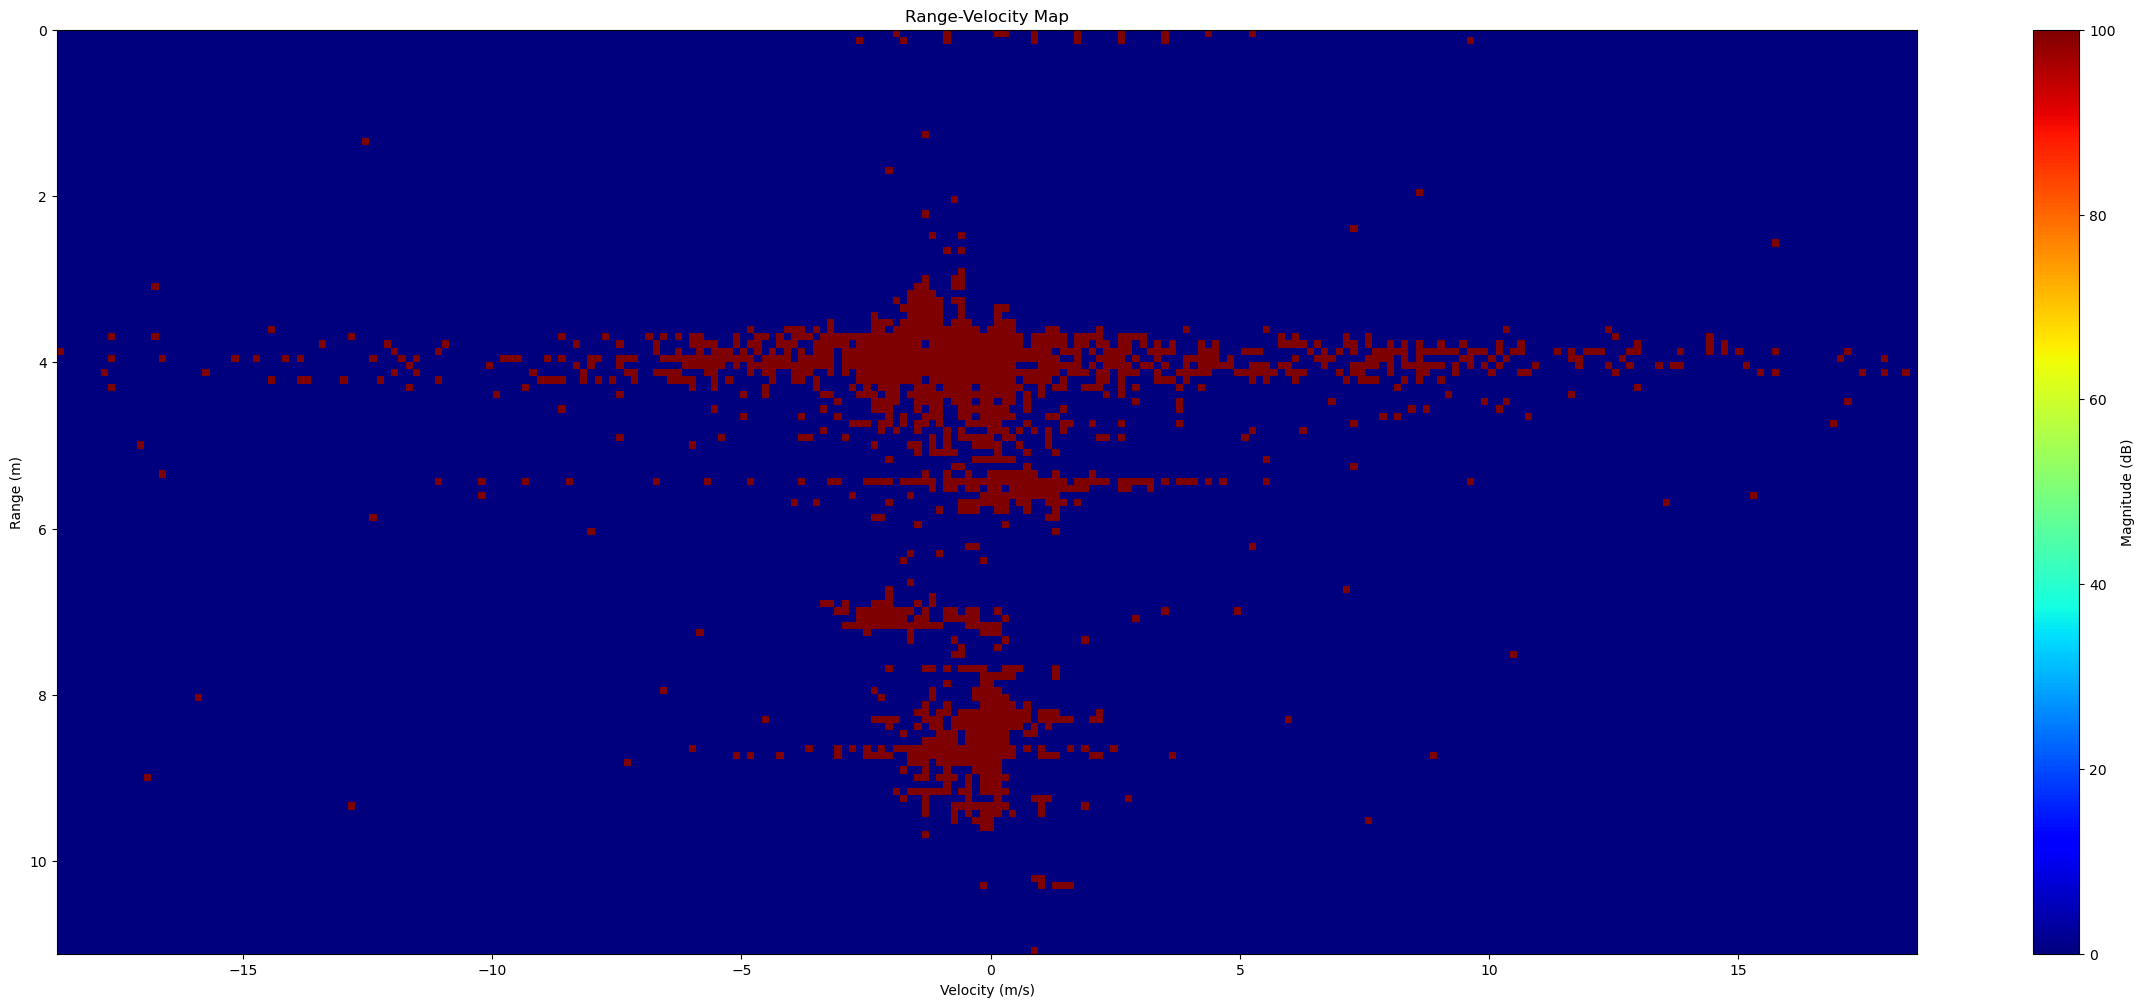

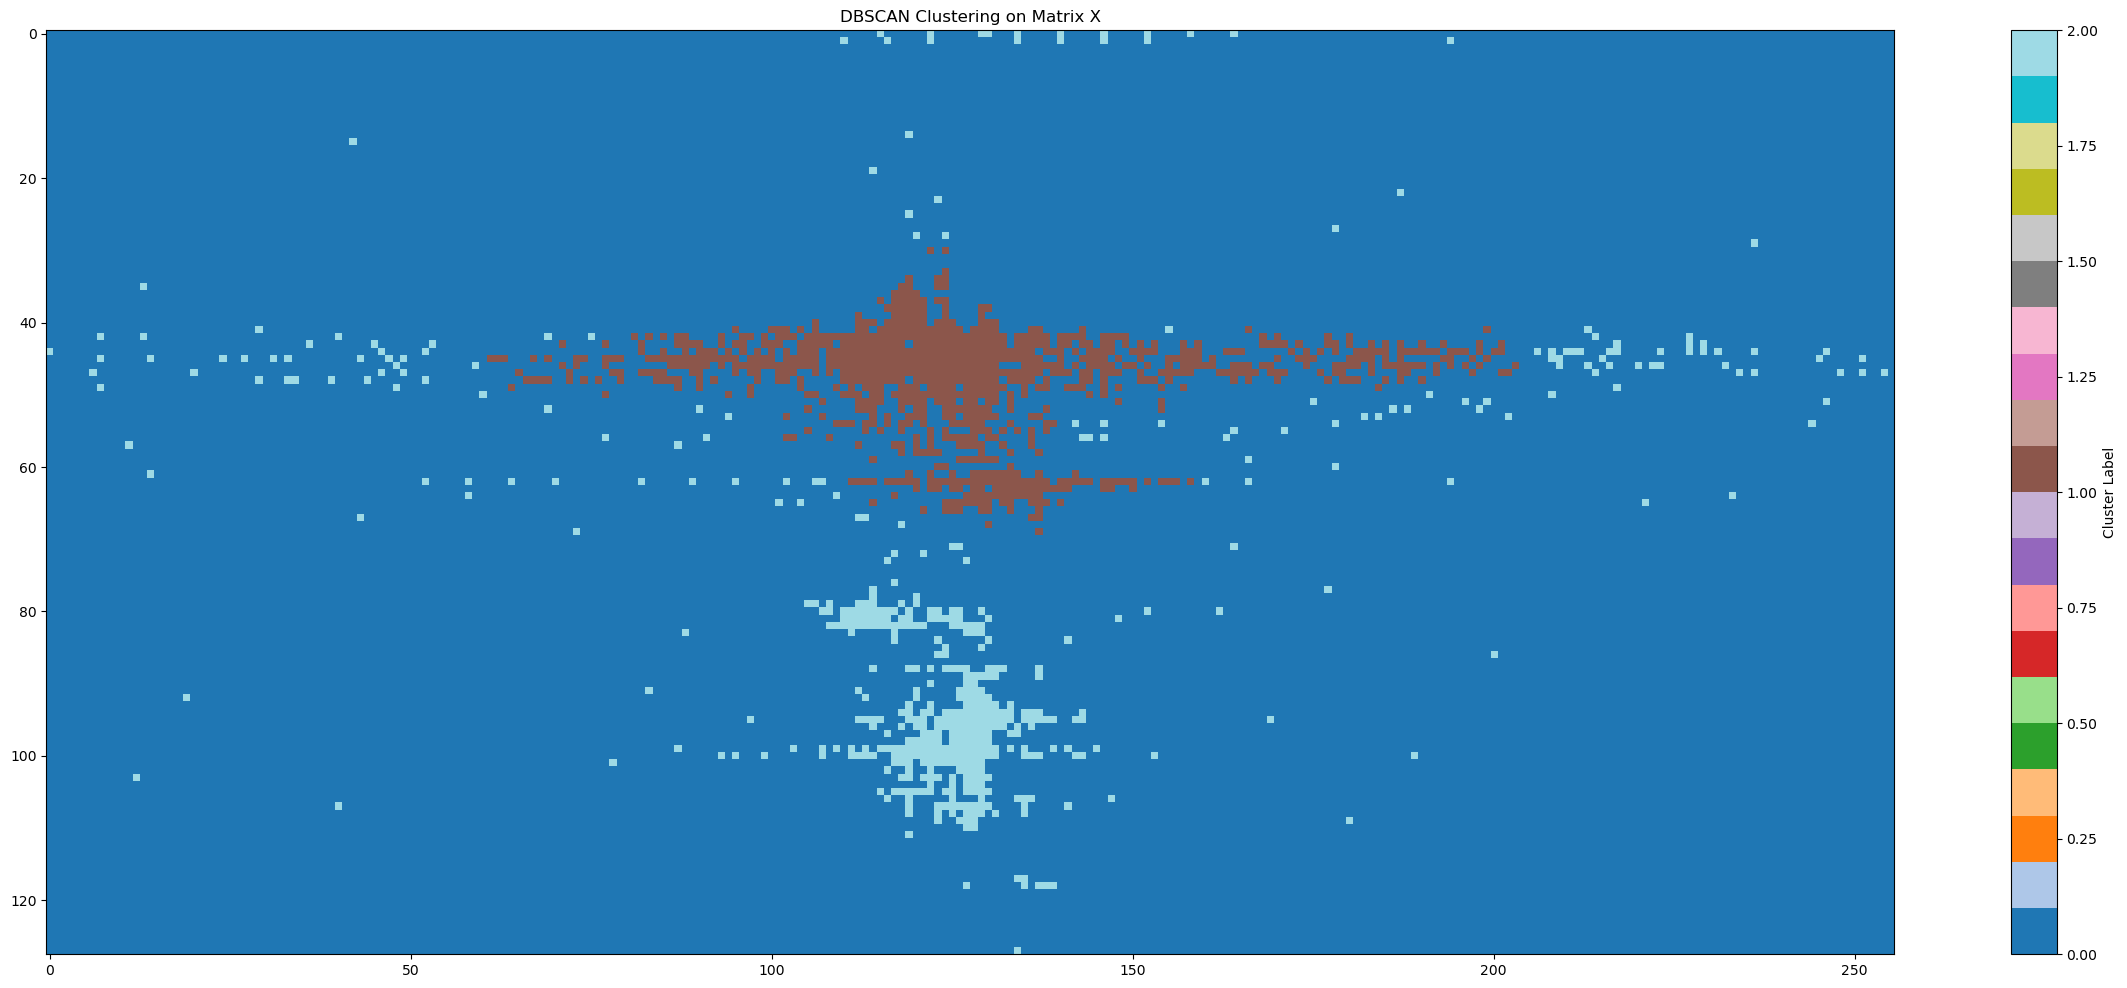

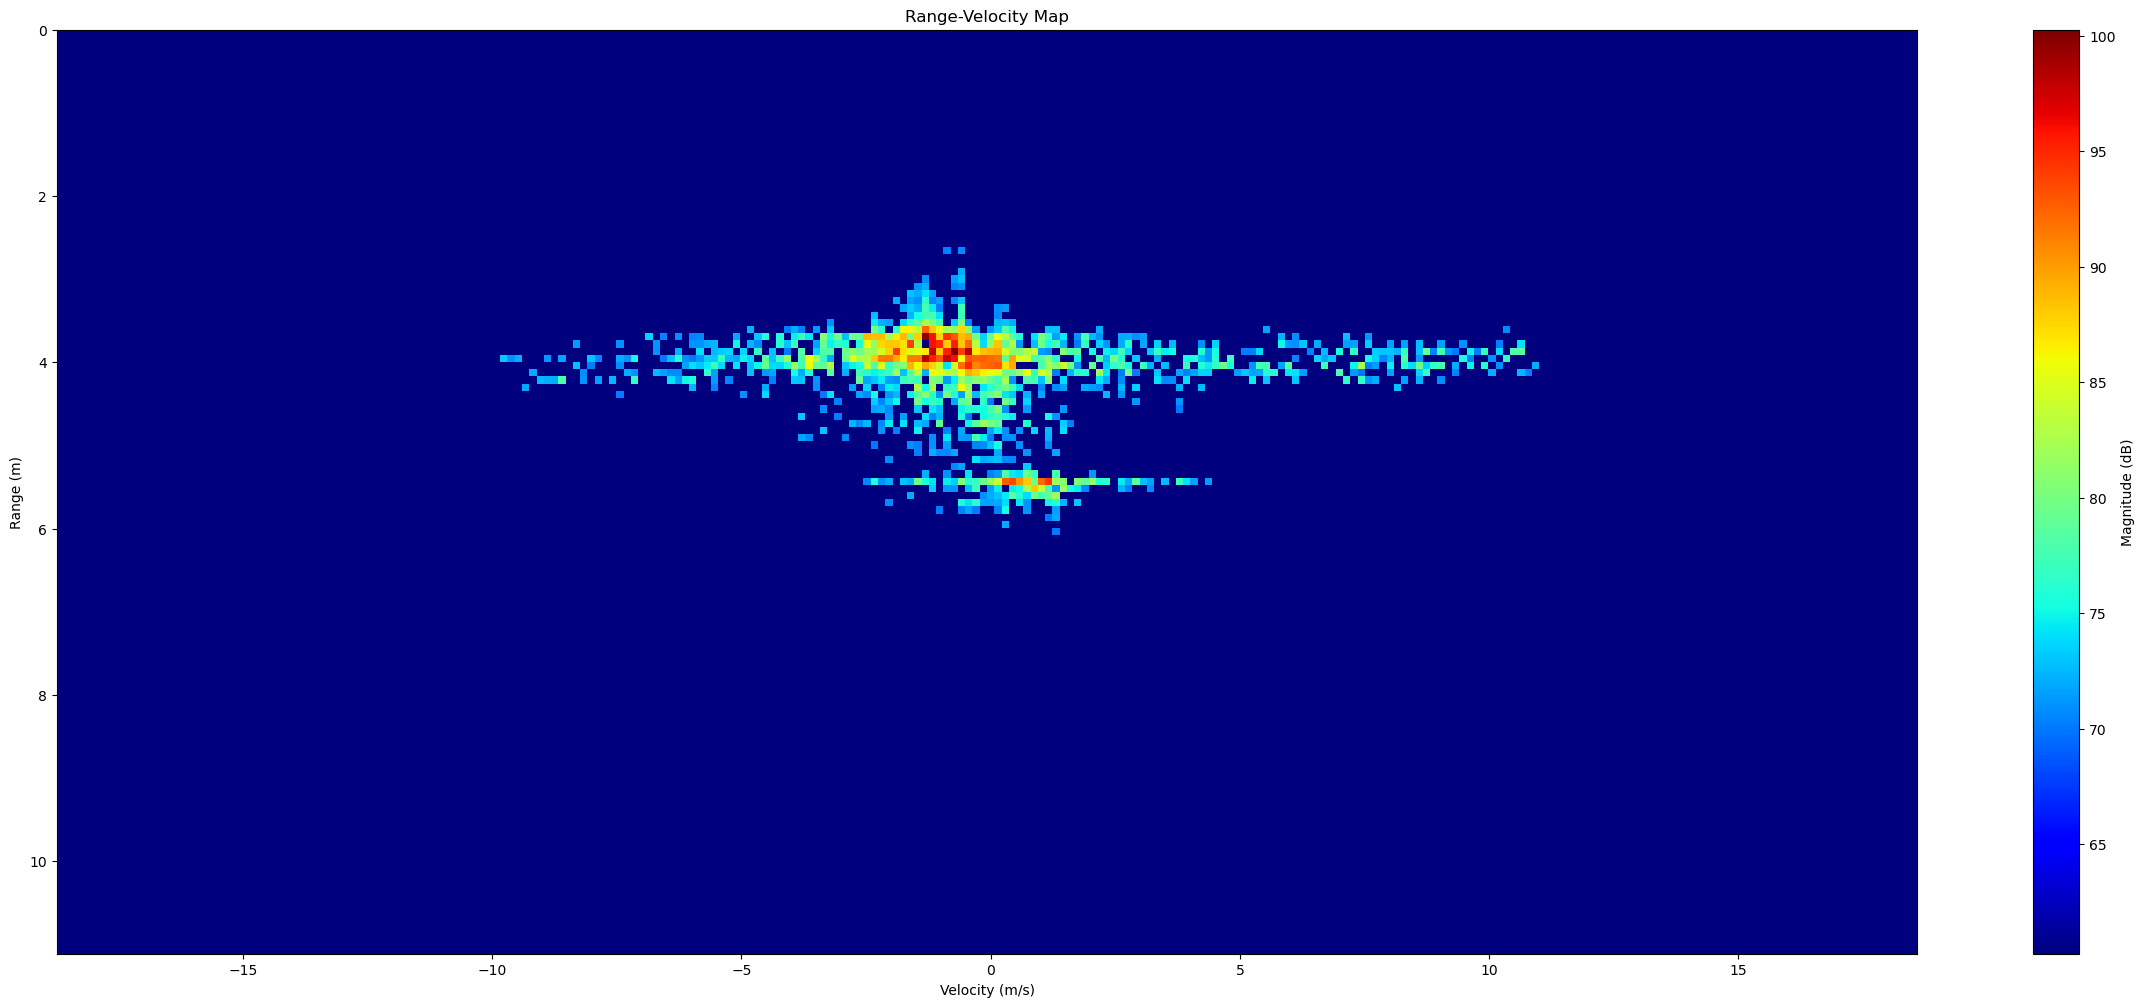

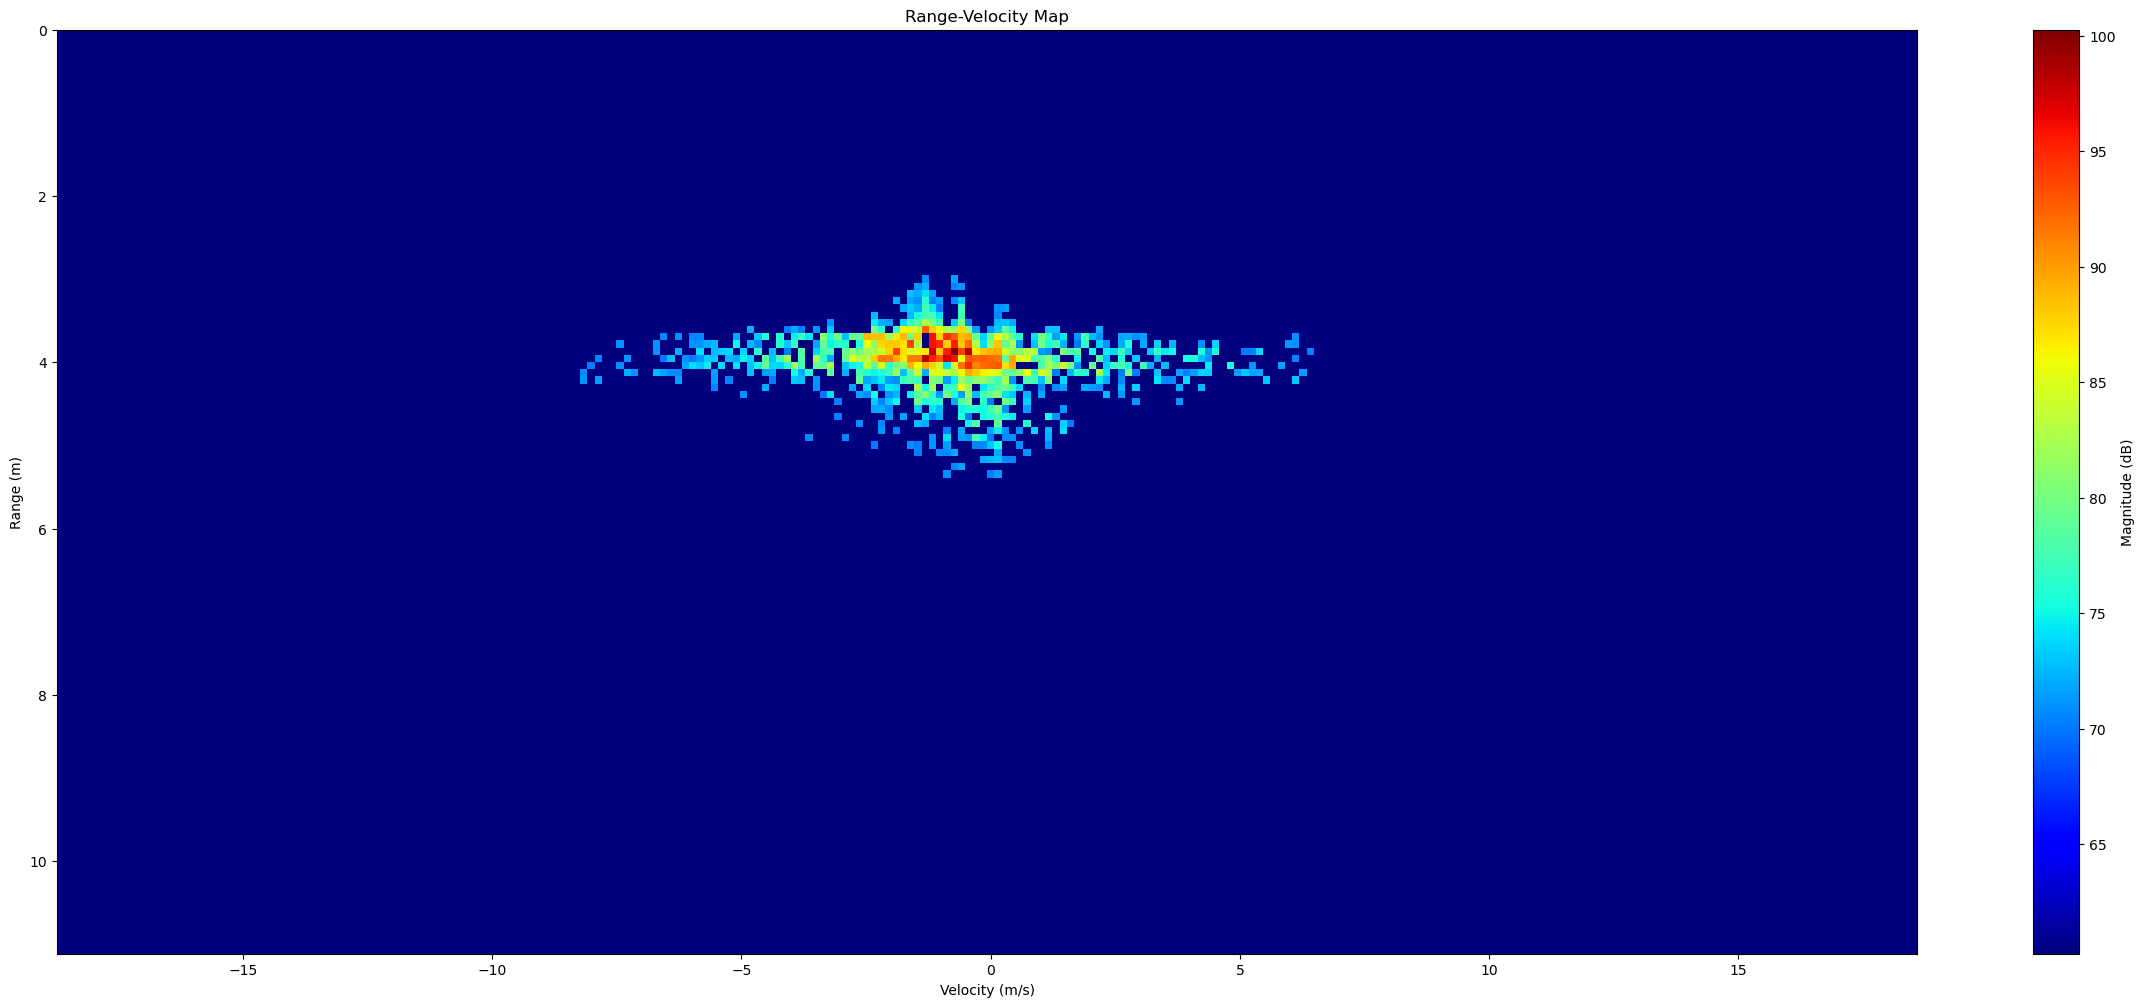

In [11]:
for i in range(10): 
    plot_original(i)
    plot_bf_cluster(i)
    plot_af_cluster(i)
    plot_final(i)
    plot_final_2(i)